__Dependencies__

In [1]:
import copy  # copy big/deep objects by value
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import os  # OS operations (read/write files/folders)
import warnings  # hide warnings

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count

import matplotlib.patches as mpatches  # create custom plot legends
import matplotlib.pyplot as plt  # mother of plots focr Python
import matplotlib.ticker as ticker  # matplotlib ticker utils
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import display  # print nicely
from matplotlib.lines import Line2D  # matplotlib custom lines
from scipy import stats  # statistical tests
from tqdm.notebook import tqdm  # mother of progressbars for Python

# from matplotlib.ticker import FormatStrFormatter  # tick formatter

__Options__

In [2]:
warnings.filterwarnings("ignore")
# set default float display format to 2 decimals
pd.options.display.float_format = "{:.3f}".format

STYLE = "whitegrid"
sns.set(rc={"figure.figsize": (20, 8)})  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style

PATH_PROC = "./data/processed"

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""

"""
Event1: 1162-1400
Event2: 1958-2080
Event3: 2596-2890
"""
event_ranges = [(1162, 1400), (1958, 2080), (2596, 2890)]

CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")

Total CPU threads: 16


__Read participants cleaned data__

In [3]:
parts = pd.read_csv("./participants_clean.csv", keep_default_na=False)
parts = parts.set_index("id")  # set uid column as index (remove default)
parts

date  expo   side  \
id                                                                   
4f583872ffed48249874b00f3d389cfc  2019-05-14 13:21:00   MSW  right   
33d68ad55ef544fab9fd08108e3913ca  2019-05-14 16:44:00   MSW  right   
8598a83e2af441b8bcd0ae5d84beb875  2019-05-14 16:51:00   MSW  right   
37d7e67934974217830bb429bba7fd76  2019-05-14 16:54:00   MSW   left   
42bac596059749b5b8e8e83ae61de9b4  2019-05-14 16:56:00   MSW  right   
...                                               ...   ...    ...   
cfe9482181f74f80b88cd4b1c048ab94  2019-12-30 15:29:00  BMBF  right   
611d35a7c3e940cc82495e53c2a8532d  2020-01-03 16:12:00  BMBF  right   
3b6fda285d9e412eb081986b2f22a2e3  2020-01-03 16:13:00  BMBF   left   
18ffb0abdc8642098c479380bfa533d1  2020-01-03 16:15:00  BMBF   left   
c06f123b35b74bb489ec239b1cac9eb4  2020-01-03 16:16:00  BMBF  right   

                                   condition  nulls_%  sky_%  insidecar_%  \
id                                                                          
4f583872ffed48249874b00f3d389cfc  TaxiDriver    1.610 13.740        2.359   
33d68ad55ef544fab9fd08108e3913ca        AVAS    0.037  0.674       25.421   
8598a83e2af441b8bcd0ae5d84beb875   RadioTalk    0.037 33.134        0.786   
37d7e67934974217830bb429bba7fd76        AVAS    0.824 18.607        2.845   
42bac596059749b5b8e8e83ae61de9b4  TaxiDriver    0.225 26.994        0.262   
...                                      ...      ...    ...          ...   
cfe9482181f74f80b88cd4b1c048ab94        AVAS    0.300 32.160        0.000   
611d35a7c3e940cc82495e53c2a8532d  TaxiDriver    0.674 15.462        5.054   
3b6fda285d9e412eb081986b2f22a2e3        AVAS    1.797  3.370       11.718   
18ffb0abdc8642098c479380bfa533d1   RadioTalk    0.150 17.484        1.872   
c06f123b35b74bb489ec239b1cac9eb4  TaxiDriver    0.187  2.583       17.634   

                                 questionnaire  
id                                              
4f583872ffed48249874b00f3d389cfc            No  
33d68ad55ef544fab9fd08108e3913ca            No  
8598a83e2af441b8bcd0ae5d84beb875            No  
37d7e67934974217830bb429bba7fd76            No  
42bac596059749b5b8e8e83ae61de9b4            No  
...                                        ...  
cfe9482181f74f80b88cd4b1c048ab94            No  
611d35a7c3e940cc82495e53c2a8532d            No  
3b6fda285d9e412eb081986b2f22a2e3            No  
18ffb0abdc8642098c479380bfa533d1           Yes  
c06f123b35b74bb489ec239b1cac9eb4            No  

[24356 rows x 8 columns]

__Null data check__

In [4]:
COL = "nulls_%"
parts[parts[COL] > 5].sort_values(by=[COL]).index.size

49

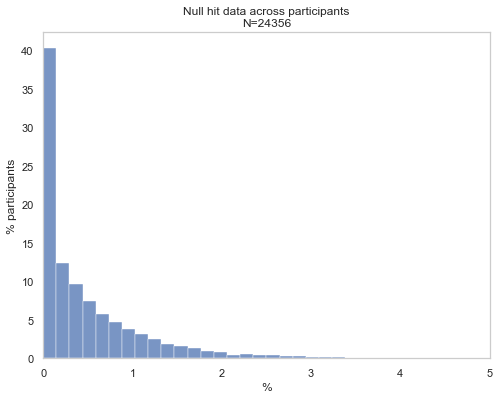

In [5]:
sns.set(rc={"figure.figsize": (8, 6)})  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style

ax = sns.histplot(data=parts["nulls_%"], stat="percent", bins=100)

ax.set_xlim(0, 5)
ax.grid(False)
ax.set_xlabel("%")
ax.set_ylabel("% participants")

plt.title(f"Null hit data across participants\nN={parts.index.size}")
plt.show()

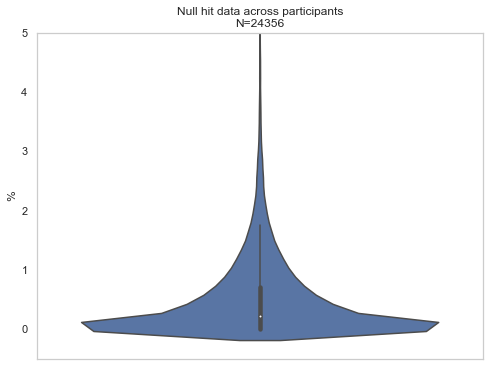

In [6]:
sns.set(rc={"figure.figsize": (8, 6)})  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style

ax = sns.violinplot(data=parts["nulls_%"], stat="percent")

ax.set_ylim(-0.5, 5)
ax.grid(False)
ax.set_xticklabels([])
ax.set_ylabel("%")

plt.title(f"Null hit data across participants\nN={parts.index.size}")
plt.show()

In [7]:
quests = pd.read_csv("./questionnaires.csv", keep_default_na=False)
quests = quests.set_index("id")  # set uid column as index (remove default)
quests

date  Intention  Usefulness  \
id                                                                             
ec61bab6e46741969bceb80ee2246983  2019-05-26 12:06:22         50          50   
1fbde03890d94bddaf7aa987fc732607  2019-05-26 16:02:45        100         100   
1ad9eea672a94518b150925bac41fcbc  2019-05-26 17:23:38         17          22   
461b2d80132f47958e50003c16084cf4  2019-05-26 17:27:34         30          70   
4f300efb4a9941f7a96f57e8030b12e2  2019-05-26 17:39:25        100         100   
...                                               ...        ...         ...   
eda9175e9e1d4153ac2ca3038b2ab008  2019-12-23 09:23:08         65          30   
b8c9e625f07444cc8d4a0fc245bab5dd  2019-12-23 09:28:25        100          50   
2cd78ad9a37945de9f8cfd5f81c42082  2019-12-27 12:56:23         86          20   
dba04b626e4c4c6e89aea4fb1f9cc32b  2019-12-30 13:50:37         84          89   
18ffb0abdc8642098c479380bfa533d1  2020-01-03 16:16:41         88          83   

                                  Ease  Trust    Gender  Age  Aviophobia  \
id                                                                         
ec61bab6e46741969bceb80ee2246983    50     50  intersex   25           1   
1fbde03890d94bddaf7aa987fc732607   100     96      Male   13           0   
1ad9eea672a94518b150925bac41fcbc     0     86    Female   24           0   
461b2d80132f47958e50003c16084cf4    80     80      Male   22           0   
4f300efb4a9941f7a96f57e8030b12e2    50     50      Male   16           0   
...                                ...    ...       ...  ...         ...   
eda9175e9e1d4153ac2ca3038b2ab008    33     20      Male   12           0   
b8c9e625f07444cc8d4a0fc245bab5dd    50    100    Female   12           1   
2cd78ad9a37945de9f8cfd5f81c42082    71     69      Male   57           0   
dba04b626e4c4c6e89aea4fb1f9cc32b    61     92      Male   73           0   
18ffb0abdc8642098c479380bfa533d1    94     33    Female   32           0   

                                  Driving  Play                  VR  expo  \
id                                                                          
ec61bab6e46741969bceb80ee2246983       80    58  more than 10 times   MSW   
1fbde03890d94bddaf7aa987fc732607        0     5                once   MSW   
1ad9eea672a94518b150925bac41fcbc        4     2                once   MSW   
461b2d80132f47958e50003c16084cf4        3     1  less than 10 times   MSW   
4f300efb4a9941f7a96f57e8030b12e2        0     3  less than 10 times   MSW   
...                                   ...   ...                 ...   ...   
eda9175e9e1d4153ac2ca3038b2ab008        0    25                once  BMBF   
b8c9e625f07444cc8d4a0fc245bab5dd       99     9  less than 10 times  BMBF   
2cd78ad9a37945de9f8cfd5f81c42082       39     0               never  BMBF   
dba04b626e4c4c6e89aea4fb1f9cc32b       55     0               never  BMBF   
18ffb0abdc8642098c479380bfa533d1        2     1  more than 10 times  BMBF   

                                   side   condition  
id                                                   
ec61bab6e46741969bceb80ee2246983  right   RadioTalk  
1fbde03890d94bddaf7aa987fc732607   left   RadioTalk  
1ad9eea672a94518b150925bac41fcbc  right   RadioTalk  
461b2d80132f47958e50003c16084cf4  right  TaxiDriver  
4f300efb4a9941f7a96f57e8030b12e2  right   RadioTalk  
...                                 ...         ...  
eda9175e9e1d4153ac2ca3038b2ab008  right   RadioTalk  
b8c9e625f07444cc8d4a0fc245bab5dd  right  TaxiDriver  
2cd78ad9a37945de9f8cfd5f81c42082  right   RadioTalk  
dba04b626e4c4c6e89aea4fb1f9cc32b   left  TaxiDriver  
18ffb0abdc8642098c479380bfa533d1   left   RadioTalk  

[9507 rows x 14 columns]

__Filter out outliers (mean + 1std)__

In [8]:
outs = pd.read_csv("./outliers_sky_%.csv", index_col=0)
outs = outs[outs["1std"] == False].index.tolist()
parts = parts.loc[outs]
display(parts)
outs_quest = quests.index.intersection(outs)
quests = quests.loc[outs_quest]
display(quests)

date  expo   side  \
id                                                                   
4f583872ffed48249874b00f3d389cfc  2019-05-14 13:21:00   MSW  right   
33d68ad55ef544fab9fd08108e3913ca  2019-05-14 16:44:00   MSW  right   
37d7e67934974217830bb429bba7fd76  2019-05-14 16:54:00   MSW   left   
9cdd85098b0b4ad5ab2282a5ac371a5e  2019-05-14 16:59:00   MSW  right   
ff846d92c7e6471183595bd2678f29f6  2019-05-14 17:37:00   MSW  right   
...                                               ...   ...    ...   
dba04b626e4c4c6e89aea4fb1f9cc32b  2019-12-30 13:48:00  BMBF   left   
611d35a7c3e940cc82495e53c2a8532d  2020-01-03 16:12:00  BMBF  right   
3b6fda285d9e412eb081986b2f22a2e3  2020-01-03 16:13:00  BMBF   left   
18ffb0abdc8642098c479380bfa533d1  2020-01-03 16:15:00  BMBF   left   
c06f123b35b74bb489ec239b1cac9eb4  2020-01-03 16:16:00  BMBF  right   

                                   condition  nulls_%  sky_%  insidecar_%  \
id                                                                          
4f583872ffed48249874b00f3d389cfc  TaxiDriver    1.610 13.740        2.359   
33d68ad55ef544fab9fd08108e3913ca        AVAS    0.037  0.674       25.421   
37d7e67934974217830bb429bba7fd76        AVAS    0.824 18.607        2.845   
9cdd85098b0b4ad5ab2282a5ac371a5e        AVAS    0.000 20.030        0.000   
ff846d92c7e6471183595bd2678f29f6        AVAS    0.037 15.575        1.235   
...                                      ...      ...    ...          ...   
dba04b626e4c4c6e89aea4fb1f9cc32b  TaxiDriver    0.000 22.501        0.000   
611d35a7c3e940cc82495e53c2a8532d  TaxiDriver    0.674 15.462        5.054   
3b6fda285d9e412eb081986b2f22a2e3        AVAS    1.797  3.370       11.718   
18ffb0abdc8642098c479380bfa533d1   RadioTalk    0.150 17.484        1.872   
c06f123b35b74bb489ec239b1cac9eb4  TaxiDriver    0.187  2.583       17.634   

                                 questionnaire  
id                                              
4f583872ffed48249874b00f3d389cfc            No  
33d68ad55ef544fab9fd08108e3913ca            No  
37d7e67934974217830bb429bba7fd76            No  
9cdd85098b0b4ad5ab2282a5ac371a5e            No  
ff846d92c7e6471183595bd2678f29f6            No  
...                                        ...  
dba04b626e4c4c6e89aea4fb1f9cc32b           Yes  
611d35a7c3e940cc82495e53c2a8532d            No  
3b6fda285d9e412eb081986b2f22a2e3            No  
18ffb0abdc8642098c479380bfa533d1           Yes  
c06f123b35b74bb489ec239b1cac9eb4            No  

[20848 rows x 8 columns]

date  Intention  Usefulness  \
id                                                                             
ec61bab6e46741969bceb80ee2246983  2019-05-26 12:06:22         50          50   
1fbde03890d94bddaf7aa987fc732607  2019-05-26 16:02:45        100         100   
1ad9eea672a94518b150925bac41fcbc  2019-05-26 17:23:38         17          22   
461b2d80132f47958e50003c16084cf4  2019-05-26 17:27:34         30          70   
4f300efb4a9941f7a96f57e8030b12e2  2019-05-26 17:39:25        100         100   
...                                               ...        ...         ...   
eda9175e9e1d4153ac2ca3038b2ab008  2019-12-23 09:23:08         65          30   
b8c9e625f07444cc8d4a0fc245bab5dd  2019-12-23 09:28:25        100          50   
2cd78ad9a37945de9f8cfd5f81c42082  2019-12-27 12:56:23         86          20   
dba04b626e4c4c6e89aea4fb1f9cc32b  2019-12-30 13:50:37         84          89   
18ffb0abdc8642098c479380bfa533d1  2020-01-03 16:16:41         88          83   

                                  Ease  Trust    Gender  Age  Aviophobia  \
id                                                                         
ec61bab6e46741969bceb80ee2246983    50     50  intersex   25           1   
1fbde03890d94bddaf7aa987fc732607   100     96      Male   13           0   
1ad9eea672a94518b150925bac41fcbc     0     86    Female   24           0   
461b2d80132f47958e50003c16084cf4    80     80      Male   22           0   
4f300efb4a9941f7a96f57e8030b12e2    50     50      Male   16           0   
...                                ...    ...       ...  ...         ...   
eda9175e9e1d4153ac2ca3038b2ab008    33     20      Male   12           0   
b8c9e625f07444cc8d4a0fc245bab5dd    50    100    Female   12           1   
2cd78ad9a37945de9f8cfd5f81c42082    71     69      Male   57           0   
dba04b626e4c4c6e89aea4fb1f9cc32b    61     92      Male   73           0   
18ffb0abdc8642098c479380bfa533d1    94     33    Female   32           0   

                                  Driving  Play                  VR  expo  \
id                                                                          
ec61bab6e46741969bceb80ee2246983       80    58  more than 10 times   MSW   
1fbde03890d94bddaf7aa987fc732607        0     5                once   MSW   
1ad9eea672a94518b150925bac41fcbc        4     2                once   MSW   
461b2d80132f47958e50003c16084cf4        3     1  less than 10 times   MSW   
4f300efb4a9941f7a96f57e8030b12e2        0     3  less than 10 times   MSW   
...                                   ...   ...                 ...   ...   
eda9175e9e1d4153ac2ca3038b2ab008        0    25                once  BMBF   
b8c9e625f07444cc8d4a0fc245bab5dd       99     9  less than 10 times  BMBF   
2cd78ad9a37945de9f8cfd5f81c42082       39     0               never  BMBF   
dba04b626e4c4c6e89aea4fb1f9cc32b       55     0               never  BMBF   
18ffb0abdc8642098c479380bfa533d1        2     1  more than 10 times  BMBF   

                                   side   condition  
id                                                   
ec61bab6e46741969bceb80ee2246983  right   RadioTalk  
1fbde03890d94bddaf7aa987fc732607   left   RadioTalk  
1ad9eea672a94518b150925bac41fcbc  right   RadioTalk  
461b2d80132f47958e50003c16084cf4  right  TaxiDriver  
4f300efb4a9941f7a96f57e8030b12e2  right   RadioTalk  
...                                 ...         ...  
eda9175e9e1d4153ac2ca3038b2ab008  right   RadioTalk  
b8c9e625f07444cc8d4a0fc245bab5dd  right  TaxiDriver  
2cd78ad9a37945de9f8cfd5f81c42082  right   RadioTalk  
dba04b626e4c4c6e89aea4fb1f9cc32b   left  TaxiDriver  
18ffb0abdc8642098c479380bfa533d1   left   RadioTalk  

[8207 rows x 14 columns]

__Descriptive statistics from each numerical variable__

In [9]:
cols = list(quests.describe().columns.difference(["frames", "Aviophobia"]))
quests[cols].describe()

Age  Driving     Ease  Intention     Play    Trust  Usefulness
count 8207.000 8207.000 8207.000   8207.000 8207.000 8207.000    8207.000
mean    29.994   16.178   64.885     61.308    9.121   66.387      63.971
std     21.240   21.767   31.429     34.445   21.214   32.085      32.331
min      0.000    0.000    0.000      0.000    0.000    0.000       0.000
25%     13.000    0.000   50.000     34.000    0.000   45.500      50.000
50%     21.000    6.000   70.000     67.000    1.000   75.000      70.000
75%     46.000   28.000  100.000    100.000    7.000  100.000      99.000
max     99.000   99.000  100.000    100.000   99.000  100.000     100.000

__Distribution of each numerical variable__

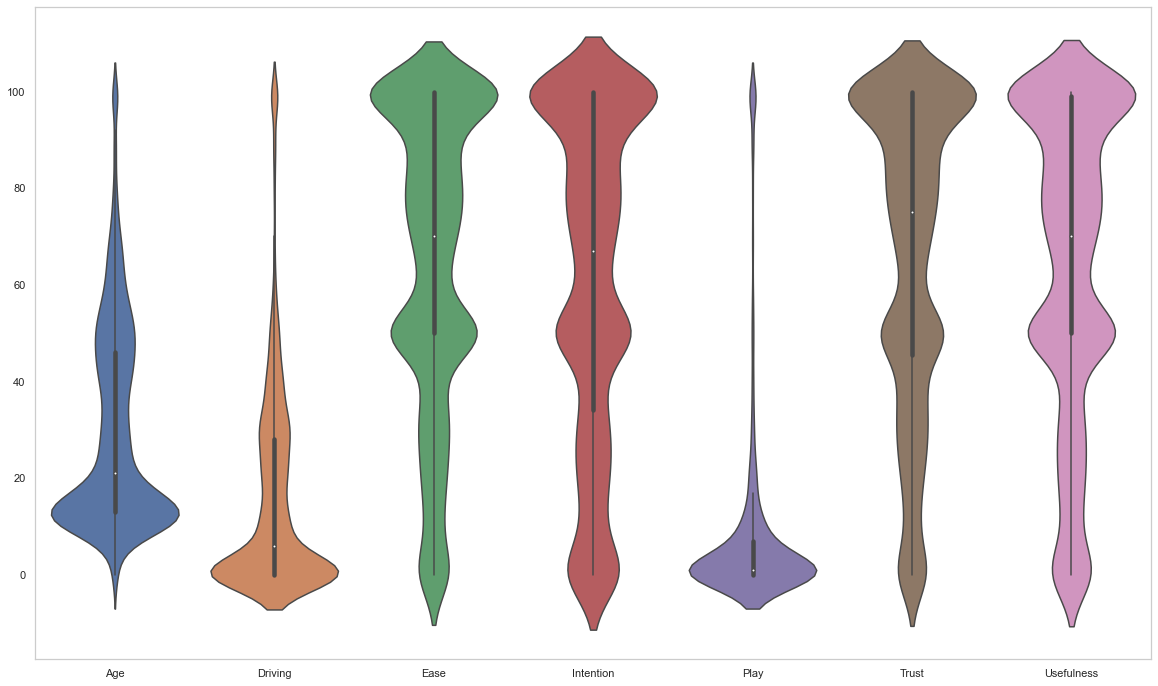

In [10]:
plt.figure(figsize=(20, 12))
ax = sns.violinplot(
    data=quests[quests.columns.difference(["frames", "Aviophobia"])],
    order=cols,
    scale="width",
)
ax.grid(False)
plt.show()

__Correlation matrix of the numerical variables__

Age  Aviophobia  Driving   Ease  Intention   Play  Trust  \
Age         1.000      -0.017    0.629 -0.132     -0.147 -0.048 -0.120   
Aviophobia -0.017       1.000    0.083 -0.082     -0.056  0.175 -0.095   
Driving     0.629       0.083    1.000 -0.079     -0.092  0.251 -0.108   
Ease       -0.132      -0.082   -0.079  1.000      0.600  0.056  0.487   
Intention  -0.147      -0.056   -0.092  0.600      1.000  0.038  0.511   
Play       -0.048       0.175    0.251  0.056      0.038  1.000 -0.051   
Trust      -0.120      -0.095   -0.108  0.487      0.511 -0.051  1.000   
Usefulness -0.131      -0.061   -0.110  0.535      0.637  0.016  0.470   

            Usefulness  
Age             -0.131  
Aviophobia      -0.061  
Driving         -0.110  
Ease             0.535  
Intention        0.637  
Play             0.016  
Trust            0.470  
Usefulness       1.000

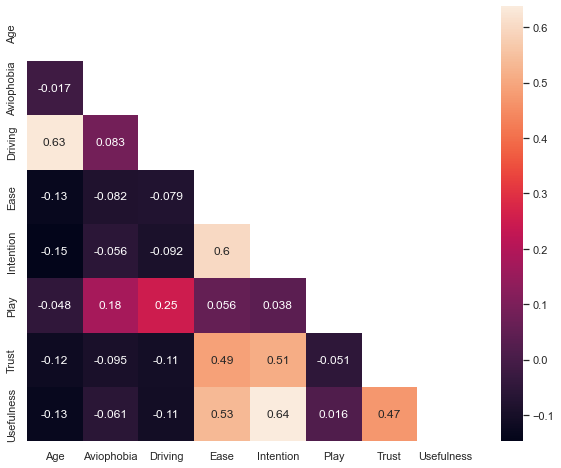

In [11]:
# remove the number of frames as it's uninformative
parts_an = copy.deepcopy(quests[quests.columns.difference(["frames"])])

cm_parts = parts_an.corr(method="pearson")
display(cm_parts)

# generate a mask to drop the upper part of the matrix (duplicated info)
mask = np.triu(np.ones_like(cm_parts, dtype=np.bool))

# figure size
plt.figure(figsize=(10, 8))

# display the correlation matrix as a heatmap
sns.heatmap(cm_parts, annot=True, mask=mask)
plt.show()

__Population count and density for each categorical variable__

count      %
Gender                
Male       4358 53.101
Female     3069 37.395
intersex    431  5.252
N/A         349  4.252

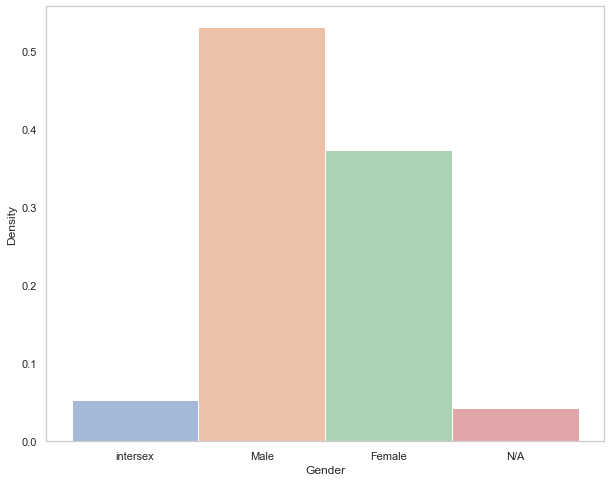

count      %
VR                              
never                2708 32.996
less than 10 times   2613 31.839
once                 1807 22.018
more than 10 times   1079 13.147

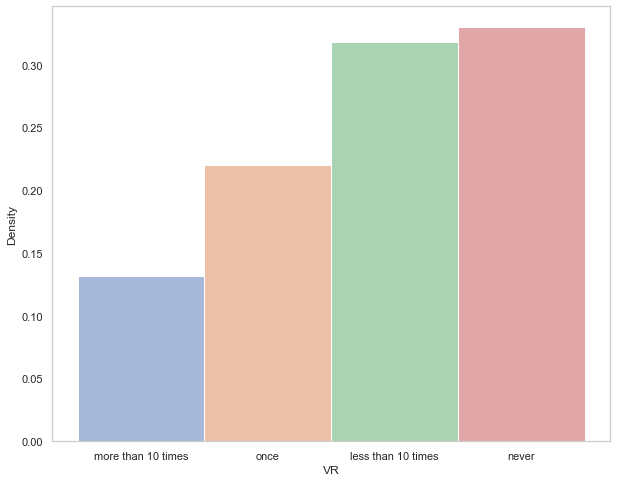

count      %
expo              
MSW    7271 88.595
BMBF    936 11.405

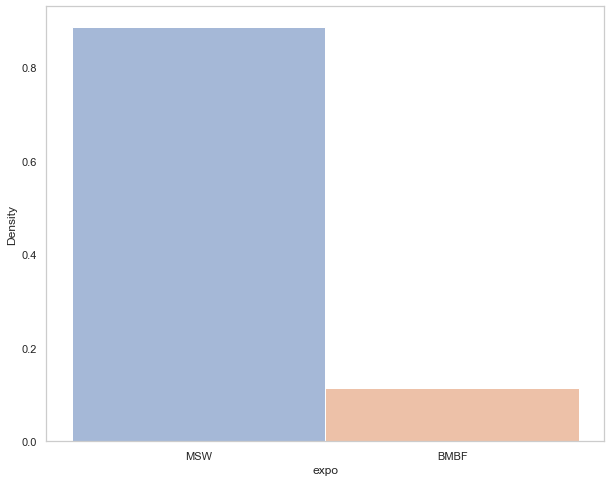

count      %
condition               
AVAS         2870 34.970
TaxiDriver   2671 32.545
RadioTalk    2666 32.484

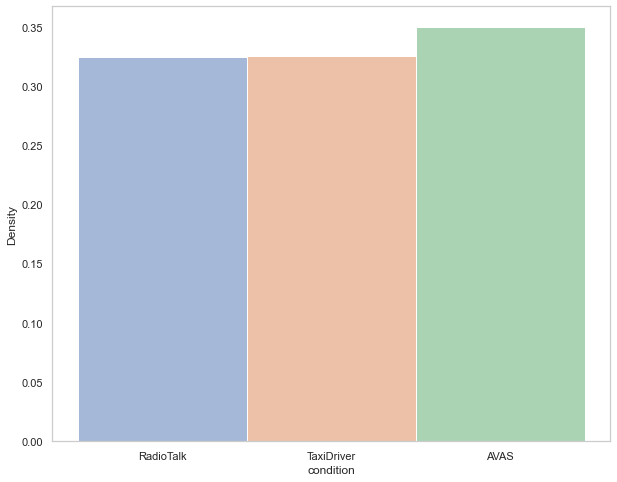

In [12]:
# categorical columns to compute descriptive statistics
cols = ["Gender", "VR", "expo", "condition"]
for col in cols:  # for each defined column
    counts = quests[col].value_counts()
    percents = quests[col].value_counts(normalize=True).mul(100)
    df = pd.DataFrame({"count": counts, "%": percents})
    df.index.name = col
    # show counts vs percentage
    display(df)
    # plot directly without the previous calculations (seaborn takes care of it)
    plt.figure(figsize=(10, 8))
    ax = sns.histplot(
        data=quests, x=col, hue=col, stat="density", legend=False
    )
    ax.grid(False)
    plt.show()

In [13]:
hev_cnts = pd.read_csv("./hit_events_counters.csv", index_col=0)
display(hev_cnts)
display(hev_cnts.describe())

rest_cnt  gaze_cnt  rest_avg  gaze_avg  \
4f583872ffed48249874b00f3d389cfc   434.000    67.000     0.066     0.876   
33d68ad55ef544fab9fd08108e3913ca   280.000    80.000     0.083     0.811   
8598a83e2af441b8bcd0ae5d84beb875   110.000    37.000     0.089     1.336   
37d7e67934974217830bb429bba7fd76   586.000    69.000     0.059     0.767   
42bac596059749b5b8e8e83ae61de9b4   333.000    70.000     0.073     0.774   
...                                    ...       ...       ...       ...   
cfe9482181f74f80b88cd4b1c048ab94   197.000    67.000     0.080     0.786   
611d35a7c3e940cc82495e53c2a8532d   380.000    56.000     0.070     1.097   
3b6fda285d9e412eb081986b2f22a2e3   456.000    85.000     0.068     0.665   
18ffb0abdc8642098c479380bfa533d1   544.000    77.000     0.068     0.589   
c06f123b35b74bb489ec239b1cac9eb4   374.000    84.000     0.076     0.710   

                                  rest_mdn  gaze_mdn  rest_dist_avg  \
4f583872ffed48249874b00f3d389cfc     0.033     0.495        104.681   
33d68ad55ef544fab9fd08108e3913ca     0.066     0.611         20.270   
8598a83e2af441b8bcd0ae5d84beb875     0.066     0.660         95.261   
37d7e67934974217830bb429bba7fd76     0.033     0.396        120.903   
42bac596059749b5b8e8e83ae61de9b4     0.066     0.462        166.052   
...                                    ...       ...            ...   
cfe9482181f74f80b88cd4b1c048ab94     0.066     0.462        155.156   
611d35a7c3e940cc82495e53c2a8532d     0.033     0.627        107.759   
3b6fda285d9e412eb081986b2f22a2e3     0.033     0.495         77.189   
18ffb0abdc8642098c479380bfa533d1     0.033     0.429        117.366   
c06f123b35b74bb489ec239b1cac9eb4     0.066     0.528         30.474   

                                  gaze_dist_avg  rest_dist_mdn  gaze_dist_mdn  \
4f583872ffed48249874b00f3d389cfc        100.493         85.326         66.196   
33d68ad55ef544fab9fd08108e3913ca         10.064          2.389          2.369   
8598a83e2af441b8bcd0ae5d84beb875        148.664         47.726         92.824   
37d7e67934974217830bb429bba7fd76        101.458         81.686         58.163   
42bac596059749b5b8e8e83ae61de9b4        158.886        104.916        100.255   
...                                         ...            ...            ...   
cfe9482181f74f80b88cd4b1c048ab94        120.764         74.446         73.856   
611d35a7c3e940cc82495e53c2a8532d         69.995         69.104         45.891   
3b6fda285d9e412eb081986b2f22a2e3         41.573         36.824         14.536   
18ffb0abdc8642098c479380bfa533d1         85.315         65.854         42.028   
c06f123b35b74bb489ec239b1cac9eb4         22.540          3.998          2.105   

                                  rest_len  gaze_len  rest_l_%  gaze_l_%  \
4f583872ffed48249874b00f3d389cfc    28.644    58.707    32.792    67.208   
33d68ad55ef544fab9fd08108e3913ca    23.232    64.911    26.357    73.643   
8598a83e2af441b8bcd0ae5d84beb875     9.834    49.434    16.592    83.408   
37d7e67934974217830bb429bba7fd76    34.815    52.899    39.691    60.309   
42bac596059749b5b8e8e83ae61de9b4    24.420    54.186    31.066    68.934   
...                                    ...       ...       ...       ...   
cfe9482181f74f80b88cd4b1c048ab94    15.675    52.635    22.947    77.053   
611d35a7c3e940cc82495e53c2a8532d    26.532    61.446    30.158    69.842   
3b6fda285d9e412eb081986b2f22a2e3    30.855    56.496    35.323    64.677   
18ffb0abdc8642098c479380bfa533d1    37.092    45.342    44.996    55.004   
c06f123b35b74bb489ec239b1cac9eb4    28.347    59.631    32.221    67.779   

                                  rest_c_%  gaze_c_%  
4f583872ffed48249874b00f3d389cfc    86.627    13.373  
33d68ad55ef544fab9fd08108e3913ca    77.778    22.222  
8598a83e2af441b8bcd0ae5d84beb875    74.830    25.170  
37d7e67934974217830bb429bba7fd76    89.466    10.534  
42bac596059749b5b8e8e83ae61de9b4    82.630    17.370  
...                                    ...       ...

rest_cnt  gaze_cnt  rest_avg  gaze_avg  rest_mdn  gaze_mdn  \
count 24356.000 24356.000 24355.000 24356.000 24355.000 24356.000   
mean    359.153    67.522     0.073     0.958     0.049     0.535   
std     155.745    13.208     0.008     0.988     0.017     0.803   
min       0.000     1.000     0.033     0.461     0.033     0.330   
25%     245.000    61.000     0.068     0.703     0.033     0.446   
50%     357.000    69.000     0.072     0.818     0.033     0.495   
75%     467.000    76.000     0.077     1.007     0.066     0.561   
max     958.000   102.000     0.143    88.143     0.148    88.143   

       rest_dist_avg  gaze_dist_avg  rest_dist_mdn  gaze_dist_mdn  rest_len  \
count      24355.000      24356.000      24355.000      24356.000 24356.000   
mean          77.796         68.653         43.551         35.107    25.500   
std           44.886         54.065         35.449         36.454     9.704   
min            0.236          0.267          0.165          0.267     0.000   
25%           41.333         19.174          7.313          2.465    18.711   
50%           80.208         59.114         41.028         22.380    25.905   
75%          110.564        108.458         68.260         62.087    32.406   
max          230.400        267.032        207.666        204.840    59.895   

       gaze_len  rest_l_%  gaze_l_%  rest_c_%  gaze_c_%  
count 24356.000 24356.000 24356.000 24356.000 24356.000  
mean     58.629    30.213    69.787    81.851    18.149  
std      10.289    11.102    11.102     7.120     7.120  
min      23.331     0.000    31.587     0.000     5.088  
25%      51.381    22.601    61.874    78.718    13.278  
50%      57.849    30.708    69.292    83.444    16.556  
75%      65.472    38.126    77.399    86.722    21.282  
max      88.143    68.413   100.000    94.912   100.000

In [14]:
hit_levs = pd.read_csv(f"./group_lengths.csv", index_col=0)
hit_levs

Buildings  Dynamic Cars  \
4f583872ffed48249874b00f3d389cfc     18.414         0.924   
33d68ad55ef544fab9fd08108e3913ca      0.000         0.594   
8598a83e2af441b8bcd0ae5d84beb875     38.313         0.000   
37d7e67934974217830bb429bba7fd76     17.259         2.508   
42bac596059749b5b8e8e83ae61de9b4     34.584         0.000   
...                                     ...           ...   
cfe9482181f74f80b88cd4b1c048ab94     34.056         0.000   
611d35a7c3e940cc82495e53c2a8532d     19.041         0.000   
3b6fda285d9e412eb081986b2f22a2e3      7.821         0.000   
18ffb0abdc8642098c479380bfa533d1     14.718         0.264   
c06f123b35b74bb489ec239b1cac9eb4      0.429         2.541   

                                  Dynamic Pedestrians  Inside Car  Nature  \
4f583872ffed48249874b00f3d389cfc                1.122       1.881   3.597   
33d68ad55ef544fab9fd08108e3913ca                0.000      28.677   0.297   
8598a83e2af441b8bcd0ae5d84beb875                0.000       0.627   0.924   
37d7e67934974217830bb429bba7fd76                1.122       4.719   5.049   
42bac596059749b5b8e8e83ae61de9b4                0.000       0.528   6.402   
...                                               ...         ...     ...   
cfe9482181f74f80b88cd4b1c048ab94                0.000       6.435   2.739   
611d35a7c3e940cc82495e53c2a8532d                0.000      24.288   4.686   
3b6fda285d9e412eb081986b2f22a2e3                0.462      18.381   0.660   
18ffb0abdc8642098c479380bfa533d1                0.000       5.478   4.950   
c06f123b35b74bb489ec239b1cac9eb4                0.000      35.112   1.485   

                                  Roads  Static Cars  Static Pedestrians  \
4f583872ffed48249874b00f3d389cfc 18.282        0.000               0.000   
33d68ad55ef544fab9fd08108e3913ca 30.360        0.000               0.000   
8598a83e2af441b8bcd0ae5d84beb875  0.000        0.000               0.000   
37d7e67934974217830bb429bba7fd76  1.122        0.330               0.000   
42bac596059749b5b8e8e83ae61de9b4  0.000        0.000               0.000   
...                                 ...          ...                 ...   
cfe9482181f74f80b88cd4b1c048ab94  0.000        0.000               0.000   
611d35a7c3e940cc82495e53c2a8532d  2.838        0.000               0.000   
3b6fda285d9e412eb081986b2f22a2e3 16.599        0.000               1.122   
18ffb0abdc8642098c479380bfa533d1  6.402        0.000               0.000   
c06f123b35b74bb489ec239b1cac9eb4 12.672        0.000               0.000   

                                  Street Objects  Traffic Lights  \
4f583872ffed48249874b00f3d389cfc           1.155          13.332   
33d68ad55ef544fab9fd08108e3913ca           0.363           4.620   
8598a83e2af441b8bcd0ae5d84beb875           0.363           9.207   
37d7e67934974217830bb429bba7fd76           2.013          18.777   
42bac596059749b5b8e8e83ae61de9b4           2.310          10.362   
...                                          ...             ...   
cfe9482181f74f80b88cd4b1c048ab94           1.023           8.382   
611d35a7c3e940cc82495e53c2a8532d           1.056           9.174   
3b6fda285d9e412eb081986b2f22a2e3           5.874           5.577   
18ffb0abdc8642098c479380bfa533d1           1.485          11.418   
c06f123b35b74bb489ec239b1cac9eb4           1.914           3.696   

                                  Traffic Signs  
4f583872ffed48249874b00f3d389cfc          0.000  
33d68ad55ef544fab9fd08108e3913ca          0.000  
8598a83e2af441b8bcd0ae5d84beb875          0.000  
37d7e67934974217830bb429bba7fd76          0.000  
42bac596059749b5b8e8e83ae61de9b4          0.000  
...                                         ...  
cfe9482181f74f80b88cd4b1c048ab94          0.000  
611d35a7c3e940cc82495e53c2a8532d          0.363  
3b6fda285d9e412eb081986b2f22a2e3          0.000  
18ffb0abdc8642098c479380bfa533d1          0.627  
c06f123b35b74bb489ec239b1cac9eb4          1.782  

[24356 rows x 11 columns]

In [15]:
hit_cevs = pd.read_csv(f"./group_counts.csv", index_col=0)
hit_cevs

Buildings  Dynamic Cars  \
4f583872ffed48249874b00f3d389cfc         23             2   
33d68ad55ef544fab9fd08108e3913ca          0             2   
8598a83e2af441b8bcd0ae5d84beb875         24             0   
37d7e67934974217830bb429bba7fd76         26             3   
42bac596059749b5b8e8e83ae61de9b4         40             0   
...                                     ...           ...   
cfe9482181f74f80b88cd4b1c048ab94         42             0   
611d35a7c3e940cc82495e53c2a8532d         19             0   
3b6fda285d9e412eb081986b2f22a2e3         10             0   
18ffb0abdc8642098c479380bfa533d1         24             1   
c06f123b35b74bb489ec239b1cac9eb4          1             3   

                                  Dynamic Pedestrians  Inside Car  Nature  \
4f583872ffed48249874b00f3d389cfc                    1           3       8   
33d68ad55ef544fab9fd08108e3913ca                    0          42       1   
8598a83e2af441b8bcd0ae5d84beb875                    0           2       3   
37d7e67934974217830bb429bba7fd76                    1          10      11   
42bac596059749b5b8e8e83ae61de9b4                    0           2      14   
...                                               ...         ...     ...   
cfe9482181f74f80b88cd4b1c048ab94                    0           9       6   
611d35a7c3e940cc82495e53c2a8532d                    0          18       8   
3b6fda285d9e412eb081986b2f22a2e3                    1          26       2   
18ffb0abdc8642098c479380bfa533d1                    0          13      12   
c06f123b35b74bb489ec239b1cac9eb4                    0          48       4   

                                  Roads  Static Cars  Static Pedestrians  \
4f583872ffed48249874b00f3d389cfc     19            0                   0   
33d68ad55ef544fab9fd08108e3913ca     32            0                   0   
8598a83e2af441b8bcd0ae5d84beb875      0            0                   0   
37d7e67934974217830bb429bba7fd76      4            1                   0   
42bac596059749b5b8e8e83ae61de9b4      0            0                   0   
...                                 ...          ...                 ...   
cfe9482181f74f80b88cd4b1c048ab94      0            0                   0   
611d35a7c3e940cc82495e53c2a8532d      4            0                   0   
3b6fda285d9e412eb081986b2f22a2e3     29            0                   2   
18ffb0abdc8642098c479380bfa533d1     10            0                   0   
c06f123b35b74bb489ec239b1cac9eb4     20            0                   0   

                                  Street Objects  Traffic Lights  \
4f583872ffed48249874b00f3d389cfc               4               7   
33d68ad55ef544fab9fd08108e3913ca               1               2   
8598a83e2af441b8bcd0ae5d84beb875               1               7   
37d7e67934974217830bb429bba7fd76               6               7   
42bac596059749b5b8e8e83ae61de9b4               5               9   
...                                          ...             ...   
cfe9482181f74f80b88cd4b1c048ab94               2               8   
611d35a7c3e940cc82495e53c2a8532d               3               3   
3b6fda285d9e412eb081986b2f22a2e3               9               6   
18ffb0abdc8642098c479380bfa533d1               4              11   
c06f123b35b74bb489ec239b1cac9eb4               2               2   

                                  Traffic Signs  
4f583872ffed48249874b00f3d389cfc              0  
33d68ad55ef544fab9fd08108e3913ca              0  
8598a83e2af441b8bcd0ae5d84beb875              0  
37d7e67934974217830bb429bba7fd76              0  
42bac596059749b5b8e8e83ae61de9b4              0  
...                                         ...  
cfe9482181f74f80b88cd4b1c048ab94              0  
611d35a7c3e940cc82495e53c2a8532d              1  
3b6fda285d9e412eb081986b2f22a2e3              0  
18ffb0abdc8642098c479380bfa533d1              2  
c06f123b35b74bb489ec239b1cac9eb4              4  

[24356 rows x 11 columns]

__Filter out outliers (mean + 2std)__

In [16]:
hit_cevs = hit_cevs.loc[outs]
hit_levs = hit_levs.loc[outs]

In [17]:
hit_levs = hit_levs.join(
    parts[["expo", "side", "condition", "questionnaire"]], how="outer"
)
hit_levs

Buildings  Dynamic Cars  \
4f583872ffed48249874b00f3d389cfc     18.414         0.924   
33d68ad55ef544fab9fd08108e3913ca      0.000         0.594   
37d7e67934974217830bb429bba7fd76     17.259         2.508   
9cdd85098b0b4ad5ab2282a5ac371a5e     37.950         0.000   
ff846d92c7e6471183595bd2678f29f6     39.831         0.264   
...                                     ...           ...   
dba04b626e4c4c6e89aea4fb1f9cc32b     50.457         0.000   
611d35a7c3e940cc82495e53c2a8532d     19.041         0.000   
3b6fda285d9e412eb081986b2f22a2e3      7.821         0.000   
18ffb0abdc8642098c479380bfa533d1     14.718         0.264   
c06f123b35b74bb489ec239b1cac9eb4      0.429         2.541   

                                  Dynamic Pedestrians  Inside Car  Nature  \
4f583872ffed48249874b00f3d389cfc                1.122       1.881   3.597   
33d68ad55ef544fab9fd08108e3913ca                0.000      28.677   0.297   
37d7e67934974217830bb429bba7fd76                1.122       4.719   5.049   
9cdd85098b0b4ad5ab2282a5ac371a5e                0.000       4.851   7.755   
ff846d92c7e6471183595bd2678f29f6                0.462       0.990   6.171   
...                                               ...         ...     ...   
dba04b626e4c4c6e89aea4fb1f9cc32b                0.000       0.000   5.148   
611d35a7c3e940cc82495e53c2a8532d                0.000      24.288   4.686   
3b6fda285d9e412eb081986b2f22a2e3                0.462      18.381   0.660   
18ffb0abdc8642098c479380bfa533d1                0.000       5.478   4.950   
c06f123b35b74bb489ec239b1cac9eb4                0.000      35.112   1.485   

                                  Roads  Static Cars  Static Pedestrians  \
4f583872ffed48249874b00f3d389cfc 18.282        0.000               0.000   
33d68ad55ef544fab9fd08108e3913ca 30.360        0.000               0.000   
37d7e67934974217830bb429bba7fd76  1.122        0.330               0.000   
9cdd85098b0b4ad5ab2282a5ac371a5e  1.056        0.000               0.000   
ff846d92c7e6471183595bd2678f29f6  1.056        0.000               0.000   
...                                 ...          ...                 ...   
dba04b626e4c4c6e89aea4fb1f9cc32b  0.000        0.000               0.000   
611d35a7c3e940cc82495e53c2a8532d  2.838        0.000               0.000   
3b6fda285d9e412eb081986b2f22a2e3 16.599        0.000               1.122   
18ffb0abdc8642098c479380bfa533d1  6.402        0.000               0.000   
c06f123b35b74bb489ec239b1cac9eb4 12.672        0.000               0.000   

                                  Street Objects  Traffic Lights  \
4f583872ffed48249874b00f3d389cfc           1.155          13.332   
33d68ad55ef544fab9fd08108e3913ca           0.363           4.620   
37d7e67934974217830bb429bba7fd76           2.013          18.777   
9cdd85098b0b4ad5ab2282a5ac371a5e           2.541           9.768   
ff846d92c7e6471183595bd2678f29f6           2.904           8.283   
...                                          ...             ...   
dba04b626e4c4c6e89aea4fb1f9cc32b           3.003           8.910   
611d35a7c3e940cc82495e53c2a8532d           1.056           9.174   
3b6fda285d9e412eb081986b2f22a2e3           5.874           5.577   
18ffb0abdc8642098c479380bfa533d1           1.485          11.418   
c06f123b35b74bb489ec239b1cac9eb4           1.914           3.696   

                                  Traffic Signs  expo   side   condition  \
4f583872ffed48249874b00f3d389cfc          0.000   MSW  right  TaxiDriver   
33d68ad55ef544fab9fd08108e3913ca          0.000   MSW  right        AVAS   
37d7e67934974217830bb429bba7fd76          0.000   MSW   left        AVAS   
9cdd85098b0b4ad5ab2282a5ac371a5e          0.000   MSW  right        AVAS   
ff846d92c7e6471183595bd2678f29f6          0.000   MSW  right        AVAS   
...                                         ...   ...    ...         ...   
dba04b626e4c4c6e89aea4fb1f9cc32b          0.000  BMBF   left  TaxiDriver   
611d35a7c3e940cc82495e53c2a8532d      

In [18]:
hit_cevs = hit_cevs.join(
    parts[["expo", "side", "condition", "questionnaire"]], how="outer"
)
hit_cevs

Buildings  Dynamic Cars  \
4f583872ffed48249874b00f3d389cfc         23             2   
33d68ad55ef544fab9fd08108e3913ca          0             2   
37d7e67934974217830bb429bba7fd76         26             3   
9cdd85098b0b4ad5ab2282a5ac371a5e         38             0   
ff846d92c7e6471183595bd2678f29f6         30             1   
...                                     ...           ...   
dba04b626e4c4c6e89aea4fb1f9cc32b         46             0   
611d35a7c3e940cc82495e53c2a8532d         19             0   
3b6fda285d9e412eb081986b2f22a2e3         10             0   
18ffb0abdc8642098c479380bfa533d1         24             1   
c06f123b35b74bb489ec239b1cac9eb4          1             3   

                                  Dynamic Pedestrians  Inside Car  Nature  \
4f583872ffed48249874b00f3d389cfc                    1           3       8   
33d68ad55ef544fab9fd08108e3913ca                    0          42       1   
37d7e67934974217830bb429bba7fd76                    1          10      11   
9cdd85098b0b4ad5ab2282a5ac371a5e                    0           4      10   
ff846d92c7e6471183595bd2678f29f6                    1           2       9   
...                                               ...         ...     ...   
dba04b626e4c4c6e89aea4fb1f9cc32b                    0           0      10   
611d35a7c3e940cc82495e53c2a8532d                    0          18       8   
3b6fda285d9e412eb081986b2f22a2e3                    1          26       2   
18ffb0abdc8642098c479380bfa533d1                    0          13      12   
c06f123b35b74bb489ec239b1cac9eb4                    0          48       4   

                                  Roads  Static Cars  Static Pedestrians  \
4f583872ffed48249874b00f3d389cfc     19            0                   0   
33d68ad55ef544fab9fd08108e3913ca     32            0                   0   
37d7e67934974217830bb429bba7fd76      4            1                   0   
9cdd85098b0b4ad5ab2282a5ac371a5e      2            0                   0   
ff846d92c7e6471183595bd2678f29f6      2            0                   0   
...                                 ...          ...                 ...   
dba04b626e4c4c6e89aea4fb1f9cc32b      0            0                   0   
611d35a7c3e940cc82495e53c2a8532d      4            0                   0   
3b6fda285d9e412eb081986b2f22a2e3     29            0                   2   
18ffb0abdc8642098c479380bfa533d1     10            0                   0   
c06f123b35b74bb489ec239b1cac9eb4     20            0                   0   

                                  Street Objects  Traffic Lights  \
4f583872ffed48249874b00f3d389cfc               4               7   
33d68ad55ef544fab9fd08108e3913ca               1               2   
37d7e67934974217830bb429bba7fd76               6               7   
9cdd85098b0b4ad5ab2282a5ac371a5e               6               4   
ff846d92c7e6471183595bd2678f29f6               6               5   
...                                          ...             ...   
dba04b626e4c4c6e89aea4fb1f9cc32b               8               4   
611d35a7c3e940cc82495e53c2a8532d               3               3   
3b6fda285d9e412eb081986b2f22a2e3               9               6   
18ffb0abdc8642098c479380bfa533d1               4              11   
c06f123b35b74bb489ec239b1cac9eb4               2               2   

                                  Traffic Signs  expo   side   condition  \
4f583872ffed48249874b00f3d389cfc              0   MSW  right  TaxiDriver   
33d68ad55ef544fab9fd08108e3913ca              0   MSW  right        AVAS   
37d7e67934974217830bb429bba7fd76              0   MSW   left        AVAS   
9cdd85098b0b4ad5ab2282a5ac371a5e              0   MSW  right        AVAS   
ff846d92c7e6471183595bd2678f29f6              0   MSW  right        AVAS   
...                                         ...   ...    ...         ...   
dba04b626e4c4c6e89aea4fb1f9cc32b              0  BMBF   left  TaxiDriver   
611d35a7c3e940cc82495e53c2a8532d      

In [19]:
display(hit_levs.describe())
display(hit_cevs.describe())

Buildings  Dynamic Cars  Dynamic Pedestrians  Inside Car    Nature  \
count  20848.000     20848.000            20848.000   20848.000 20848.000   
mean      13.447         0.496                0.309      21.912     2.414   
std       12.842         0.891                0.546      18.750     2.709   
min        0.000         0.000                0.000       0.000     0.000   
25%        1.980         0.000                0.000       6.336     0.264   
50%        9.933         0.000                0.000      16.566     1.518   
75%       22.077         0.660                0.429      34.221     3.729   
max       59.136         9.636                9.702      88.143    21.549   

          Roads  Static Cars  Static Pedestrians  Street Objects  \
count 20848.000    20848.000           20848.000       20848.000   
mean     12.534        0.031               0.034           1.164   
std      13.227        0.149               0.172           1.339   
min       0.000        0.000               0.000           0.000   
25%       3.069        0.000               0.000           0.000   
50%       8.679        0.000               0.000           0.759   
75%      17.193        0.000               0.000           1.782   
max      82.071        3.267               4.158          15.741   

       Traffic Lights  Traffic Signs  
count       20848.000      20848.000  
mean            7.259          0.192  
std             3.788          0.591  
min             0.000          0.000  
25%             4.059          0.000  
50%             6.468          0.000  
75%             9.702          0.000  
max            24.090          7.557

Buildings  Dynamic Cars  Dynamic Pedestrians  Inside Car    Nature  \
count  20848.000     20848.000            20848.000   20848.000 20848.000   
mean      16.561         0.852                0.726      24.959     4.796   
std       13.533         1.262                1.149      17.243     4.723   
min        0.000         0.000                0.000       0.000     0.000   
25%        4.000         0.000                0.000      10.000     1.000   
50%       14.000         0.000                0.000      23.000     4.000   
75%       28.000         1.000                1.000      39.000     8.000   
max       59.000        11.000               18.000      86.000    34.000   

          Roads  Static Cars  Static Pedestrians  Street Objects  \
count 20848.000    20848.000           20848.000       20848.000   
mean     13.344        0.072               0.071           2.502   
std      10.067        0.300               0.299           2.702   
min       0.000        0.000               0.000           0.000   
25%       5.000        0.000               0.000           0.000   
50%      12.000        0.000               0.000           2.000   
75%      20.000        0.000               0.000           4.000   
max      54.000        4.000               4.000          30.000   

       Traffic Lights  Traffic Signs  
count       20848.000      20848.000  
mean            4.738          0.408  
std             2.579          1.109  
min             0.000          0.000  
25%             3.000          0.000  
50%             5.000          0.000  
75%             7.000          0.000  
max            16.000         14.000

In [20]:
grp_cats = [
    "Buildings",
    # "Crosswalks",
    "Dynamic Cars",
    "Dynamic Pedestrians",
    # "End",
    # "Events",
    "Inside Car",
    "Nature",
    "Roads",
    # "Sky",
    # "Start",
    "Static Cars",
    "Static Pedestrians",
    "Street Objects",
    "Traffic Lights",
    "Traffic Signs",
]

palette = itertools.cycle(sns.color_palette(palette="deep"))  # color palette

colors = [next(palette) for i in range(3)]

sns.set_style(STYLE)  # set seaborn plotting style


def normalize_from_condition(s):
    """Normalize a series (dataframe column)."""
    # Mean normalization: (s - s.min()) / (s.max() - s.min())
    # Std normalization: (s - s.mean()) / s.std()
    s = s / s.loc["TaxiDriver"] - 1
    return s.loc[["AVAS", "RadioTalk"]]


def normalize_series(s):
    """Normalize a series (dataframe column)."""
    # Mean normalization: (s - s.min()) / (s.max() - s.min())
    # Std normalization: (s - s.mean()) / s.std()
    return (s - s.min()) / (s.max() - s.min())

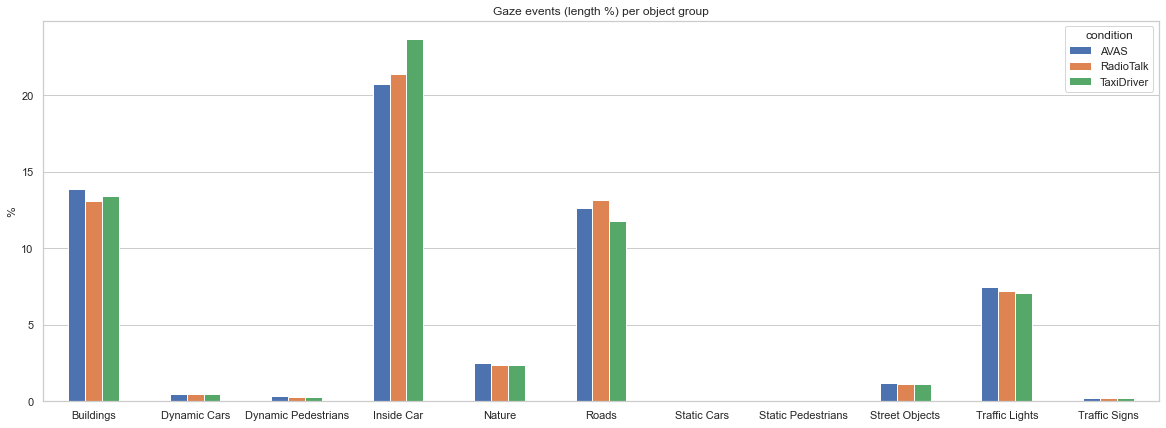

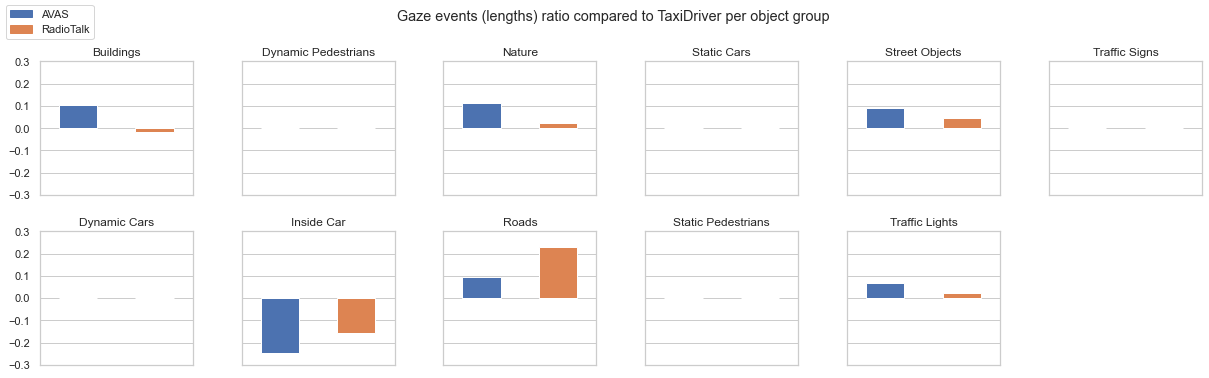

In [21]:
sns.set(rc={"figure.figsize": (20, 7)})
sns.set_style(STYLE)  # set seaborn plotting style

ax = hit_levs.groupby(["condition"]).mean().transpose().plot.bar(rot=0)

ax.set_ylabel("%")
ax.xaxis.grid(False)

plt.title("Gaze events (length %) per object group")

plt.show()

NROWS = 2
NCOLS = 6

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 5.5))
fig.suptitle(
    "Gaze events (lengths) ratio compared to TaxiDriver per object group\n"
)
fig.tight_layout()

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 11:
            grp = grp_cats[i]
            s = normalize_from_condition(
                hit_levs.groupby(["condition"])[grp].median()
            )
            ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
            i += 1
            if c != 0:
                ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(grp)
            ax.set_ylim(-0.3, 0.3)
            ax.set_xticks([])

fig.delaxes(axes[1, 5])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="upper left")
plt.show()

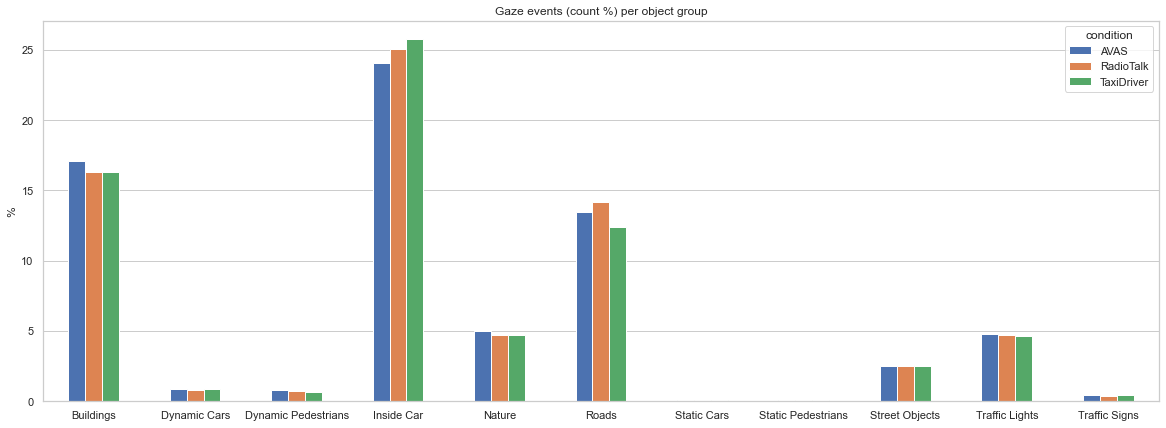

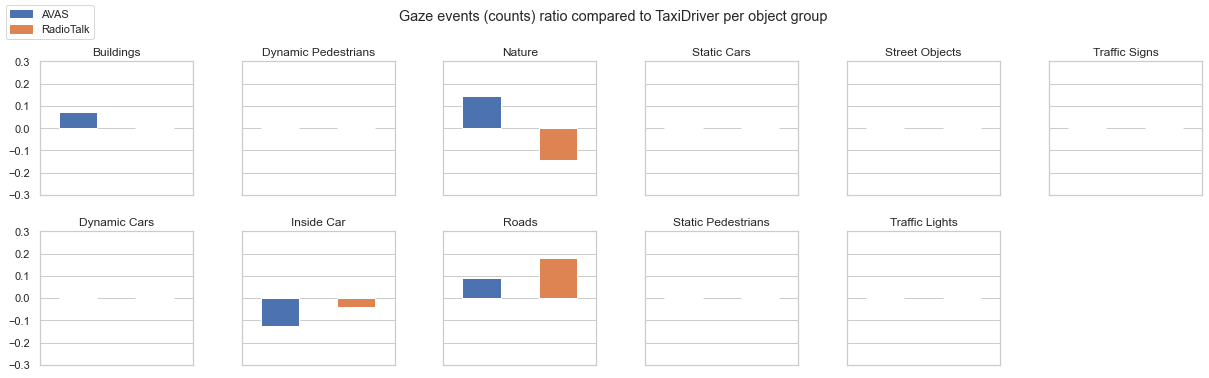

In [22]:
sns.set(rc={"figure.figsize": (20, 7)})
sns.set_style(STYLE)  # set seaborn plotting style

ax = hit_cevs.groupby(["condition"]).mean().transpose().plot.bar(rot=0)

ax.set_ylabel("%")
ax.xaxis.grid(False)

plt.title("Gaze events (count %) per object group")

plt.show()

NROWS = 2
NCOLS = 6

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 5.5))
fig.suptitle(
    "Gaze events (counts) ratio compared to TaxiDriver per object group\n"
)
fig.tight_layout()

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 11:
            grp = grp_cats[i]
            s = normalize_from_condition(
                hit_cevs.groupby(["condition"])[grp].median()
            )
            ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
            i += 1
            if c != 0:
                ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(grp)
            ax.set_ylim(-0.3, 0.3)
            ax.set_xticks([])

fig.delaxes(axes[1, 5])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="upper left")
plt.show()

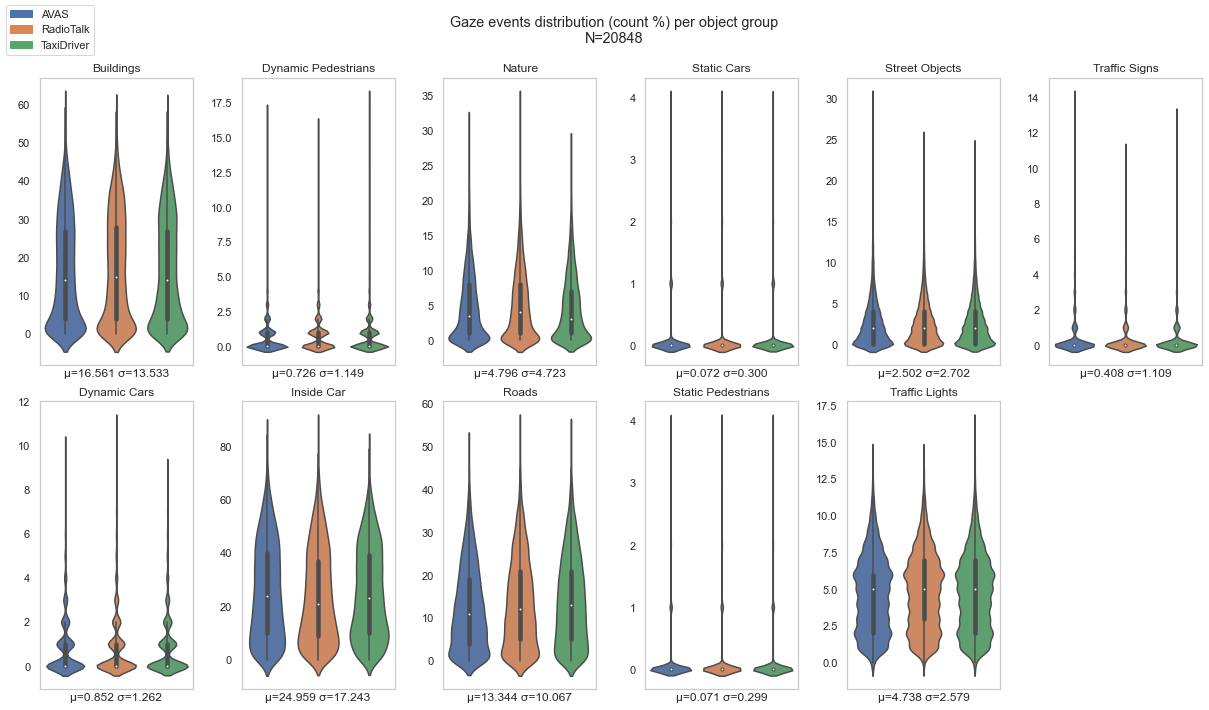

In [23]:
NROWS = 2
NCOLS = 6
N = hit_cevs.index.size

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 10))
fig.suptitle(f"Gaze events distribution (count %) per object group\nN={N}\n")
fig.tight_layout()

# h_cs = hit_cevs.groupby(["condition"])

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 11:
            grp = grp_cats[i]
            mean = hit_cevs[grp].mean()
            std = hit_cevs[grp].std()
            title_extra = f"μ={mean:.3f} σ={std:.3f}"
            # s = normalize_series(hit_cevs[grp])
            ax = sns.violinplot(
                data=hit_cevs, x="condition", y=grp, ax=axes[r, c]
            )
            i += 1
            # if c != 0:
            #     ax.set_yticklabels([])
            ax.set_ylabel(None)
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(f"{grp}")
            ax.set_xlabel(title_extra)
            # ax.set_ylim(-10, 110)
            ax.set_xticks([])
            ax.grid(False)

fig.delaxes(axes[1, 5])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
taxi_patch = mpatches.Patch(color=colors[2], label="TaxiDriver")
fig.legend(handles=[avas_patch, radio_patch, taxi_patch], loc="upper left")
plt.show()

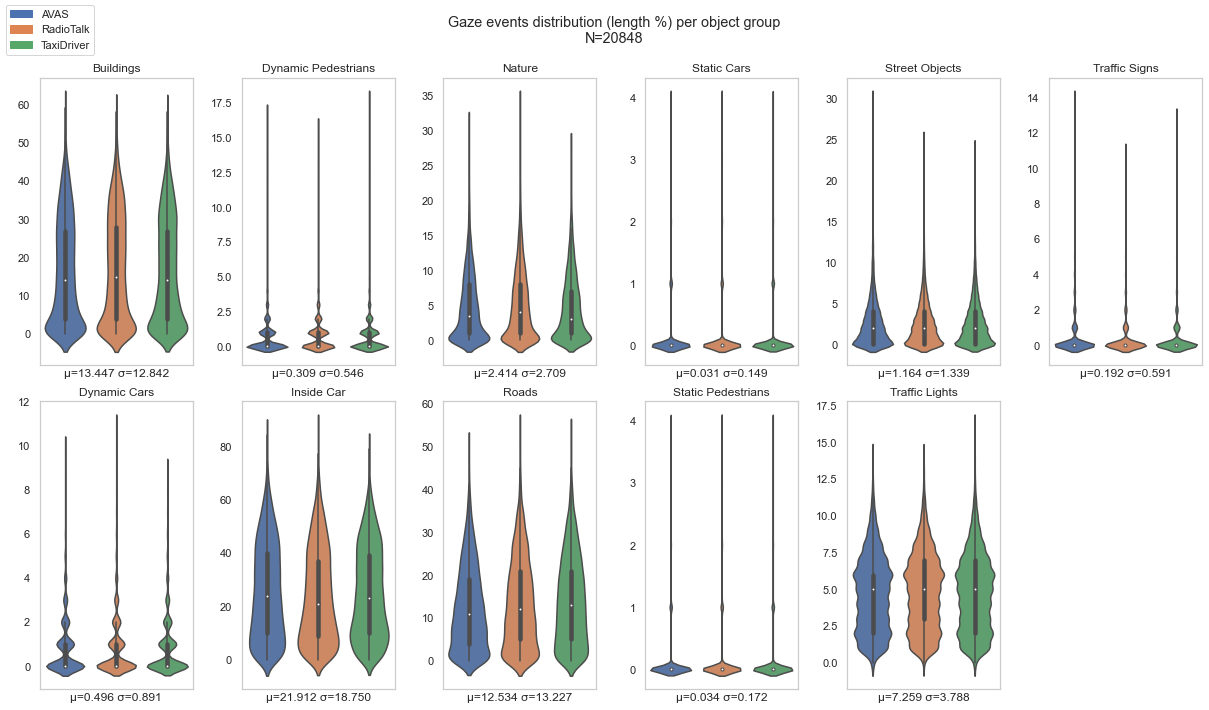

In [24]:
NROWS = 2
NCOLS = 6
N = hit_levs.index.size

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 10))
fig.suptitle(f"Gaze events distribution (length %) per object group\nN={N}\n")
fig.tight_layout()

# h_cs = hit_cevs.groupby(["condition"])

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 11:
            grp = grp_cats[i]
            mean = hit_levs[grp].mean()
            std = hit_levs[grp].std()
            title_extra = f"μ={mean:.3f} σ={std:.3f}"
            # s = normalize_series(hit_cevs[grp])
            ax = sns.violinplot(
                data=hit_cevs, x="condition", y=grp, ax=axes[r, c]
            )
            i += 1
            # if c != 0:
            #     ax.set_yticklabels([])
            ax.set_ylabel(None)
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(f"{grp}")
            ax.set_xlabel(title_extra)
            # ax.set_ylim(-10, 110)
            ax.set_xticks([])
            ax.grid(False)

fig.delaxes(axes[1, 5])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
taxi_patch = mpatches.Patch(color=colors[2], label="TaxiDriver")
fig.legend(handles=[avas_patch, radio_patch, taxi_patch], loc="upper left")
plt.show()

In [25]:
hit_cevs.sum(axis=1)

4f583872ffed48249874b00f3d389cfc    67
33d68ad55ef544fab9fd08108e3913ca    80
37d7e67934974217830bb429bba7fd76    69
9cdd85098b0b4ad5ab2282a5ac371a5e    64
ff846d92c7e6471183595bd2678f29f6    56
                                    ..
dba04b626e4c4c6e89aea4fb1f9cc32b    68
611d35a7c3e940cc82495e53c2a8532d    56
3b6fda285d9e412eb081986b2f22a2e3    85
18ffb0abdc8642098c479380bfa533d1    77
c06f123b35b74bb489ec239b1cac9eb4    84
Length: 20848, dtype: int64

In [26]:
hit_levs.sum(axis=1)

4f583872ffed48249874b00f3d389cfc   58.707
33d68ad55ef544fab9fd08108e3913ca   64.911
37d7e67934974217830bb429bba7fd76   52.899
9cdd85098b0b4ad5ab2282a5ac371a5e   63.921
ff846d92c7e6471183595bd2678f29f6   59.961
                                    ...  
dba04b626e4c4c6e89aea4fb1f9cc32b   67.518
611d35a7c3e940cc82495e53c2a8532d   61.446
3b6fda285d9e412eb081986b2f22a2e3   56.496
18ffb0abdc8642098c479380bfa533d1   45.342
c06f123b35b74bb489ec239b1cac9eb4   59.631
Length: 20848, dtype: float64

Final Groups

In [27]:
final_groups = ["Buildings", "Inside Car", "Nature", "condition"]
# length
gaze_levs = hit_levs[final_groups]
gaze_levs["Cars and Pedestrians"] = (
    hit_levs["Dynamic Cars"] + hit_levs["Dynamic Pedestrians"]
)
gaze_levs["Roads"] = hit_levs["Static Cars"] + hit_levs["Roads"]
gaze_levs["Street Objects"] = (
    hit_levs["Street Objects"] + hit_levs["Static Pedestrians"]
)
gaze_levs["Traffic Signs"] = (
    hit_levs["Traffic Signs"] + hit_levs["Traffic Lights"]
)

# count
gaze_cevs = hit_cevs[final_groups]
gaze_cevs["Cars and Pedestrians"] = (
    hit_cevs["Dynamic Cars"] + hit_cevs["Dynamic Pedestrians"]
)
gaze_cevs["Roads"] = hit_cevs["Static Cars"] + hit_cevs["Roads"]
gaze_cevs["Street Objects"] = (
    hit_cevs["Street Objects"] + hit_cevs["Static Pedestrians"]
)
gaze_cevs["Traffic Signs"] = (
    hit_cevs["Traffic Signs"] + hit_cevs["Traffic Lights"]
)

# TR vs non-TR
gaze_ltr = pd.DataFrame(columns=["TR", "non-TR"])
gaze_ltr["TR"] = (
    gaze_levs["Cars and Pedestrians"]
    + gaze_levs["Roads"]
    + gaze_levs["Traffic Signs"]
)
gaze_ltr["non-TR"] = (
    gaze_levs["Buildings"] + gaze_levs["Nature"] + gaze_levs["Street Objects"]
)
gaze_ltr["condition"] = gaze_levs["condition"]
gaze_ctr = pd.DataFrame(columns=["TR", "non-TR"])
gaze_ctr["TR"] = (
    gaze_cevs["Cars and Pedestrians"]
    + gaze_cevs["Roads"]
    + gaze_cevs["Traffic Signs"]
)
gaze_ctr["non-TR"] = (
    gaze_cevs["Buildings"] + gaze_cevs["Nature"] + gaze_cevs["Street Objects"]
)
gaze_ctr["condition"] = gaze_cevs["condition"]

In [28]:
gaze_levs.sum(axis=1)

4f583872ffed48249874b00f3d389cfc   58.707
33d68ad55ef544fab9fd08108e3913ca   64.911
37d7e67934974217830bb429bba7fd76   52.899
9cdd85098b0b4ad5ab2282a5ac371a5e   63.921
ff846d92c7e6471183595bd2678f29f6   59.961
                                    ...  
dba04b626e4c4c6e89aea4fb1f9cc32b   67.518
611d35a7c3e940cc82495e53c2a8532d   61.446
3b6fda285d9e412eb081986b2f22a2e3   56.496
18ffb0abdc8642098c479380bfa533d1   45.342
c06f123b35b74bb489ec239b1cac9eb4   59.631
Length: 20848, dtype: float64

In [29]:
gaze_cevs.sum(axis=1)

4f583872ffed48249874b00f3d389cfc    67
33d68ad55ef544fab9fd08108e3913ca    80
37d7e67934974217830bb429bba7fd76    69
9cdd85098b0b4ad5ab2282a5ac371a5e    64
ff846d92c7e6471183595bd2678f29f6    56
                                    ..
dba04b626e4c4c6e89aea4fb1f9cc32b    68
611d35a7c3e940cc82495e53c2a8532d    56
3b6fda285d9e412eb081986b2f22a2e3    85
18ffb0abdc8642098c479380bfa533d1    77
c06f123b35b74bb489ec239b1cac9eb4    84
Length: 20848, dtype: int64

In [30]:
gaze_ltr.sum(axis=1)

4f583872ffed48249874b00f3d389cfc   56.826
33d68ad55ef544fab9fd08108e3913ca   36.234
37d7e67934974217830bb429bba7fd76   48.180
9cdd85098b0b4ad5ab2282a5ac371a5e   59.070
ff846d92c7e6471183595bd2678f29f6   58.971
                                    ...  
dba04b626e4c4c6e89aea4fb1f9cc32b   67.518
611d35a7c3e940cc82495e53c2a8532d   37.158
3b6fda285d9e412eb081986b2f22a2e3   38.115
18ffb0abdc8642098c479380bfa533d1   39.864
c06f123b35b74bb489ec239b1cac9eb4   24.519
Length: 20848, dtype: float64

In [31]:
gaze_ctr.sum(axis=1)

4f583872ffed48249874b00f3d389cfc    64
33d68ad55ef544fab9fd08108e3913ca    38
37d7e67934974217830bb429bba7fd76    59
9cdd85098b0b4ad5ab2282a5ac371a5e    60
ff846d92c7e6471183595bd2678f29f6    54
                                    ..
dba04b626e4c4c6e89aea4fb1f9cc32b    68
611d35a7c3e940cc82495e53c2a8532d    38
3b6fda285d9e412eb081986b2f22a2e3    59
18ffb0abdc8642098c479380bfa533d1    64
c06f123b35b74bb489ec239b1cac9eb4    36
Length: 20848, dtype: int64

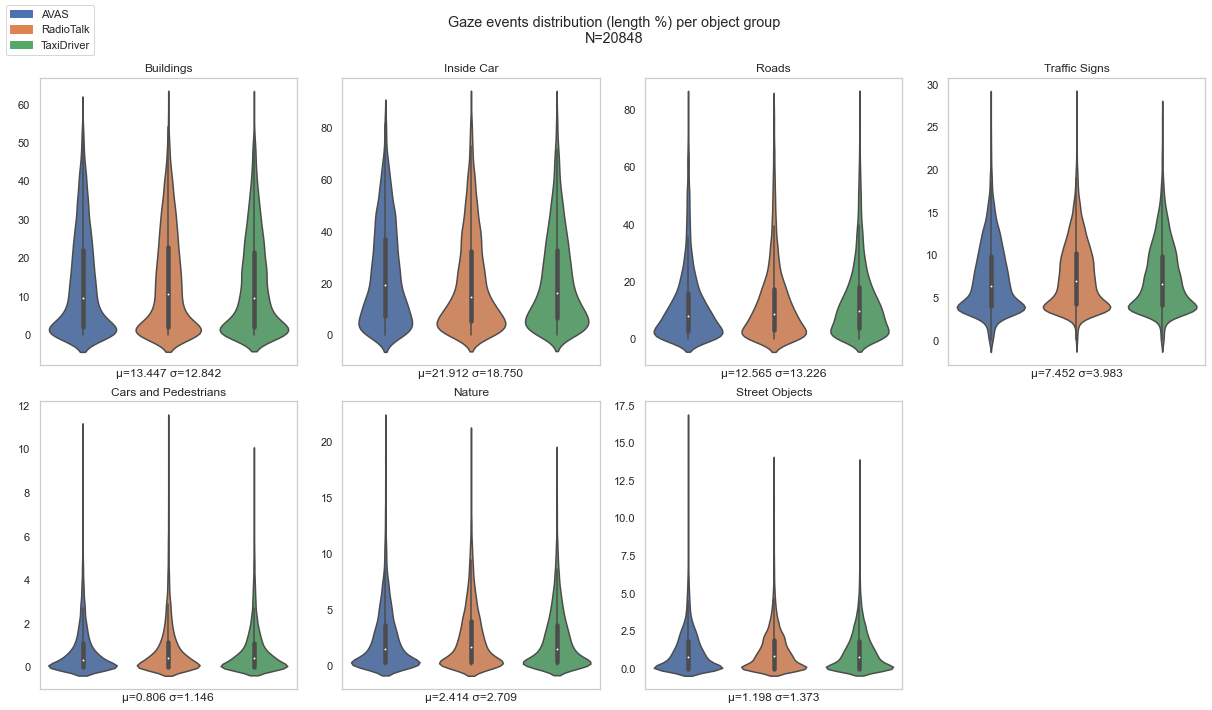

In [32]:
NROWS = 2
NCOLS = 4
N = gaze_levs.index.size

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 10))
fig.suptitle(f"Gaze events distribution (length %) per object group\nN={N}\n")
fig.tight_layout()

# h_cs = hit_cevs.groupby(["condition"])
grp_cats = gaze_levs[
    gaze_levs.columns.difference(["condition"])
].columns.tolist()

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 7:
            grp = grp_cats[i]
            mean = gaze_levs[grp].mean()
            std = gaze_levs[grp].std()
            title_extra = f"μ={mean:.3f} σ={std:.3f}"
            # s = normalize_series(hit_cevs[grp])
            ax = sns.violinplot(
                data=gaze_levs, x="condition", y=grp, ax=axes[r, c]
            )
            i += 1
            # if c != 0:
            #     ax.set_yticklabels([])
            ax.set_ylabel(None)
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(f"{grp}")
            ax.set_xlabel(title_extra)
            # ax.set_ylim(-10, 110)
            ax.set_xticks([])
            ax.grid(False)

fig.delaxes(axes[1, 3])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
taxi_patch = mpatches.Patch(color=colors[2], label="TaxiDriver")
fig.legend(handles=[avas_patch, radio_patch, taxi_patch], loc="upper left")
plt.show()

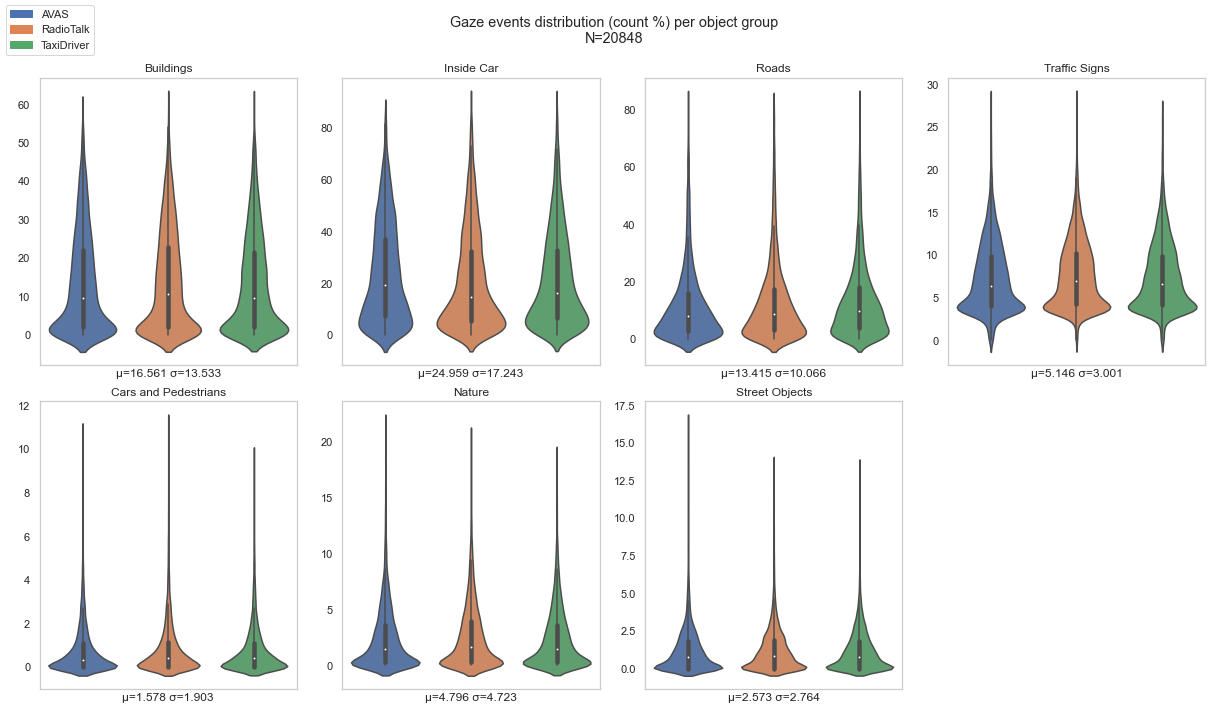

In [33]:
NROWS = 2
NCOLS = 4
N = gaze_cevs.index.size

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 10))
fig.suptitle(f"Gaze events distribution (count %) per object group\nN={N}\n")
fig.tight_layout()

# h_cs = hit_cevs.groupby(["condition"])
grp_cats = gaze_cevs[
    gaze_cevs.columns.difference(["condition"])
].columns.tolist()

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 7:
            grp = grp_cats[i]
            mean = gaze_cevs[grp].mean()
            std = gaze_cevs[grp].std()
            title_extra = f"μ={mean:.3f} σ={std:.3f}"
            # s = normalize_series(hit_cevs[grp])
            ax = sns.violinplot(
                data=gaze_levs, x="condition", y=grp, ax=axes[r, c]
            )
            i += 1
            # if c != 0:
            #     ax.set_yticklabels([])
            ax.set_ylabel(None)
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(f"{grp}")
            ax.set_xlabel(title_extra)
            # ax.set_ylim(-10, 110)
            ax.set_xticks([])
            ax.grid(False)

fig.delaxes(axes[1, 3])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
taxi_patch = mpatches.Patch(color=colors[2], label="TaxiDriver")
fig.legend(handles=[avas_patch, radio_patch, taxi_patch], loc="upper left")
plt.show()

In [34]:
gaze_levs.describe()

Buildings  Inside Car    Nature  Cars and Pedestrians     Roads  \
count  20848.000   20848.000 20848.000             20848.000 20848.000   
mean      13.447      21.912     2.414                 0.806    12.565   
std       12.842      18.750     2.709                 1.146    13.226   
min        0.000       0.000     0.000                 0.000     0.000   
25%        1.980       6.336     0.264                 0.000     3.102   
50%        9.933      16.566     1.518                 0.396     8.712   
75%       22.077      34.221     3.729                 1.122    17.226   
max       59.136      88.143    21.549                11.187    82.071   

       Street Objects  Traffic Signs  
count       20848.000      20848.000  
mean            1.198          7.452  
std             1.373          3.983  
min             0.000          0.000  
25%             0.000          4.125  
50%             0.792          6.600  
75%             1.848          9.966  
max            16.401         27.918

In [35]:
gaze_cevs.describe()

Buildings  Inside Car    Nature  Cars and Pedestrians     Roads  \
count  20848.000   20848.000 20848.000             20848.000 20848.000   
mean      16.561      24.959     4.796                 1.578    13.415   
std       13.533      17.243     4.723                 1.903    10.066   
min        0.000       0.000     0.000                 0.000     0.000   
25%        4.000      10.000     1.000                 0.000     5.000   
50%       14.000      23.000     4.000                 1.000    12.000   
75%       28.000      39.000     8.000                 2.000    20.000   
max       59.000      86.000    34.000                19.000    54.000   

       Street Objects  Traffic Signs  
count       20848.000      20848.000  
mean            2.573          5.146  
std             2.764          3.001  
min             0.000          0.000  
25%             0.000          3.000  
50%             2.000          5.000  
75%             4.000          7.000  
max            31.000         22.000

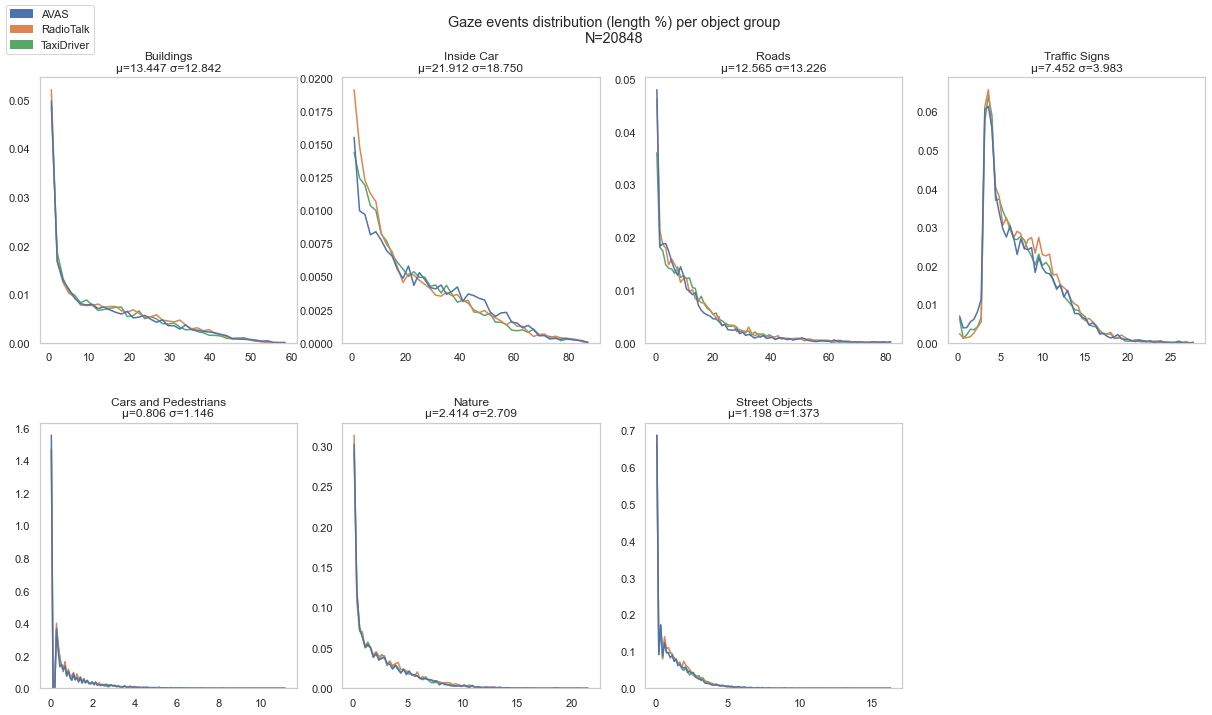

In [36]:
NROWS = 2
NCOLS = 4
N = gaze_levs.index.size

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 10))
fig.suptitle(f"Gaze events distribution (length %) per object group\nN={N}\n")
fig.tight_layout()

# h_cs = hit_cevs.groupby(["condition"])
grp_cats = gaze_levs[
    gaze_levs.columns.difference(["condition"])
].columns.tolist()

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 7:
            grp = grp_cats[i]
            mean = gaze_levs[grp].mean()
            std = gaze_levs[grp].std()
            title_extra = f"μ={mean:.3f} σ={std:.3f}"
            # s = normalize_series(hit_cevs[grp])
            ax = sns.histplot(
                data=gaze_levs,
                hue="condition",
                x=grp,
                # kde=True,
                # multiple="stack",
                element="poly",
                fill=False,
                ax=axes[r, c],
                legend=False,
                stat="density",
            )
            i += 1
            # if c != 0:
            #     ax.set_yticklabels([])
            ax.set_ylabel(None)
            # ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(f"{grp}\n{title_extra}")
            # ax.set_xlim(0, 10)
            # ax.set_xticks([])
            ax.grid(False)

fig.delaxes(axes[1, 3])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
taxi_patch = mpatches.Patch(color=colors[2], label="TaxiDriver")
fig.legend(handles=[avas_patch, radio_patch, taxi_patch], loc="upper left")
plt.subplots_adjust(hspace=0.3)
plt.show()

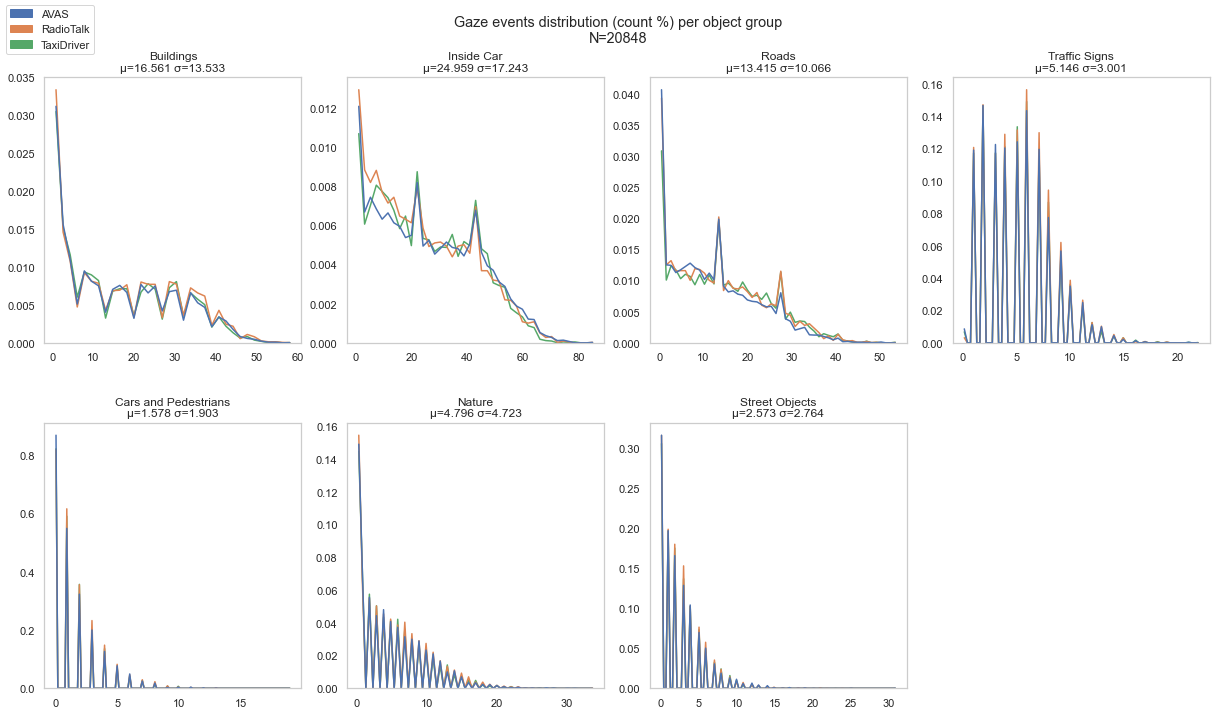

In [37]:
NROWS = 2
NCOLS = 4
N = gaze_cevs.index.size

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 10))
fig.suptitle(f"Gaze events distribution (count %) per object group\nN={N}\n")
fig.tight_layout()

# h_cs = hit_cevs.groupby(["condition"])
grp_cats = gaze_cevs[
    gaze_cevs.columns.difference(["condition"])
].columns.tolist()

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 7:
            grp = grp_cats[i]
            mean = gaze_cevs[grp].mean()
            std = gaze_cevs[grp].std()
            title_extra = f"μ={mean:.3f} σ={std:.3f}"
            # s = normalize_series(hit_cevs[grp])
            ax = sns.histplot(
                data=gaze_cevs,
                hue="condition",
                x=grp,
                # kde=True,
                # multiple="stack",
                element="poly",
                fill=False,
                ax=axes[r, c],
                legend=False,
                stat="density",
            )
            i += 1
            # if c != 0:
            #     ax.set_yticklabels([])
            ax.set_ylabel(None)
            # ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(f"{grp}\n{title_extra}")
            # ax.set_ylim(-10, 110)
            # ax.set_xticks([])
            ax.grid(False)

fig.delaxes(axes[1, 3])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
taxi_patch = mpatches.Patch(color=colors[2], label="TaxiDriver")
fig.legend(handles=[avas_patch, radio_patch, taxi_patch], loc="upper left")
plt.subplots_adjust(hspace=0.3)
plt.show()

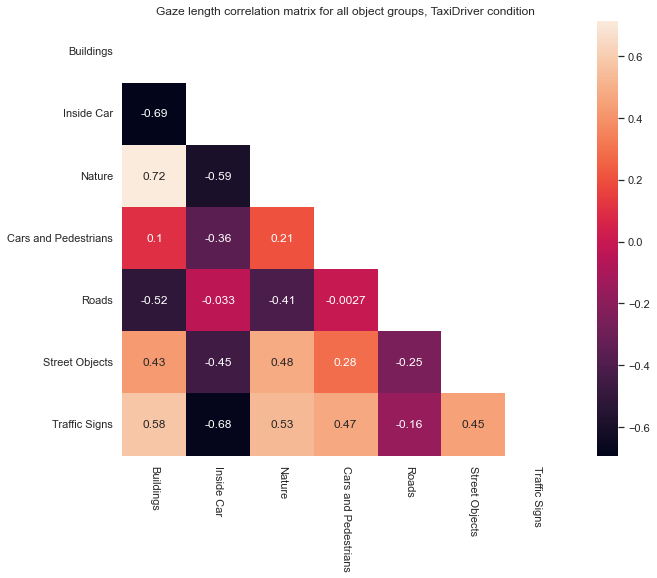

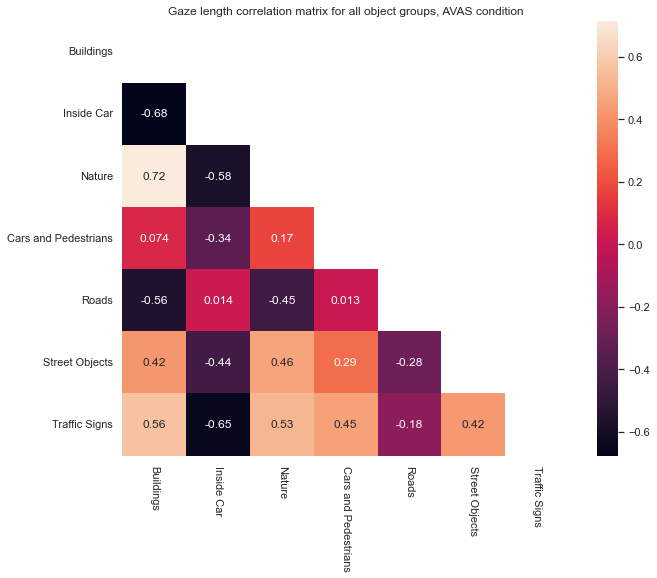

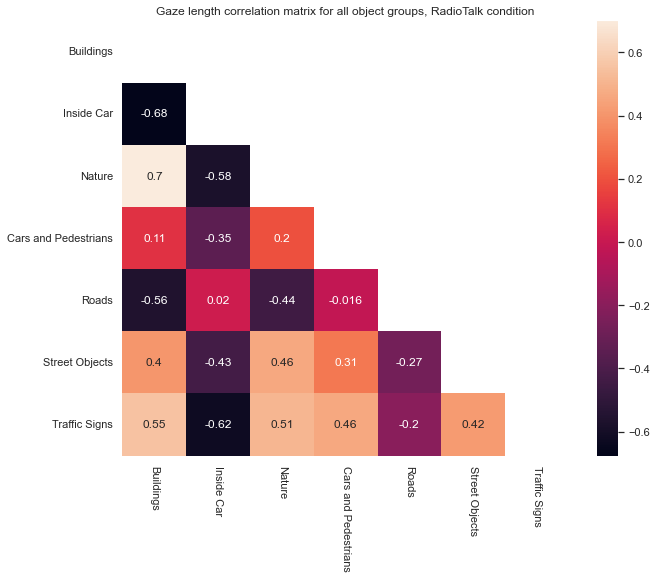

Gaze length variance for all object groups per condition


TaxiDriver    AVAS  RadioTalk
Buildings                168.453 168.840    157.013
Inside Car               366.503 350.785    332.804
Nature                     7.228   7.816      6.929
Cars and Pedestrians       1.308   1.383      1.241
Roads                    172.073 180.985    170.483
Street Objects             1.920   1.905      1.832
Traffic Signs             16.165  15.725     15.648

Normality (Gaussian distribution) test:


TaxiDriver  AVAS RadioTalk  TaxiDriver Normality  \
Buildings                 0.000 0.000     0.000                     ❌   
Inside Car                0.000 0.000     0.000                     ❌   
Nature                    0.000 0.000     0.000                     ❌   
Cars and Pedestrians      0.000 0.000     0.000                     ❌   
Roads                     0.000 0.000     0.000                     ❌   
Street Objects            0.000 0.000     0.000                     ❌   
Traffic Signs             0.000 0.000     0.000                     ❌   

                      AVAS Normality  RadioTalk Normality  
Buildings                          ❌                    ❌  
Inside Car                         ❌                    ❌  
Nature                             ❌                    ❌  
Cars and Pedestrians               ❌                    ❌  
Roads                              ❌                    ❌  
Street Objects                     ❌                    ❌  
Traffic Signs                      ❌                    ❌

Homoscedasticity (Homogeneity of variance) test:


p-value (Bartlett) Homoscedasticity
Buildings                          0.003                ❌
Inside Car                         0.000                ❌
Nature                             0.000                ❌
Cars and Pedestrians               0.000                ❌
Roads                              0.025                ❌
Street Objects                     0.115               ✔️
Traffic Signs                      0.348               ✔️

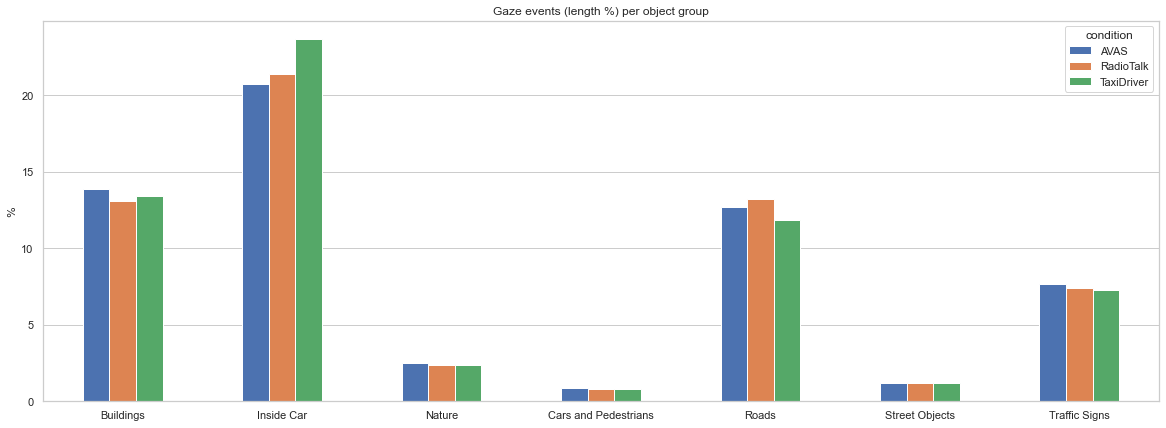

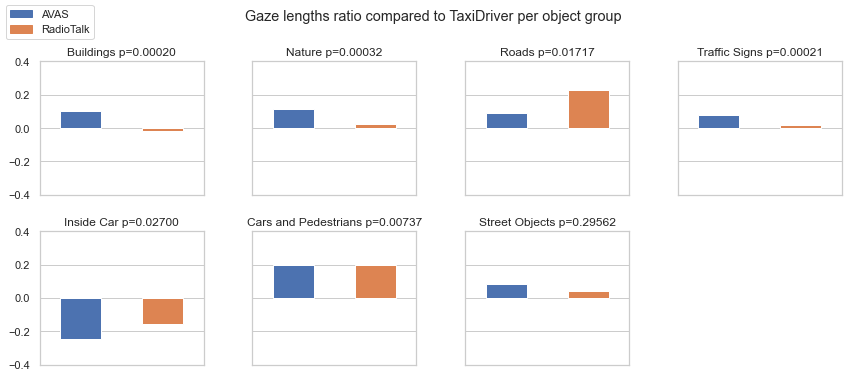

In [38]:
# collect conditions
conds = gaze_levs.condition.unique()

for cond in conds:
    # compute and display a correlation matrix between groups
    corr = gaze_levs[gaze_levs.condition == cond].corr(method="pearson")
    # display(corr)

    # generate a mask to drop the upper part of the matrix (duplicated info)
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # figure size
    plt.figure(figsize=(10, 8))

    # display the correlation matrix as a heatmap
    sns.heatmap(corr, annot=True, mask=mask)
    plt.xticks(rotation=-90)
    plt.title(
        f"Gaze length correlation matrix for all object groups, {cond} condition"
    )
    plt.show()

print("Gaze length variance for all object groups per condition")
cond_var = pd.DataFrame(columns=conds)
for cond in conds:
    cond_var[cond] = gaze_levs[gaze_levs.condition == cond].var()
display(cond_var)
# collect and display the variance of each group between conditions
groups = gaze_levs.drop("condition", axis=1).columns
shapiro = pd.DataFrame(columns=conds)
bartlett = pd.DataFrame(columns=["p-value (Bartlett)"])
for grp in groups:
    for cnd in conds:
        shapiro.loc[grp, cnd] = stats.shapiro(
            gaze_levs[gaze_levs.condition == cond][grp]
        )[1]
    bartlett.loc[grp] = stats.bartlett(
        gaze_levs[gaze_levs.condition == "AVAS"][grp],
        gaze_levs[gaze_levs.condition == "TaxiDriver"][grp],
        gaze_levs[gaze_levs.condition == "RadioTalk"][grp],
    )[1]

print("Normality (Gaussian distribution) test:")
for cnd in conds:
    check = shapiro[cnd] > 0.05
    check = ["✔️" if c == True else "❌" for c in check]
    shapiro[f" {cnd} Normality"] = check
display(shapiro)

print("Homoscedasticity (Homogeneity of variance) test:")
check = bartlett["p-value (Bartlett)"] > 0.05
check = ["✔️" if c == True else "❌" for c in check]
bartlett["Homoscedasticity"] = check
display(bartlett)


sns.set(rc={"figure.figsize": (20, 7)})
sns.set_style(STYLE)  # set seaborn plotting style

ax = gaze_levs.groupby(["condition"]).mean().transpose().plot.bar(rot=0)

ax.set_ylabel("%")
ax.xaxis.grid(False)

plt.title("Gaze events (length %) per object group")

plt.show()


NROWS = 2
NCOLS = 4

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(12, 5.5))
fig.suptitle("Gaze lengths ratio compared to TaxiDriver per object group\n")
fig.tight_layout()

groups = gaze_levs.drop("condition", axis=1).columns

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 7:
            grp = groups[i]
            s = normalize_from_condition(
                gaze_levs.groupby(["condition"])[grp].median()
            )
            ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
            # calculate p-value using Welch's t-test (assuming different variance)
            avas = gaze_levs[gaze_levs.condition == "AVAS"][grp]
            radio = gaze_levs[gaze_levs.condition == "RadioTalk"][grp]
            taxi = gaze_levs[gaze_levs.condition == "TaxiDriver"][grp]
            t_test = stats.ttest_ind(avas, radio, equal_var=False)
            i += 1
            if c != 0:
                ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(f"{grp} p={t_test[1]:.5f}")
            ax.set_ylim(-0.4, 0.4)
            ax.set_xticks([])

fig.delaxes(axes[1, 3])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="upper left")
plt.show()

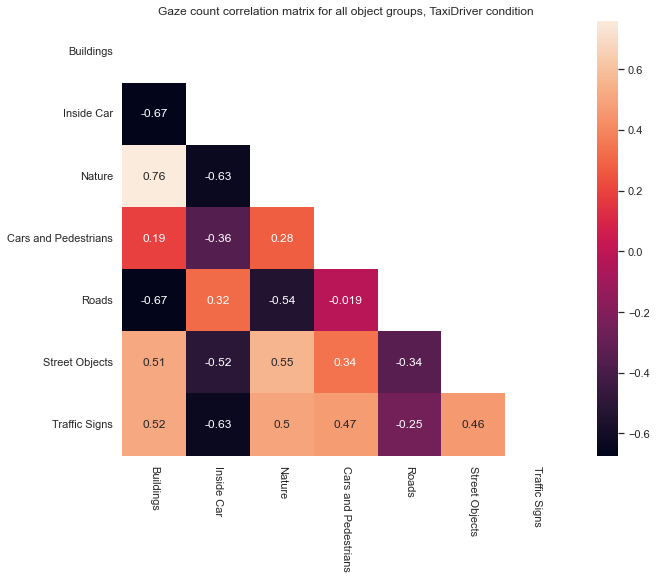

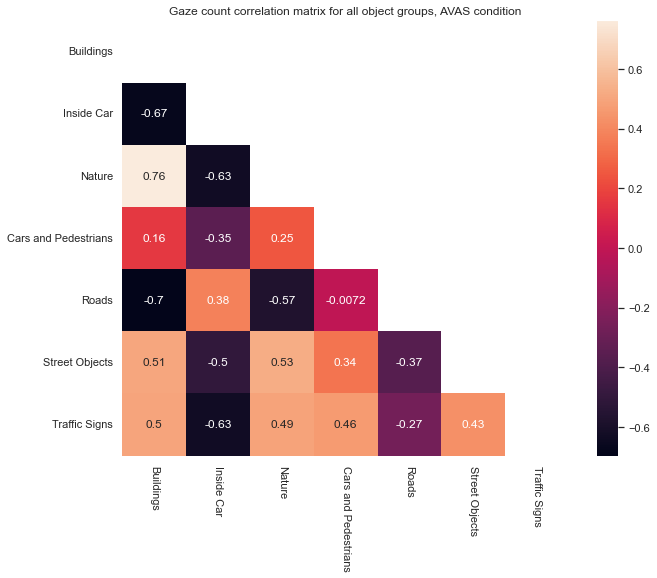

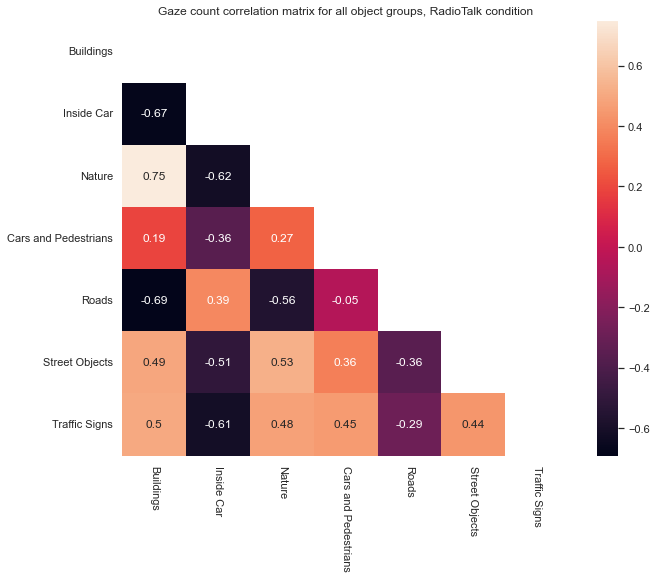

Gaze length variance for all object groups per condition


TaxiDriver    AVAS  RadioTalk
Buildings                181.218 189.878    177.668
Inside Car               312.450 296.708    281.574
Nature                    22.005  23.328     21.504
Cars and Pedestrians       3.628   3.764      3.460
Roads                     93.869 104.694    103.652
Street Objects             7.862   7.760      7.288
Traffic Signs              9.043   8.964      9.003

Normality (Gaussian distribution) test:


TaxiDriver  AVAS RadioTalk  TaxiDriver Normality  \
Buildings                 0.000 0.000     0.000                     ❌   
Inside Car                0.000 0.000     0.000                     ❌   
Nature                    0.000 0.000     0.000                     ❌   
Cars and Pedestrians      0.000 0.000     0.000                     ❌   
Roads                     0.000 0.000     0.000                     ❌   
Street Objects            0.000 0.000     0.000                     ❌   
Traffic Signs             0.000 0.000     0.000                     ❌   

                      AVAS Normality  RadioTalk Normality  
Buildings                          ❌                    ❌  
Inside Car                         ❌                    ❌  
Nature                             ❌                    ❌  
Cars and Pedestrians               ❌                    ❌  
Roads                              ❌                    ❌  
Street Objects                     ❌                    ❌  
Traffic Signs                      ❌                    ❌

Homoscedasticity (Homogeneity of variance) test:


p-value (Bartlett) Homoscedasticity
Buildings                          0.016                ❌
Inside Car                         0.000                ❌
Nature                             0.002                ❌
Cars and Pedestrians               0.002                ❌
Roads                              0.000                ❌
Street Objects                     0.004                ❌
Traffic Signs                      0.935               ✔️

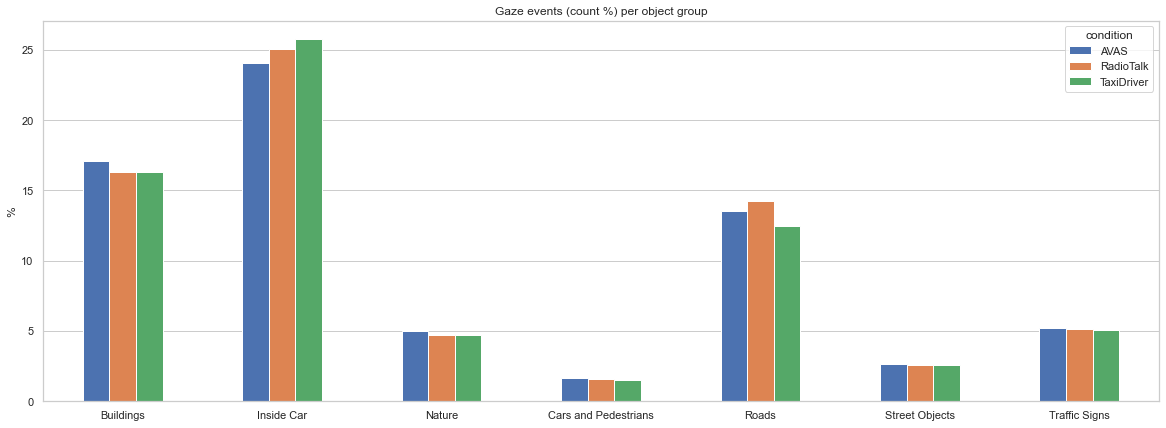

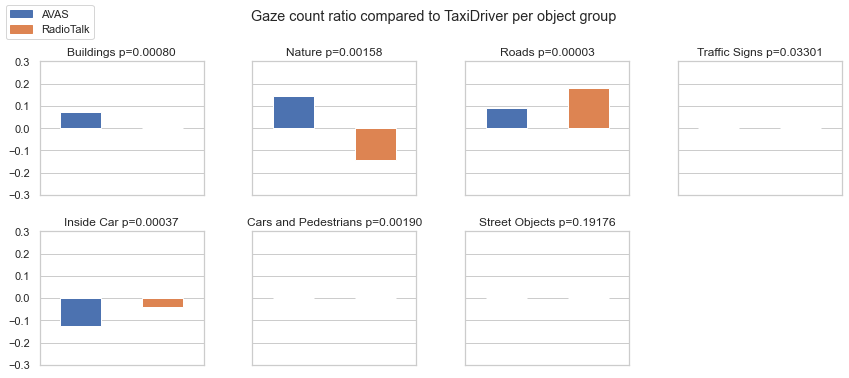

In [39]:
# collect conditions
conds = gaze_cevs.condition.unique()

for cond in conds:
    # compute and display a correlation matrix between groups
    corr = gaze_cevs[gaze_cevs.condition == cond].corr(method="pearson")
    # display(corr)

    # generate a mask to drop the upper part of the matrix (duplicated info)
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # figure size
    plt.figure(figsize=(10, 8))

    # display the correlation matrix as a heatmap
    sns.heatmap(corr, annot=True, mask=mask)
    plt.xticks(rotation=-90)
    plt.title(
        f"Gaze count correlation matrix for all object groups, {cond} condition"
    )
    plt.show()

print("Gaze length variance for all object groups per condition")
cond_var = pd.DataFrame(columns=conds)
for cond in conds:
    cond_var[cond] = gaze_cevs[gaze_cevs.condition == cond].var()
display(cond_var)
# collect and display the variance of each group between conditions
groups = gaze_cevs.drop("condition", axis=1).columns
shapiro = pd.DataFrame(columns=conds)
bartlett = pd.DataFrame(columns=["p-value (Bartlett)"])
for grp in groups:
    for cnd in conds:
        shapiro.loc[grp, cnd] = stats.shapiro(
            gaze_cevs[gaze_cevs.condition == cond][grp]
        )[1]
    bartlett.loc[grp] = stats.bartlett(
        gaze_cevs[gaze_cevs.condition == "AVAS"][grp],
        gaze_cevs[gaze_cevs.condition == "TaxiDriver"][grp],
        gaze_cevs[gaze_cevs.condition == "RadioTalk"][grp],
    )[1]

print("Normality (Gaussian distribution) test:")
for cnd in conds:
    check = shapiro[cnd] > 0.05
    check = ["✔️" if c == True else "❌" for c in check]
    shapiro[f" {cnd} Normality"] = check
display(shapiro)

print("Homoscedasticity (Homogeneity of variance) test:")
check = bartlett["p-value (Bartlett)"] > 0.05
check = ["✔️" if c == True else "❌" for c in check]
bartlett["Homoscedasticity"] = check
display(bartlett)

sns.set(rc={"figure.figsize": (20, 7)})
sns.set_style(STYLE)  # set seaborn plotting style

ax = gaze_cevs.groupby(["condition"]).mean().transpose().plot.bar(rot=0)

ax.set_ylabel("%")
ax.xaxis.grid(False)

plt.title("Gaze events (count %) per object group")

plt.show()


NROWS = 2
NCOLS = 4

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(12, 5.5))
fig.suptitle("Gaze count ratio compared to TaxiDriver per object group\n")
fig.tight_layout()

groups = gaze_cevs.drop("condition", axis=1).columns

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 7:
            grp = groups[i]
            s = normalize_from_condition(
                gaze_cevs.groupby(["condition"])[grp].median()
            )
            ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
            # calculate p-value using Welch's t-test (assuming different variance)
            avas = gaze_cevs[gaze_cevs.condition == "AVAS"][grp]
            radio = gaze_cevs[gaze_cevs.condition == "RadioTalk"][grp]
            taxi = gaze_cevs[gaze_cevs.condition == "TaxiDriver"][grp]
            t_test = stats.ttest_ind(avas, radio, equal_var=False)
            i += 1
            if c != 0:
                ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(f"{grp} p={t_test[1]:.5f}")
            ax.set_ylim(-0.3, 0.3)
            ax.set_xticks([])

fig.delaxes(axes[1, 3])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="upper left")
plt.show()

TR vs non-TR

Gaze length variance for all object groups per condition


TaxiDriver    AVAS  RadioTalk
TR         176.699 183.315    170.219
non-TR     246.517 249.207    228.978

Normality (Gaussian distribution) test:


TaxiDriver  AVAS RadioTalk  TaxiDriver Normality  AVAS Normality  \
TR          0.000 0.000     0.000                     ❌               ❌   
non-TR      0.000 0.000     0.000                     ❌               ❌   

        RadioTalk Normality  
TR                        ❌  
non-TR                    ❌

Homoscedasticity (Homogeneity of variance) test:


p-value (Bartlett) Homoscedasticity
TR                   0.008                ❌
non-TR               0.001                ❌

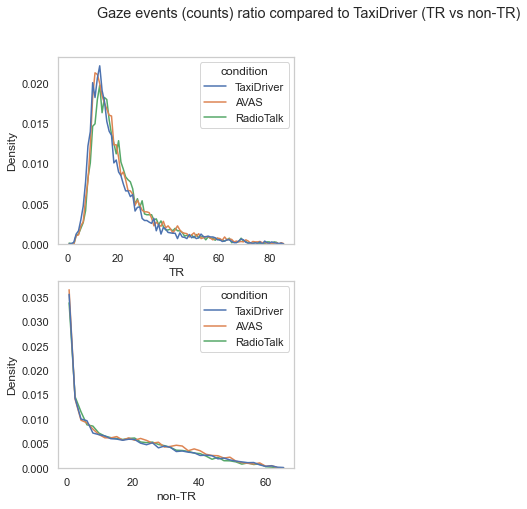

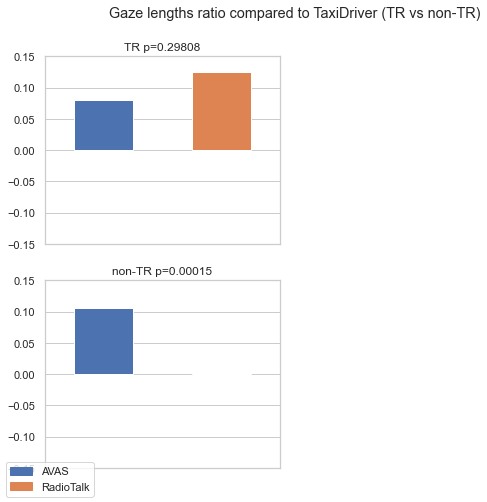

In [40]:
print("Gaze length variance for all object groups per condition")
cond_var = pd.DataFrame(columns=conds)
for cond in conds:
    cond_var[cond] = gaze_ltr[gaze_ltr.condition == cond].var()
display(cond_var)
# collect and display the variance of each group between conditions
groups = gaze_ltr.drop("condition", axis=1).columns
shapiro = pd.DataFrame(columns=conds)
bartlett = pd.DataFrame(columns=["p-value (Bartlett)"])
for grp in groups:
    for cnd in conds:
        shapiro.loc[grp, cnd] = stats.shapiro(
            gaze_ltr[gaze_ltr.condition == cond][grp]
        )[1]
    bartlett.loc[grp] = stats.bartlett(
        gaze_ltr[gaze_ltr.condition == "AVAS"][grp],
        gaze_ltr[gaze_ltr.condition == "TaxiDriver"][grp],
        gaze_ltr[gaze_ltr.condition == "RadioTalk"][grp],
    )[1]

print("Normality (Gaussian distribution) test:")
for cnd in conds:
    check = shapiro[cnd] > 0.05
    check = ["✔️" if c == True else "❌" for c in check]
    shapiro[f" {cnd} Normality"] = check
display(shapiro)

print("Homoscedasticity (Homogeneity of variance) test:")
check = bartlett["p-value (Bartlett)"] > 0.05
check = ["✔️" if c == True else "❌" for c in check]
bartlett["Homoscedasticity"] = check
display(bartlett)

NROWS = 2
NCOLS = 2


fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(8, 7))
fig.suptitle(
    "Gaze events (counts) ratio compared to TaxiDriver (TR vs non-TR)\n"
)
fig.tight_layout()

groups = gaze_ltr.drop("condition", axis=1).columns

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if c < 1:
            # grp = grp_cats[i]
            # mean = gaze_ltr[grp].mean()
            # std = gaze_ltr[grp].std()
            # title_extra = f"μ={mean:.3f} σ={std:.3f}"
            # s = normalize_series(hit_cevs[grp])
            ax = sns.histplot(
                data=gaze_ltr,
                hue="condition",
                x=groups[i],
                # kde=True,
                # multiple="stack",
                element="poly",
                fill=False,
                ax=axes[r, c],
                legend=True,
                stat="density",
            )
            i += 1
            # if c != 0:
            #     ax.set_yticklabels([])
            # ax.set_ylabel(None)
            # ax.set_xticklabels([])
            # ax.set_xlabel(None)
            # ax.set_title(f"{grp}\n{title_extra}")
            # ax.set_ylim(-10, 110)
            # ax.set_xticks([])
            ax.grid(False)

fig.delaxes(axes[1, 1])
fig.delaxes(axes[0, 1])
# avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
# radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
# fig.legend(handles=[avas_patch, radio_patch], loc="lower left")
plt.show()


NROWS = 2
NCOLS = 2

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(8, 7))
fig.suptitle("Gaze lengths ratio compared to TaxiDriver (TR vs non-TR)\n")
fig.tight_layout()

groups = gaze_ltr.drop("condition", axis=1).columns

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if c < 1:
            grp = groups[i]
            s = normalize_from_condition(
                gaze_ltr.groupby(["condition"])[grp].median()
            )
            ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
            # calculate p-value using Welch's t-test (assuming different variance)
            avas = gaze_ltr[gaze_ltr.condition == "AVAS"][grp]
            radio = gaze_ltr[gaze_ltr.condition == "RadioTalk"][grp]
            taxi = gaze_ltr[gaze_ltr.condition == "TaxiDriver"][grp]
            t_test = stats.ttest_ind(avas, radio, equal_var=True)
            i += 1
            if c != 0:
                ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(f"{grp} p={t_test[1]:.5f}")
            ax.set_ylim(-0.15, 0.15)
            ax.set_xticks([])

fig.delaxes(axes[1, 1])
fig.delaxes(axes[0, 1])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="lower left")
plt.show()

Gaze length variance for all object groups per condition


TaxiDriver    AVAS  RadioTalk
TR          96.659 106.228    101.522
non-TR     360.062 375.536    347.656

Normality (Gaussian distribution) test:


TaxiDriver  AVAS RadioTalk  TaxiDriver Normality  AVAS Normality  \
TR          0.000 0.000     0.000                     ❌               ❌   
non-TR      0.000 0.000     0.000                     ❌               ❌   

        RadioTalk Normality  
TR                        ❌  
non-TR                    ❌

Homoscedasticity (Homogeneity of variance) test:


p-value (Bartlett) Homoscedasticity
TR                   0.000                ❌
non-TR               0.005                ❌

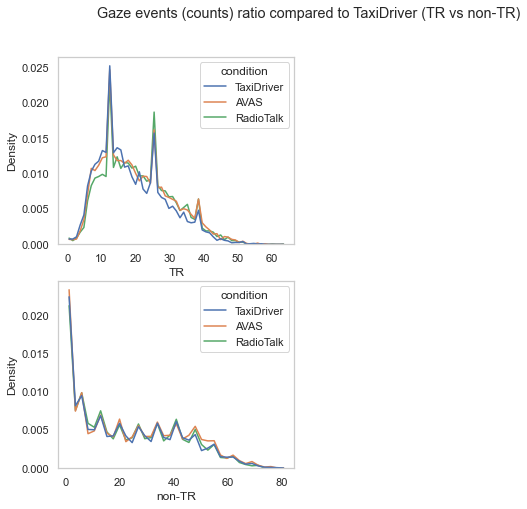

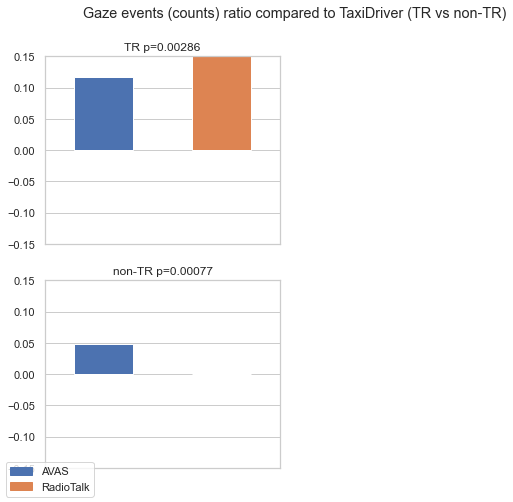

In [41]:
print("Gaze length variance for all object groups per condition")
cond_var = pd.DataFrame(columns=conds)
for cond in conds:
    cond_var[cond] = gaze_ctr[gaze_ctr.condition == cond].var()
display(cond_var)
# collect and display the variance of each group between conditions
groups = gaze_ctr.drop("condition", axis=1).columns
shapiro = pd.DataFrame(columns=conds)
bartlett = pd.DataFrame(columns=["p-value (Bartlett)"])
for grp in groups:
    for cnd in conds:
        shapiro.loc[grp, cnd] = stats.shapiro(
            gaze_ctr[gaze_ctr.condition == cond][grp]
        )[1]
    bartlett.loc[grp] = stats.bartlett(
        gaze_ctr[gaze_ctr.condition == "AVAS"][grp],
        gaze_ctr[gaze_ctr.condition == "TaxiDriver"][grp],
        gaze_ctr[gaze_ctr.condition == "RadioTalk"][grp],
    )[1]

print("Normality (Gaussian distribution) test:")
for cnd in conds:
    check = shapiro[cnd] > 0.05
    check = ["✔️" if c == True else "❌" for c in check]
    shapiro[f" {cnd} Normality"] = check
display(shapiro)

print("Homoscedasticity (Homogeneity of variance) test:")
check = bartlett["p-value (Bartlett)"] > 0.05
check = ["✔️" if c == True else "❌" for c in check]
bartlett["Homoscedasticity"] = check
display(bartlett)

NROWS = 2
NCOLS = 2


fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(8, 7))
fig.suptitle(
    "Gaze events (counts) ratio compared to TaxiDriver (TR vs non-TR)\n"
)
fig.tight_layout()

groups = gaze_ctr.drop("condition", axis=1).columns

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if c < 1:
            # grp = grp_cats[i]
            # mean = gaze_ltr[grp].mean()
            # std = gaze_ltr[grp].std()
            # title_extra = f"μ={mean:.3f} σ={std:.3f}"
            # s = normalize_series(hit_cevs[grp])
            ax = sns.histplot(
                data=gaze_ctr,
                hue="condition",
                x=groups[i],
                # kde=True,
                # multiple="stack",
                element="poly",
                fill=False,
                ax=axes[r, c],
                legend=True,
                stat="density",
            )
            i += 1
            # if c != 0:
            #     ax.set_yticklabels([])
            # ax.set_ylabel(None)
            # ax.set_xticklabels([])
            # ax.set_xlabel(None)
            # ax.set_title(f"{grp}\n{title_extra}")
            # ax.set_ylim(-10, 110)
            # ax.set_xticks([])
            ax.grid(False)

fig.delaxes(axes[1, 1])
fig.delaxes(axes[0, 1])
# avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
# radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
# fig.legend(handles=[avas_patch, radio_patch], loc="lower left")
plt.show()


NROWS = 2
NCOLS = 2

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(8, 7))
fig.suptitle(
    "Gaze events (counts) ratio compared to TaxiDriver (TR vs non-TR)\n"
)
fig.tight_layout()

groups = gaze_ctr.drop("condition", axis=1).columns

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if c < 1:
            grp = groups[i]
            s = normalize_from_condition(
                gaze_ctr.groupby(["condition"])[grp].median()
            )
            ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
            # calculate p-value using Welch's t-test (assuming different variance)
            avas = gaze_ctr[gaze_ctr.condition == "AVAS"][grp]
            radio = gaze_ctr[gaze_ctr.condition == "RadioTalk"][grp]
            taxi = gaze_ctr[gaze_ctr.condition == "TaxiDriver"][grp]
            t_test = stats.ttest_ind(avas, radio, equal_var=True)
            i += 1
            if c != 0:
                ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(f"{grp} p={t_test[1]:.5f}")
            ax.set_ylim(-0.15, 0.15)
            ax.set_xticks([])

fig.delaxes(axes[1, 1])
fig.delaxes(axes[0, 1])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="lower left")
plt.show()

In [42]:
parts

date  expo   side  \
id                                                                   
4f583872ffed48249874b00f3d389cfc  2019-05-14 13:21:00   MSW  right   
33d68ad55ef544fab9fd08108e3913ca  2019-05-14 16:44:00   MSW  right   
37d7e67934974217830bb429bba7fd76  2019-05-14 16:54:00   MSW   left   
9cdd85098b0b4ad5ab2282a5ac371a5e  2019-05-14 16:59:00   MSW  right   
ff846d92c7e6471183595bd2678f29f6  2019-05-14 17:37:00   MSW  right   
...                                               ...   ...    ...   
dba04b626e4c4c6e89aea4fb1f9cc32b  2019-12-30 13:48:00  BMBF   left   
611d35a7c3e940cc82495e53c2a8532d  2020-01-03 16:12:00  BMBF  right   
3b6fda285d9e412eb081986b2f22a2e3  2020-01-03 16:13:00  BMBF   left   
18ffb0abdc8642098c479380bfa533d1  2020-01-03 16:15:00  BMBF   left   
c06f123b35b74bb489ec239b1cac9eb4  2020-01-03 16:16:00  BMBF  right   

                                   condition  nulls_%  sky_%  insidecar_%  \
id                                                                          
4f583872ffed48249874b00f3d389cfc  TaxiDriver    1.610 13.740        2.359   
33d68ad55ef544fab9fd08108e3913ca        AVAS    0.037  0.674       25.421   
37d7e67934974217830bb429bba7fd76        AVAS    0.824 18.607        2.845   
9cdd85098b0b4ad5ab2282a5ac371a5e        AVAS    0.000 20.030        0.000   
ff846d92c7e6471183595bd2678f29f6        AVAS    0.037 15.575        1.235   
...                                      ...      ...    ...          ...   
dba04b626e4c4c6e89aea4fb1f9cc32b  TaxiDriver    0.000 22.501        0.000   
611d35a7c3e940cc82495e53c2a8532d  TaxiDriver    0.674 15.462        5.054   
3b6fda285d9e412eb081986b2f22a2e3        AVAS    1.797  3.370       11.718   
18ffb0abdc8642098c479380bfa533d1   RadioTalk    0.150 17.484        1.872   
c06f123b35b74bb489ec239b1cac9eb4  TaxiDriver    0.187  2.583       17.634   

                                 questionnaire  
id                                              
4f583872ffed48249874b00f3d389cfc            No  
33d68ad55ef544fab9fd08108e3913ca            No  
37d7e67934974217830bb429bba7fd76            No  
9cdd85098b0b4ad5ab2282a5ac371a5e            No  
ff846d92c7e6471183595bd2678f29f6            No  
...                                        ...  
dba04b626e4c4c6e89aea4fb1f9cc32b           Yes  
611d35a7c3e940cc82495e53c2a8532d            No  
3b6fda285d9e412eb081986b2f22a2e3            No  
18ffb0abdc8642098c479380bfa533d1           Yes  
c06f123b35b74bb489ec239b1cac9eb4            No  

[20848 rows x 8 columns]

In [43]:
parts[parts.questionnaire == "Yes"].index.size

8207

In [44]:
quests.index.size

8207

In [45]:
select = parts[parts.questionnaire == "Yes"]
gaze_ltr = gaze_ltr.join(parts[["expo", "side", "questionnaire"]], how="outer")
select = gaze_ltr[gaze_ltr.questionnaire == "Yes"]
cols = [
    "Intention",
    "Usefulness",
    "Ease",
    "Trust",
    "Gender",
    "Age",
    "Aviophobia",
    "Driving",
    "Play",
    "VR",
]
gaze_ltr = gaze_ltr.join(quests[cols], how="outer")

In [46]:
gaze_ltr = gaze_ltr[gaze_ltr.questionnaire == "Yes"]
gaze_ltr

TR  non-TR   condition  expo   side  \
000966a73bce402d8d92ece7eb13e1f7 16.962  14.850        AVAS  BMBF  right   
000ea0a15c0d476f89d084116e7b1e86 13.794   1.848        AVAS   MSW  right   
0015a3c9144248fb9571311e1140d7d0 27.423  25.278        AVAS   MSW  right   
001f482723604d929eff67b8e59f1db1 12.408  19.272   RadioTalk   MSW   left   
002063c0fd864a8c93fb114faee6417b 16.731   2.607  TaxiDriver   MSW   left   
...                                 ...     ...         ...   ...    ...   
ffe8b0db1e4640d695641d7b6bd2099d 15.114  47.091  TaxiDriver   MSW  right   
ffeaa9becd4f451389d253b8ac0ba1bc 11.484  39.996        AVAS   MSW   left   
fff21f23099e4e70b09ebc727e6365e5 19.833   0.000        AVAS   MSW   left   
fff77d4abc9b4937a78f5e4a8b9def12 63.954   0.000  TaxiDriver   MSW  right   
fffb6dd07f9c469aaf2fdb1272f154ec 21.054  18.216        AVAS   MSW  right   

                                 questionnaire  Intention  Usefulness    Ease  \
000966a73bce402d8d92ece7eb13e1f7           Yes     50.000      50.000  50.000   
000ea0a15c0d476f89d084116e7b1e86           Yes     88.000      56.000  25.000   
0015a3c9144248fb9571311e1140d7d0           Yes     71.000      50.000  83.000   
001f482723604d929eff67b8e59f1db1           Yes     37.000      39.000  45.000   
002063c0fd864a8c93fb114faee6417b           Yes     77.000     100.000 100.000   
...                                        ...        ...         ...     ...   
ffe8b0db1e4640d695641d7b6bd2099d           Yes    100.000     100.000 100.000   
ffeaa9becd4f451389d253b8ac0ba1bc           Yes     83.000       0.000  87.000   
fff21f23099e4e70b09ebc727e6365e5           Yes     50.000      50.000  56.000   
fff77d4abc9b4937a78f5e4a8b9def12           Yes     50.000      30.000 100.000   
fffb6dd07f9c469aaf2fdb1272f154ec           Yes     50.000      20.000  33.000   

                                   Trust  Gender    Age  Aviophobia  Driving  \
000966a73bce402d8d92ece7eb13e1f7  68.000  Female 15.000       0.000    0.000   
000ea0a15c0d476f89d084116e7b1e86 100.000    Male 12.000       0.000    0.000   
0015a3c9144248fb9571311e1140d7d0  50.000    Male 23.000       1.000    4.000   
001f482723604d929eff67b8e59f1db1 100.000     N/A 81.000       0.000    0.000   
002063c0fd864a8c93fb114faee6417b 100.000  Female 14.000       0.000    0.000   
...                                  ...     ...    ...         ...      ...   
ffe8b0db1e4640d695641d7b6bd2099d 100.000    Male 17.000       0.000    0.000   
ffeaa9becd4f451389d253b8ac0ba1bc  61.000  Female 12.000       0.000    0.000   
fff21f23099e4e70b09ebc727e6365e5  89.000    Male 19.000       0.000    0.000   
fff77d4abc9b4937a78f5e4a8b9def12  50.000    Male 46.000       0.000   27.000   
fffb6dd07f9c469aaf2fdb1272f154ec  36.000    Male 14.000       0.000    0.000   

                                   Play                  VR  
000966a73bce402d8d92ece7eb13e1f7  4.000                once  
000ea0a15c0d476f89d084116e7b1e86  9.000  less than 10 times  
0015a3c9144248fb9571311e1140d7d0  4.000  more than 10 times  
001f482723604d929eff67b8e59f1db1  5.000  less than 10 times  
002063c0fd864a8c93fb114faee6417b  1.000                once  
...                                 ...                 ...  
ffe8b0db1e4640d695641d7b6bd2099d 50.000  more than 10 times  
ffeaa9becd4f451389d253b8ac0ba1bc  2.000  less than 10 times  
fff21f23099e4e70b09ebc727e6365e5 30.000                once  
fff77d4abc9b4937a78f5e4a8b9def12  0.000  less than 10 times  
fffb6dd07f9c469aaf2fdb1272f154ec 15.000  less than 10 times  

[8207 rows x 16 columns]

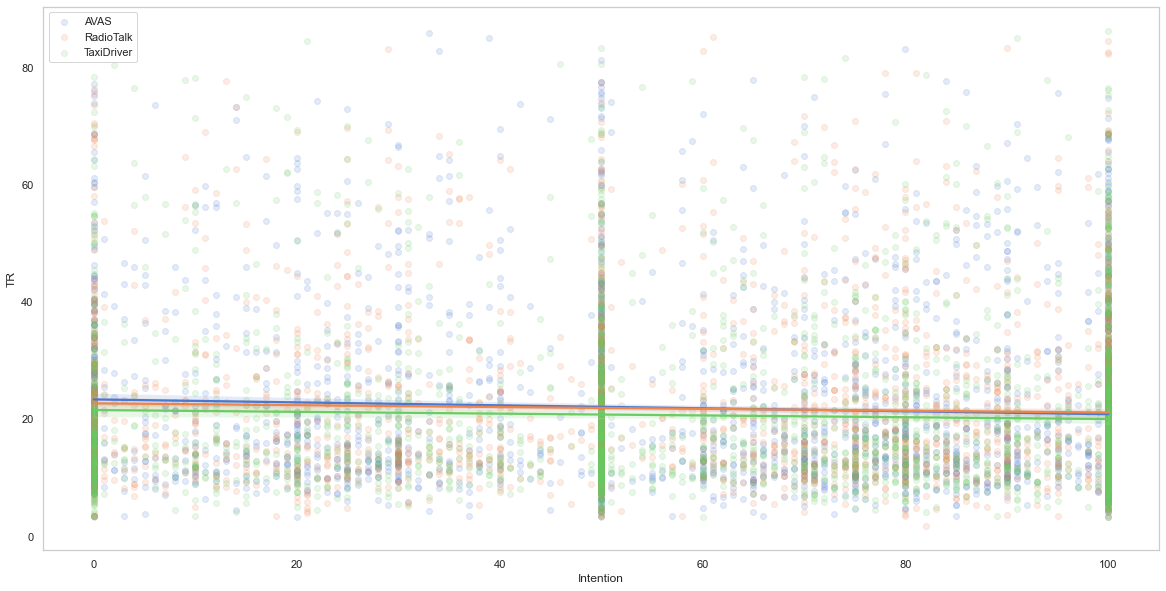

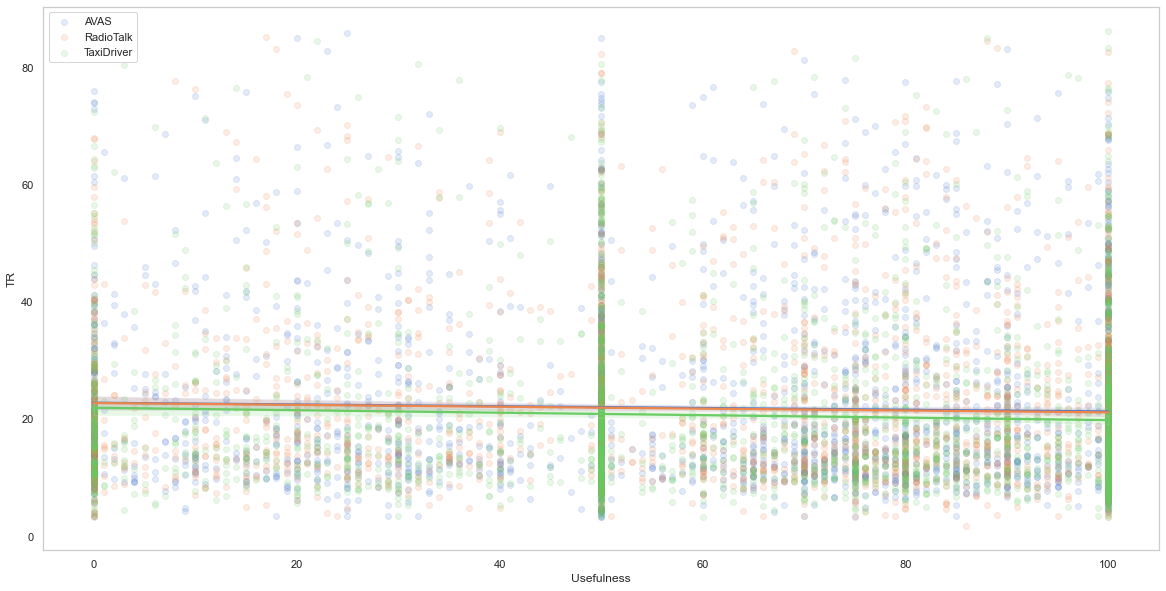

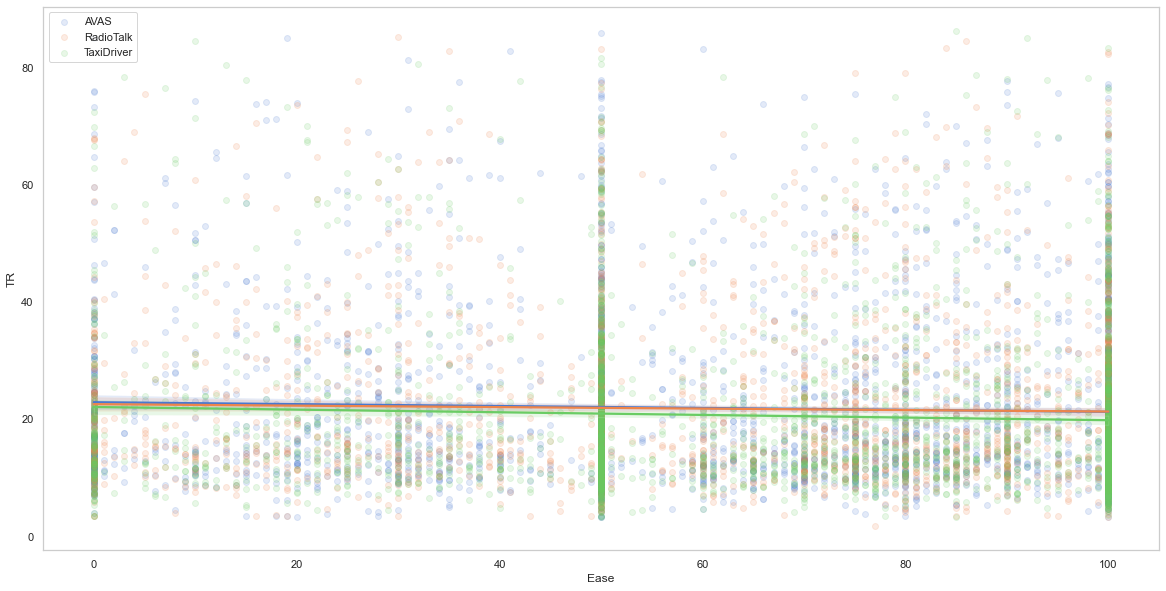

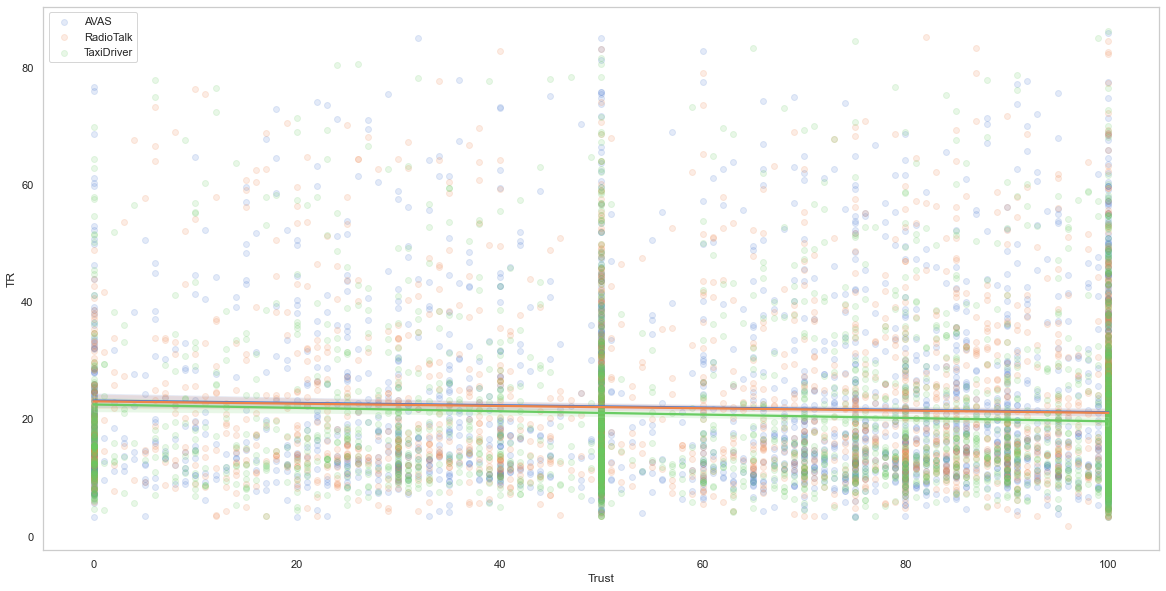

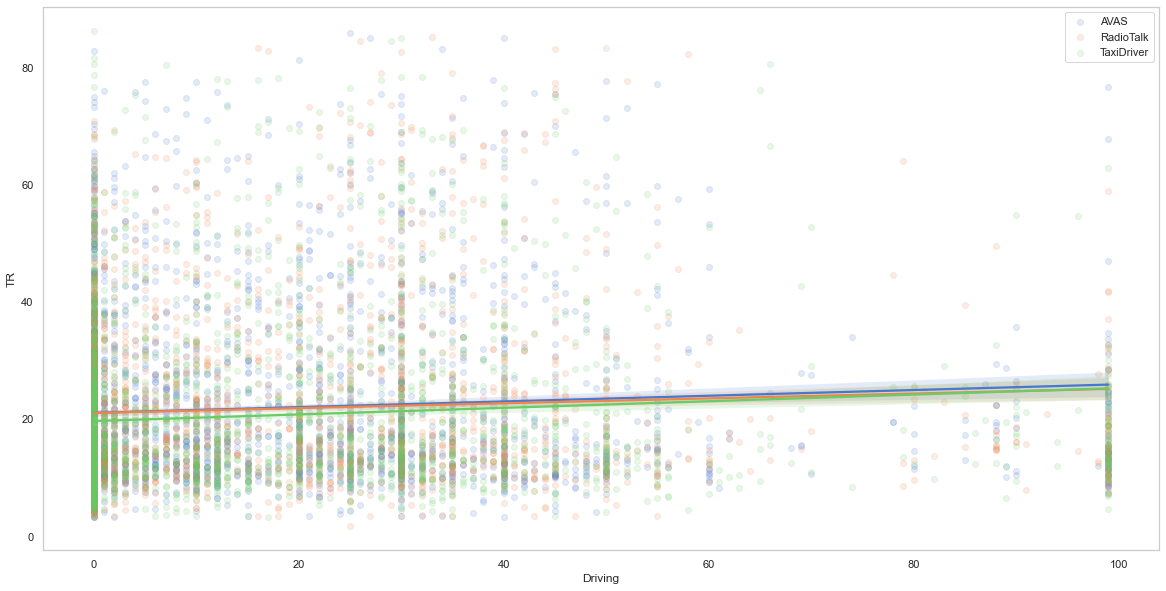

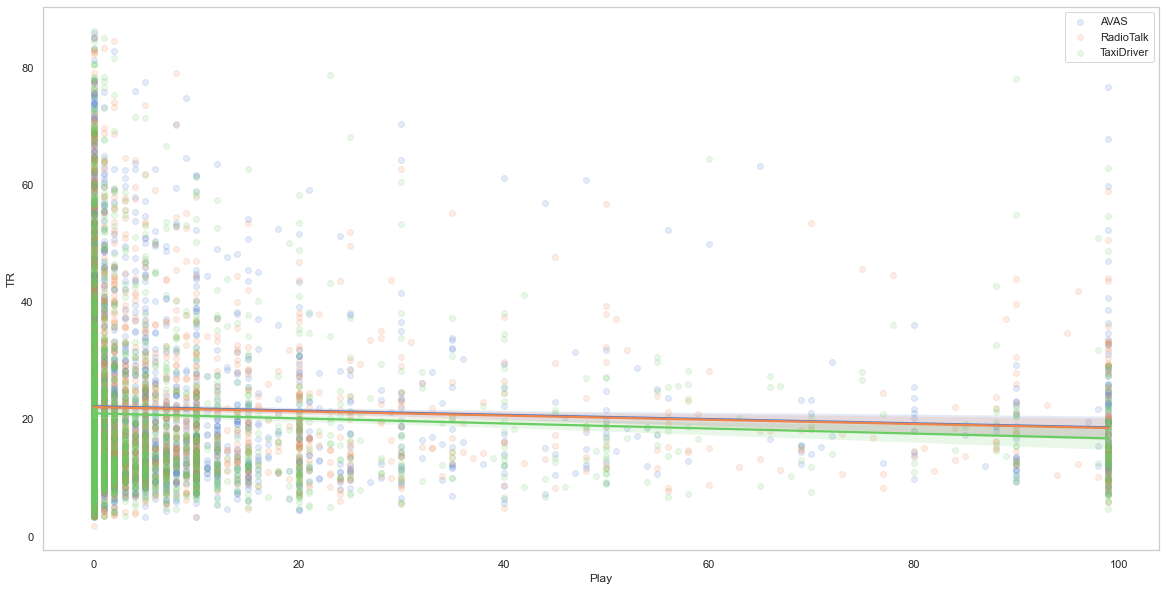

In [47]:
# palette = itertools.cycle(sns.color_palette(palette="muted"))  # color palette
cols = [
    "Intention",
    "Usefulness",
    "Ease",
    "Trust",
    # "Aviophobia",
    "Driving",
    "Play",
]
conds = ["AVAS", "RadioTalk", "TaxiDriver"]
for col in cols:
    palette = itertools.cycle(
        sns.color_palette(palette="muted")
    )  # color palette
    plt.figure(figsize=(20, 10))
    for cnd in conds:
        ax = sns.regplot(
            data=gaze_ltr[gaze_ltr.condition == cnd],
            y="TR",
            x=col,
            color=next(palette),
            label=cnd,
            scatter_kws={"alpha": 0.15},
        )
        ax.grid(False)
    plt.legend()
    plt.show()

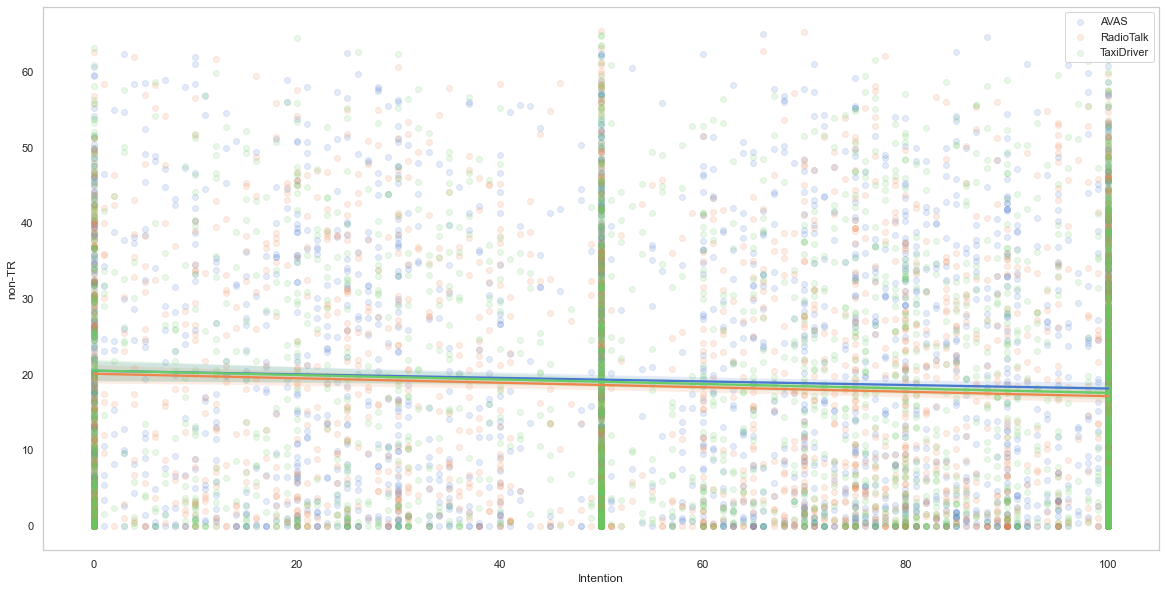

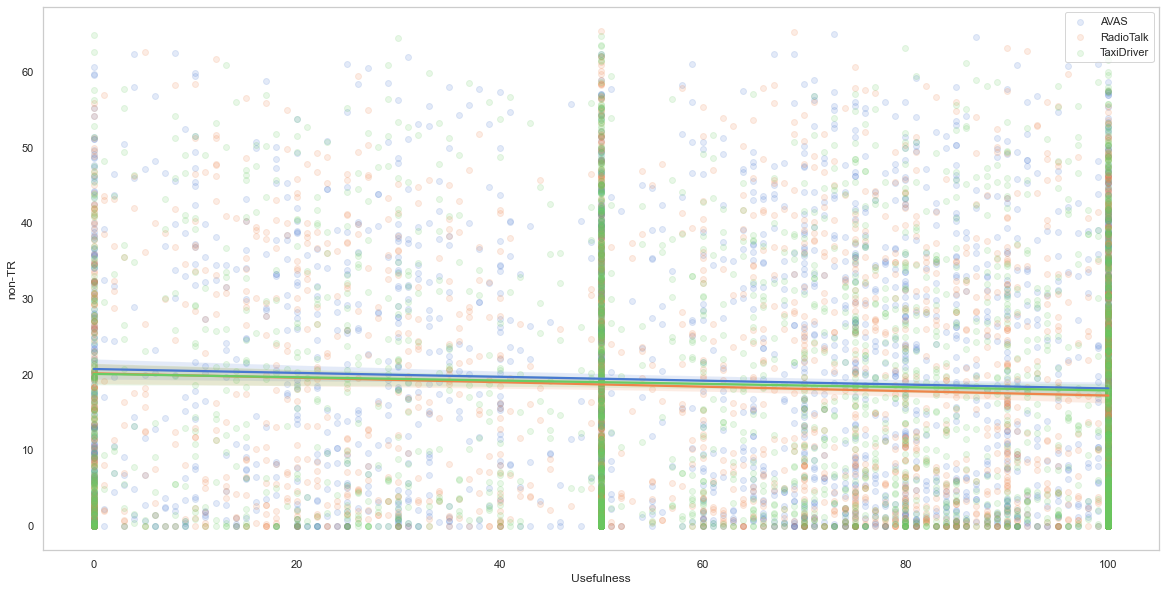

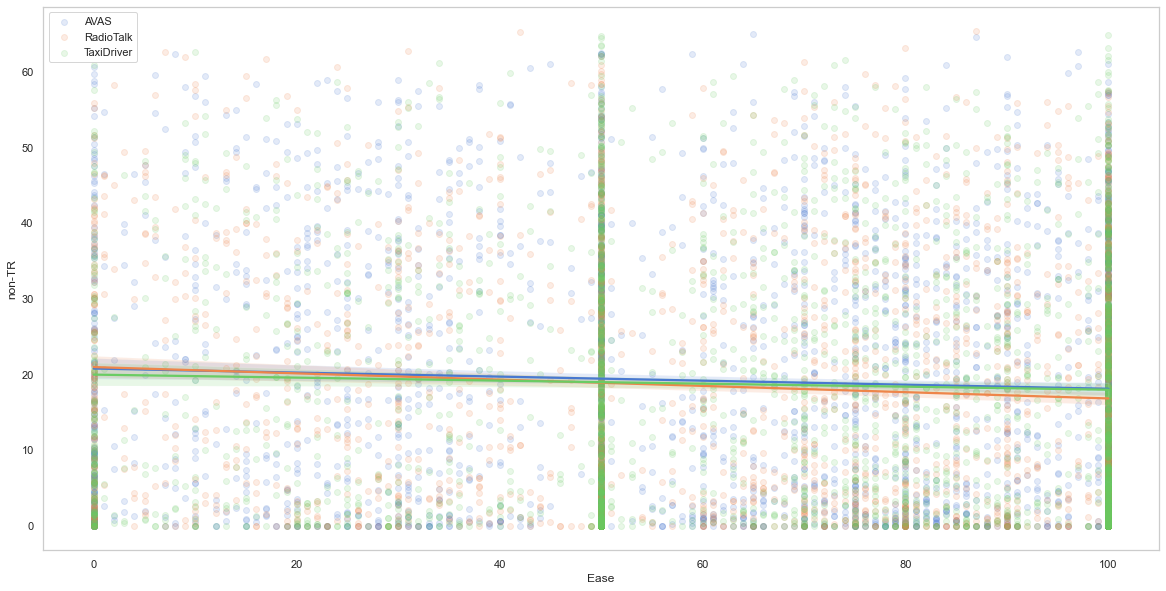

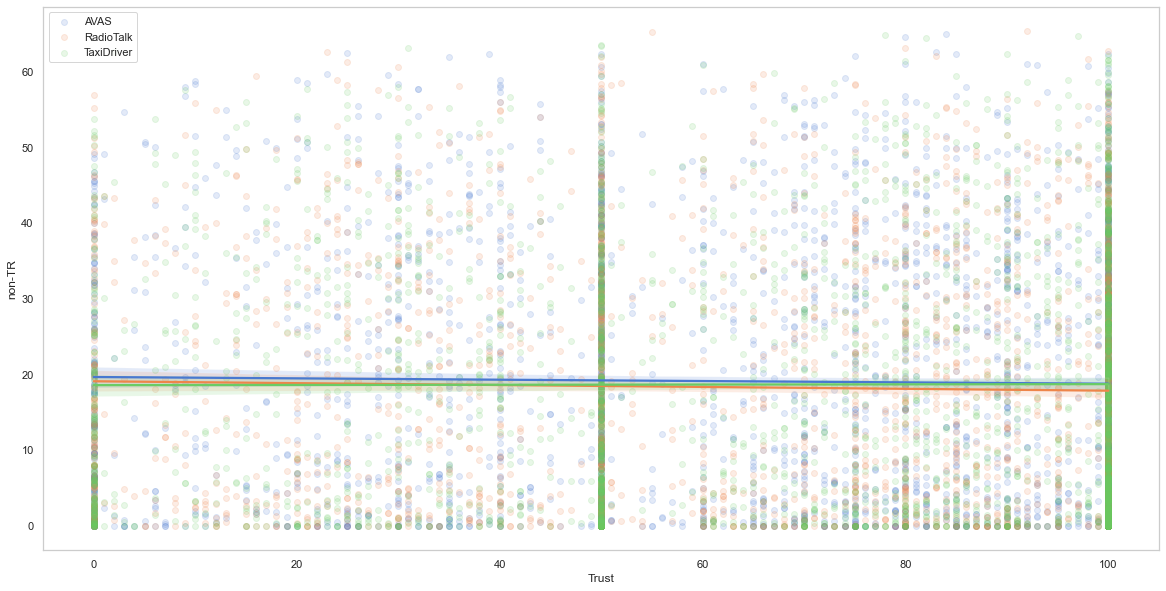

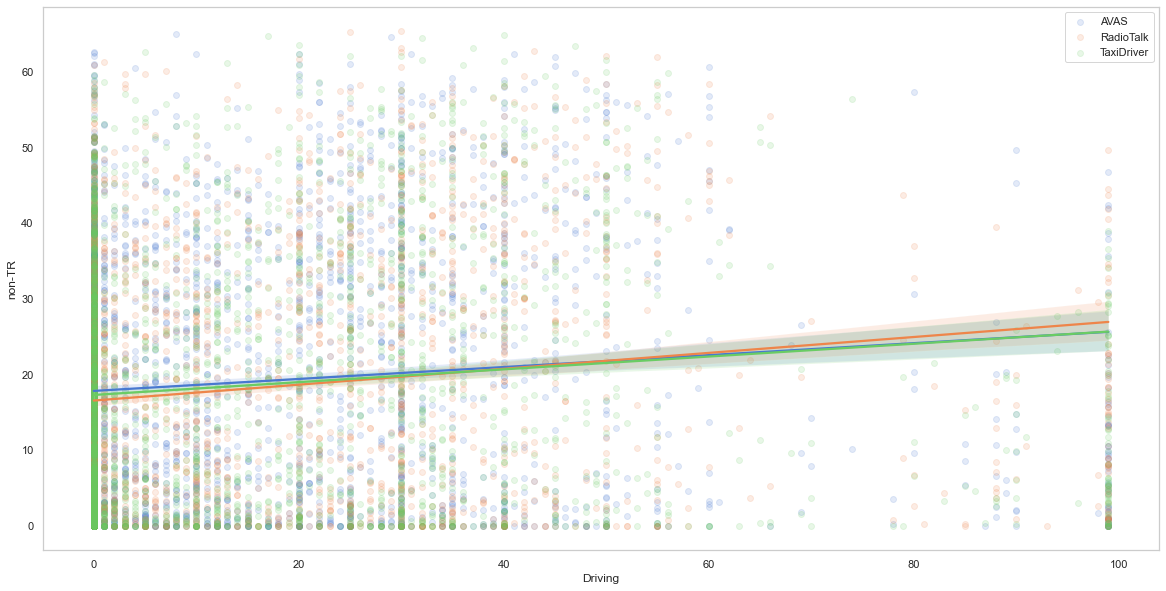

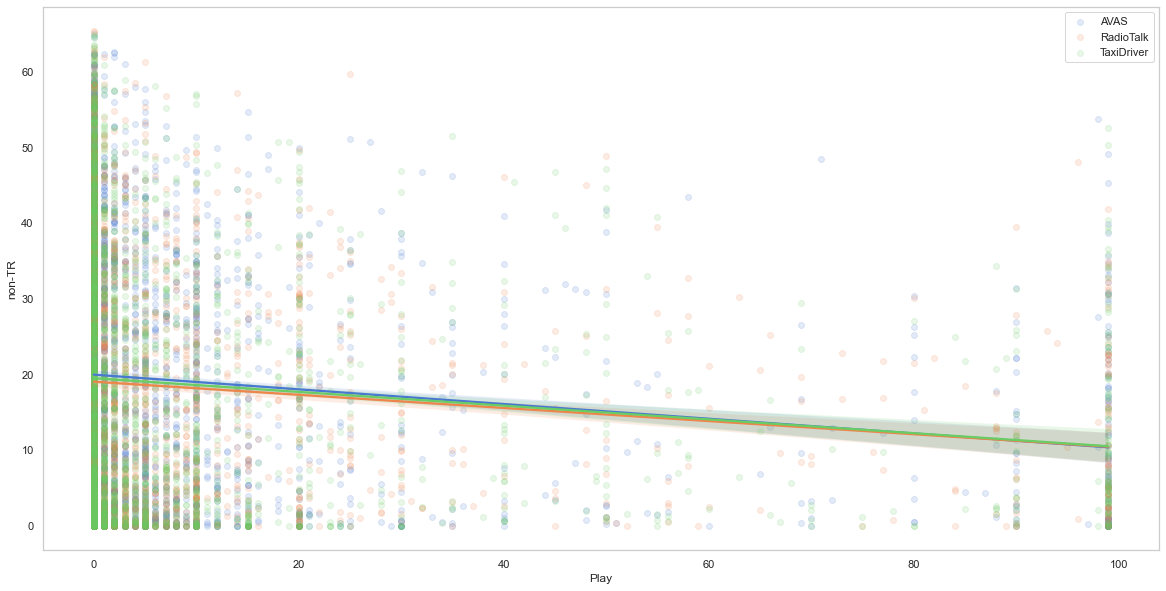

In [48]:
# palette = itertools.cycle(sns.color_palette(palette="muted"))  # color palette
cols = [
    "Intention",
    "Usefulness",
    "Ease",
    "Trust",
    # "Aviophobia",
    "Driving",
    "Play",
]
conds = ["AVAS", "RadioTalk", "TaxiDriver"]
for col in cols:
    palette = itertools.cycle(
        sns.color_palette(palette="muted")
    )  # color palette
    plt.figure(figsize=(20, 10))
    for cnd in conds:
        ax = sns.regplot(
            data=gaze_ltr[gaze_ltr.condition == cnd],
            y="non-TR",
            x=col,
            color=next(palette),
            label=cnd,
            scatter_kws={"alpha": 0.15},
        )
    ax.grid(False)
    plt.legend()
    plt.show()

In [49]:
select = parts[parts.questionnaire == "Yes"]
gaze_ctr = gaze_ctr.join(
    select[["expo", "side", "questionnaire"]], how="outer"
)
# select = gaze_ctr[gaze_ctr.questionnaire == "Yes"]
cols = [
    "Intention",
    "Usefulness",
    "Ease",
    "Trust",
    "Gender",
    "Age",
    # "Aviophobia",
    "Driving",
    "Play",
    "VR",
]
gaze_ctr = gaze_ctr.join(quests[cols], how="outer")
gaze_ctr

TR  non-TR   condition  expo   side  \
0002d624d34c44369f109d1c5d076d1b  27      23  TaxiDriver   NaN    NaN   
00040aa093c944f98a5c2f9ef515782a   4       0        AVAS   NaN    NaN   
000506554eb6453f94b51947d824731c  13      48        AVAS   NaN    NaN   
0007826f6d5a4bc8a4bf504f0f53a69f  24       0  TaxiDriver   NaN    NaN   
000966a73bce402d8d92ece7eb13e1f7  30      25        AVAS  BMBF  right   
...                               ..     ...         ...   ...    ...   
fff1761cade0489193486fb5191b47a9  28       0        AVAS   NaN    NaN   
fff21f23099e4e70b09ebc727e6365e5  30       0        AVAS   MSW   left   
fff77d4abc9b4937a78f5e4a8b9def12  37       0  TaxiDriver   MSW  right   
fffb6dd07f9c469aaf2fdb1272f154ec  24      33        AVAS   MSW  right   
fffe9dc8929a41588b7948267fcddbc9  24      44   RadioTalk   NaN    NaN   

                                 questionnaire  Intention  Usefulness    Ease  \
0002d624d34c44369f109d1c5d076d1b           NaN        NaN         NaN     NaN   
00040aa093c944f98a5c2f9ef515782a           NaN        NaN         NaN     NaN   
000506554eb6453f94b51947d824731c           NaN        NaN         NaN     NaN   
0007826f6d5a4bc8a4bf504f0f53a69f           NaN        NaN         NaN     NaN   
000966a73bce402d8d92ece7eb13e1f7           Yes     50.000      50.000  50.000   
...                                        ...        ...         ...     ...   
fff1761cade0489193486fb5191b47a9           NaN        NaN         NaN     NaN   
fff21f23099e4e70b09ebc727e6365e5           Yes     50.000      50.000  56.000   
fff77d4abc9b4937a78f5e4a8b9def12           Yes     50.000      30.000 100.000   
fffb6dd07f9c469aaf2fdb1272f154ec           Yes     50.000      20.000  33.000   
fffe9dc8929a41588b7948267fcddbc9           NaN        NaN         NaN     NaN   

                                  Trust  Gender    Age  Driving   Play  \
0002d624d34c44369f109d1c5d076d1b    NaN     NaN    NaN      NaN    NaN   
00040aa093c944f98a5c2f9ef515782a    NaN     NaN    NaN      NaN    NaN   
000506554eb6453f94b51947d824731c    NaN     NaN    NaN      NaN    NaN   
0007826f6d5a4bc8a4bf504f0f53a69f    NaN     NaN    NaN      NaN    NaN   
000966a73bce402d8d92ece7eb13e1f7 68.000  Female 15.000    0.000  4.000   
...                                 ...     ...    ...      ...    ...   
fff1761cade0489193486fb5191b47a9    NaN     NaN    NaN      NaN    NaN   
fff21f23099e4e70b09ebc727e6365e5 89.000    Male 19.000    0.000 30.000   
fff77d4abc9b4937a78f5e4a8b9def12 50.000    Male 46.000   27.000  0.000   
fffb6dd07f9c469aaf2fdb1272f154ec 36.000    Male 14.000    0.000 15.000   
fffe9dc8929a41588b7948267fcddbc9    NaN     NaN    NaN      NaN    NaN   

                                                  VR  
0002d624d34c44369f109d1c5d076d1b                 NaN  
00040aa093c944f98a5c2f9ef515782a                 NaN  
000506554eb6453f94b51947d824731c                 NaN  
0007826f6d5a4bc8a4bf504f0f53a69f                 NaN  
000966a73bce402d8d92ece7eb13e1f7                once  
...                                              ...  
fff1761cade0489193486fb5191b47a9                 NaN  
fff21f23099e4e70b09ebc727e6365e5                once  
fff77d4abc9b4937a78f5e4a8b9def12  less than 10 times  
fffb6dd07f9c469aaf2fdb1272f154ec  less than 10 times  
fffe9dc8929a41588b7948267fcddbc9                 NaN  

[20848 rows x 15 columns]

In [50]:
gaze_ctr = gaze_ctr[gaze_ctr.questionnaire == "Yes"]
gaze_ctr

TR  non-TR   condition  expo   side  \
000966a73bce402d8d92ece7eb13e1f7  30      25        AVAS  BMBF  right   
000ea0a15c0d476f89d084116e7b1e86  20       3        AVAS   MSW  right   
0015a3c9144248fb9571311e1140d7d0  29      26        AVAS   MSW  right   
001f482723604d929eff67b8e59f1db1  13      29   RadioTalk   MSW   left   
002063c0fd864a8c93fb114faee6417b  24       7  TaxiDriver   MSW   left   
...                               ..     ...         ...   ...    ...   
ffe8b0db1e4640d695641d7b6bd2099d   8      53  TaxiDriver   MSW  right   
ffeaa9becd4f451389d253b8ac0ba1bc   6      59        AVAS   MSW   left   
fff21f23099e4e70b09ebc727e6365e5  30       0        AVAS   MSW   left   
fff77d4abc9b4937a78f5e4a8b9def12  37       0  TaxiDriver   MSW  right   
fffb6dd07f9c469aaf2fdb1272f154ec  24      33        AVAS   MSW  right   

                                 questionnaire  Intention  Usefulness    Ease  \
000966a73bce402d8d92ece7eb13e1f7           Yes     50.000      50.000  50.000   
000ea0a15c0d476f89d084116e7b1e86           Yes     88.000      56.000  25.000   
0015a3c9144248fb9571311e1140d7d0           Yes     71.000      50.000  83.000   
001f482723604d929eff67b8e59f1db1           Yes     37.000      39.000  45.000   
002063c0fd864a8c93fb114faee6417b           Yes     77.000     100.000 100.000   
...                                        ...        ...         ...     ...   
ffe8b0db1e4640d695641d7b6bd2099d           Yes    100.000     100.000 100.000   
ffeaa9becd4f451389d253b8ac0ba1bc           Yes     83.000       0.000  87.000   
fff21f23099e4e70b09ebc727e6365e5           Yes     50.000      50.000  56.000   
fff77d4abc9b4937a78f5e4a8b9def12           Yes     50.000      30.000 100.000   
fffb6dd07f9c469aaf2fdb1272f154ec           Yes     50.000      20.000  33.000   

                                   Trust  Gender    Age  Driving   Play  \
000966a73bce402d8d92ece7eb13e1f7  68.000  Female 15.000    0.000  4.000   
000ea0a15c0d476f89d084116e7b1e86 100.000    Male 12.000    0.000  9.000   
0015a3c9144248fb9571311e1140d7d0  50.000    Male 23.000    4.000  4.000   
001f482723604d929eff67b8e59f1db1 100.000     N/A 81.000    0.000  5.000   
002063c0fd864a8c93fb114faee6417b 100.000  Female 14.000    0.000  1.000   
...                                  ...     ...    ...      ...    ...   
ffe8b0db1e4640d695641d7b6bd2099d 100.000    Male 17.000    0.000 50.000   
ffeaa9becd4f451389d253b8ac0ba1bc  61.000  Female 12.000    0.000  2.000   
fff21f23099e4e70b09ebc727e6365e5  89.000    Male 19.000    0.000 30.000   
fff77d4abc9b4937a78f5e4a8b9def12  50.000    Male 46.000   27.000  0.000   
fffb6dd07f9c469aaf2fdb1272f154ec  36.000    Male 14.000    0.000 15.000   

                                                  VR  
000966a73bce402d8d92ece7eb13e1f7                once  
000ea0a15c0d476f89d084116e7b1e86  less than 10 times  
0015a3c9144248fb9571311e1140d7d0  more than 10 times  
001f482723604d929eff67b8e59f1db1  less than 10 times  
002063c0fd864a8c93fb114faee6417b                once  
...                                              ...  
ffe8b0db1e4640d695641d7b6bd2099d  more than 10 times  
ffeaa9becd4f451389d253b8ac0ba1bc  less than 10 times  
fff21f23099e4e70b09ebc727e6365e5                once  
fff77d4abc9b4937a78f5e4a8b9def12  less than 10 times  
fffb6dd07f9c469aaf2fdb1272f154ec  less than 10 times  

[8207 rows x 15 columns]

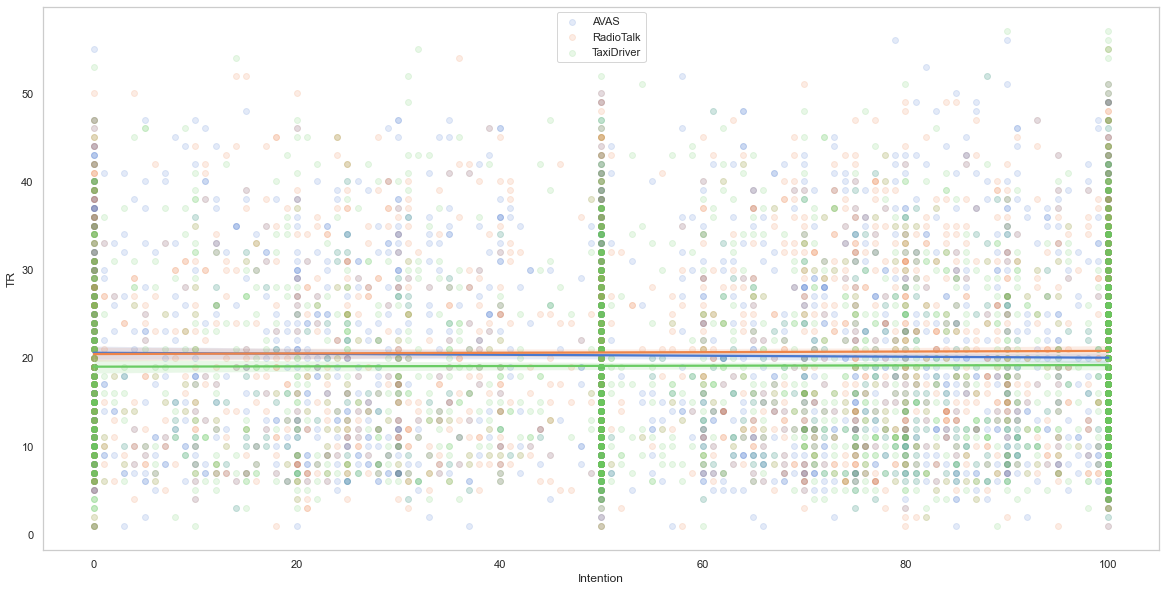

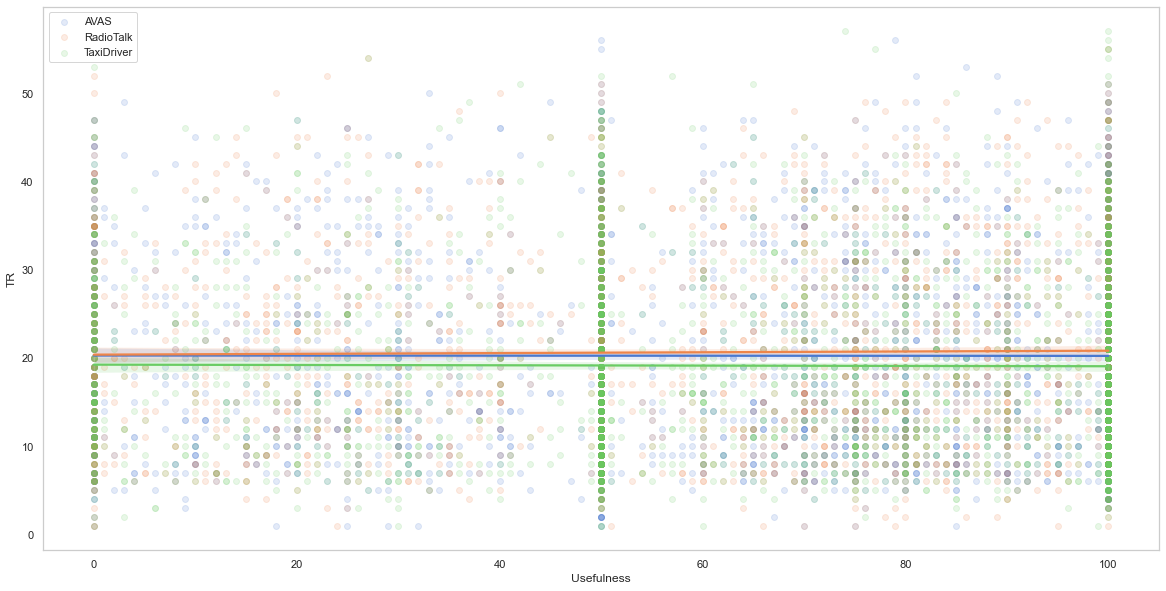

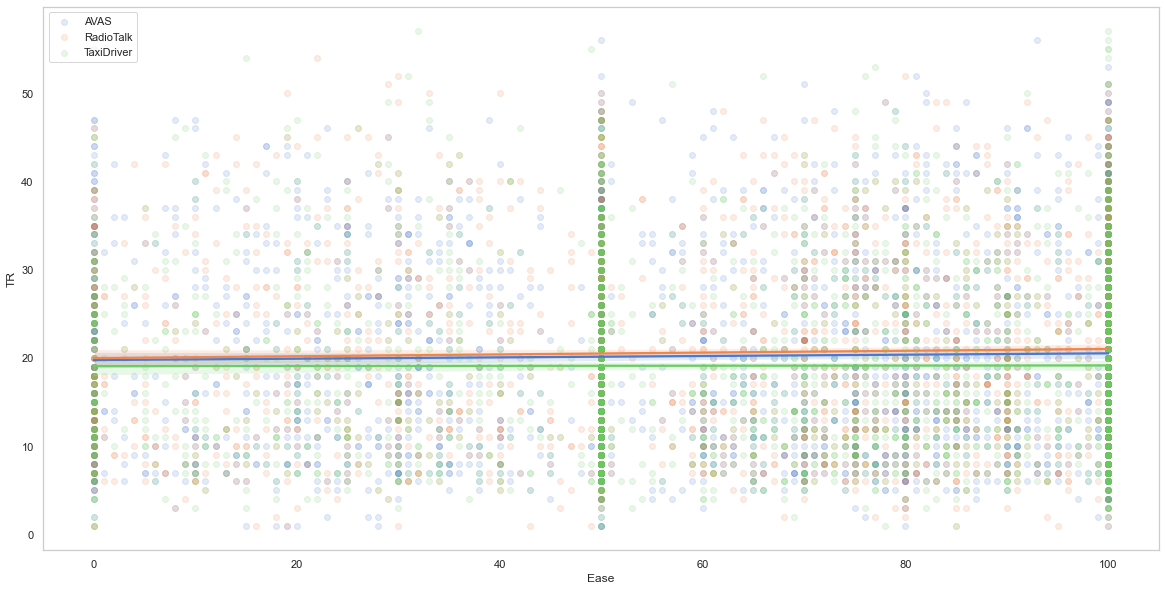

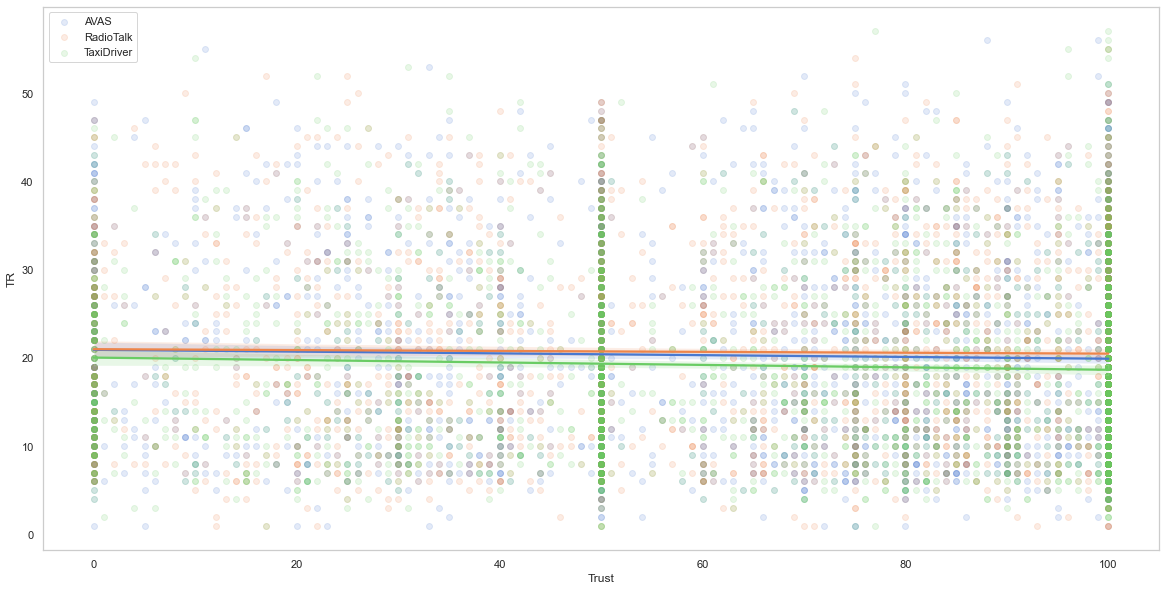

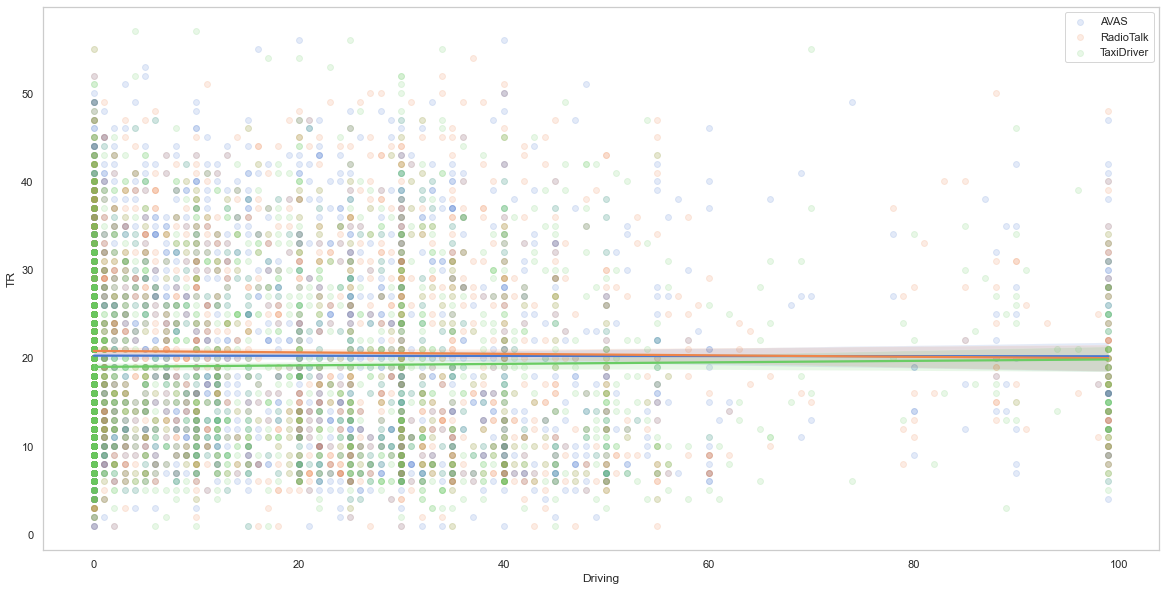

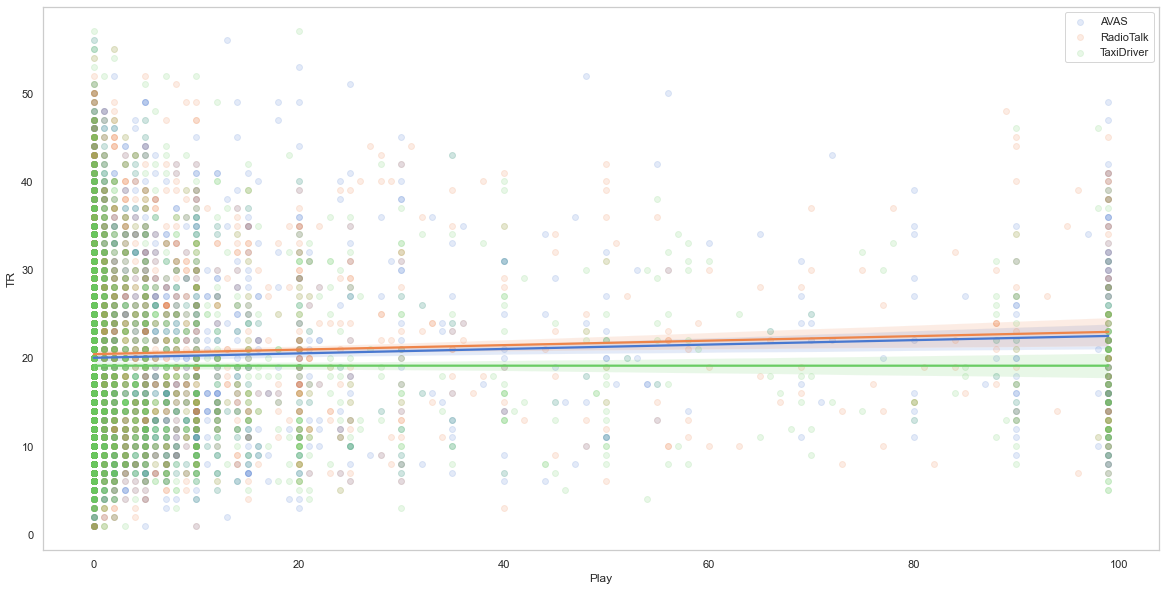

In [51]:
# palette = itertools.cycle(sns.color_palette(palette="muted"))  # color palette
cols = [
    "Intention",
    "Usefulness",
    "Ease",
    "Trust",
    # "Aviophobia",
    "Driving",
    "Play",
]
conds = ["AVAS", "RadioTalk", "TaxiDriver"]
for col in cols:
    palette = itertools.cycle(
        sns.color_palette(palette="muted")
    )  # color palette
    plt.figure(figsize=(20, 10))
    for cnd in conds:
        ax = sns.regplot(
            data=gaze_ctr[gaze_ctr.condition == cnd],
            y="TR",
            x=col,
            color=next(palette),
            label=cnd,
            scatter_kws={"alpha": 0.15},
        )
        ax.grid(False)
    plt.legend()
    plt.show()

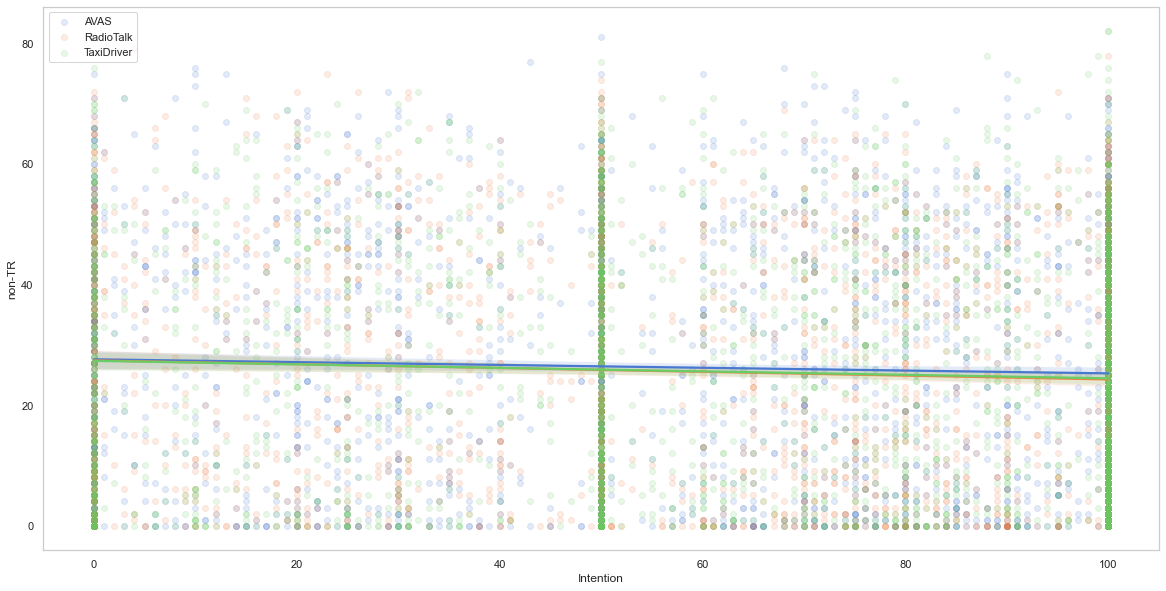

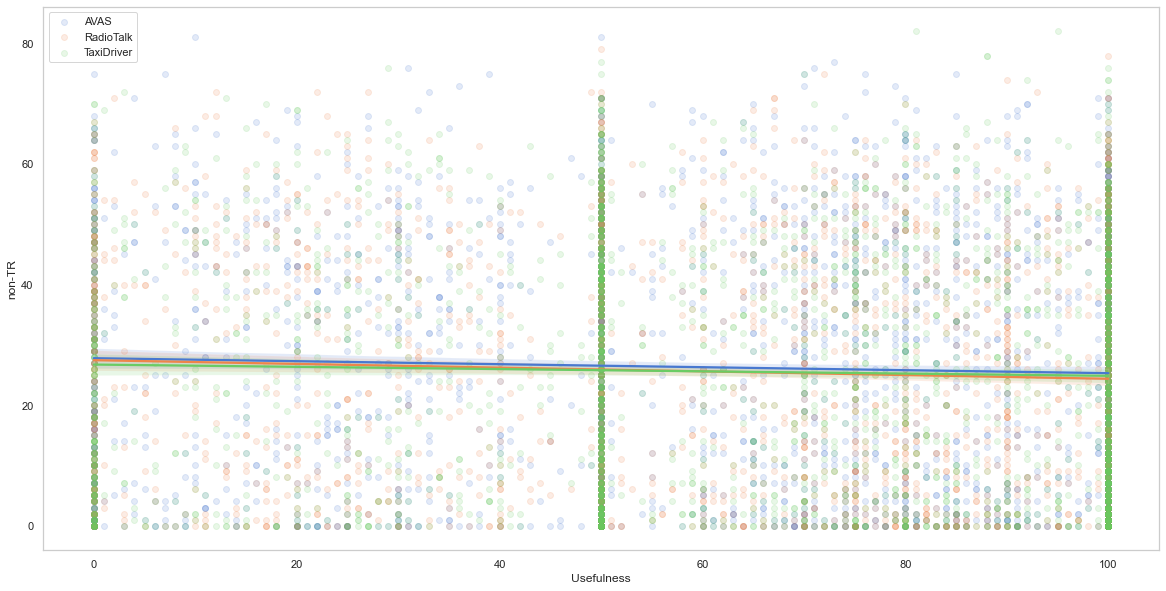

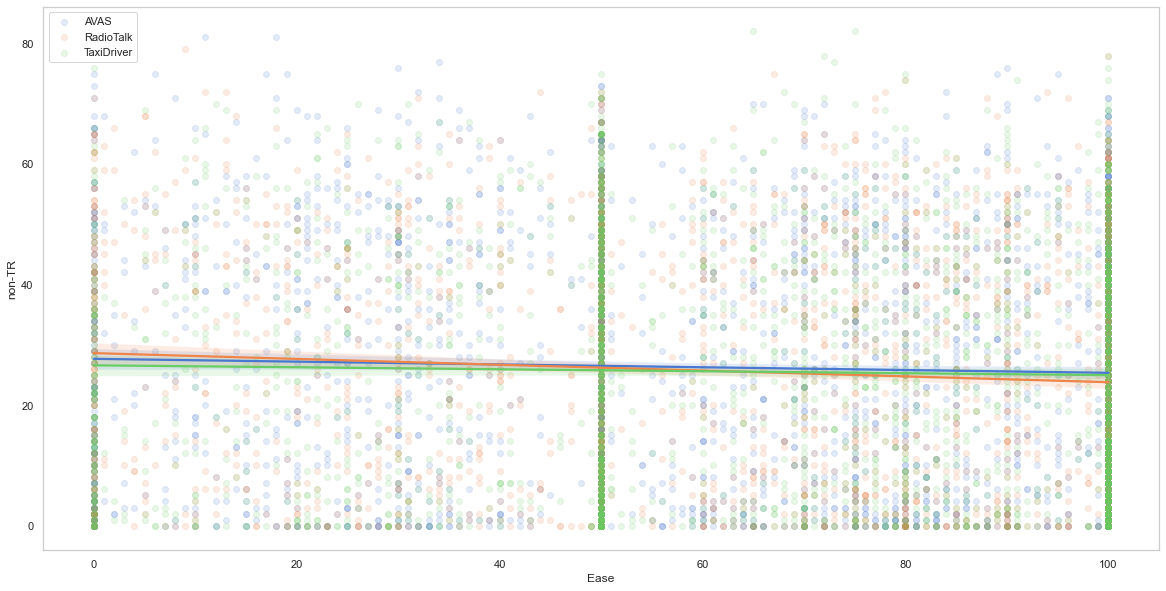

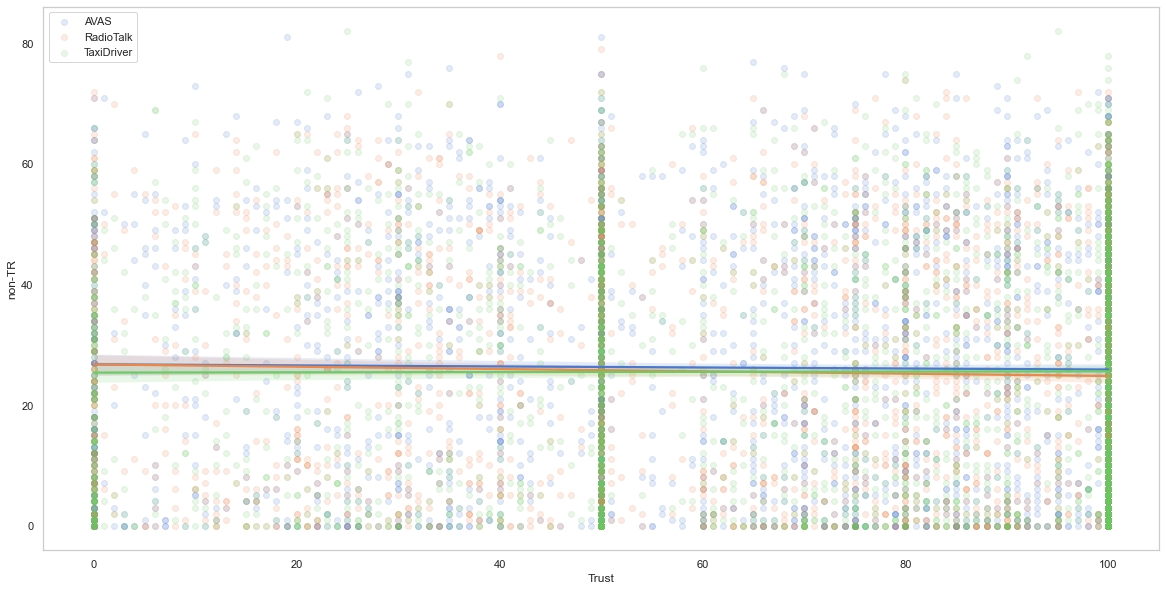

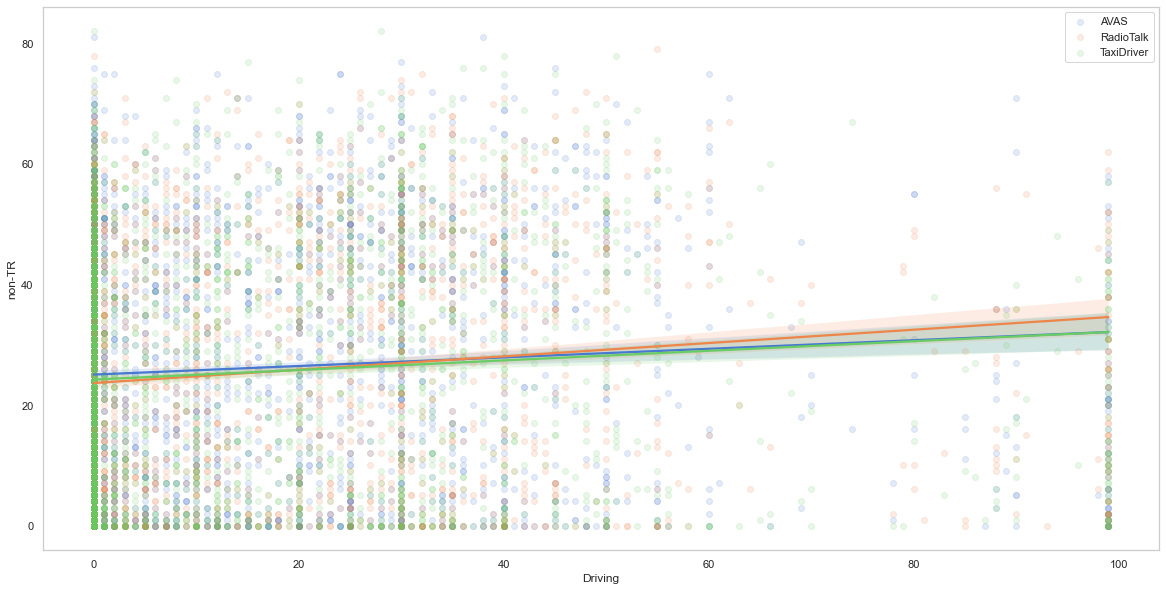

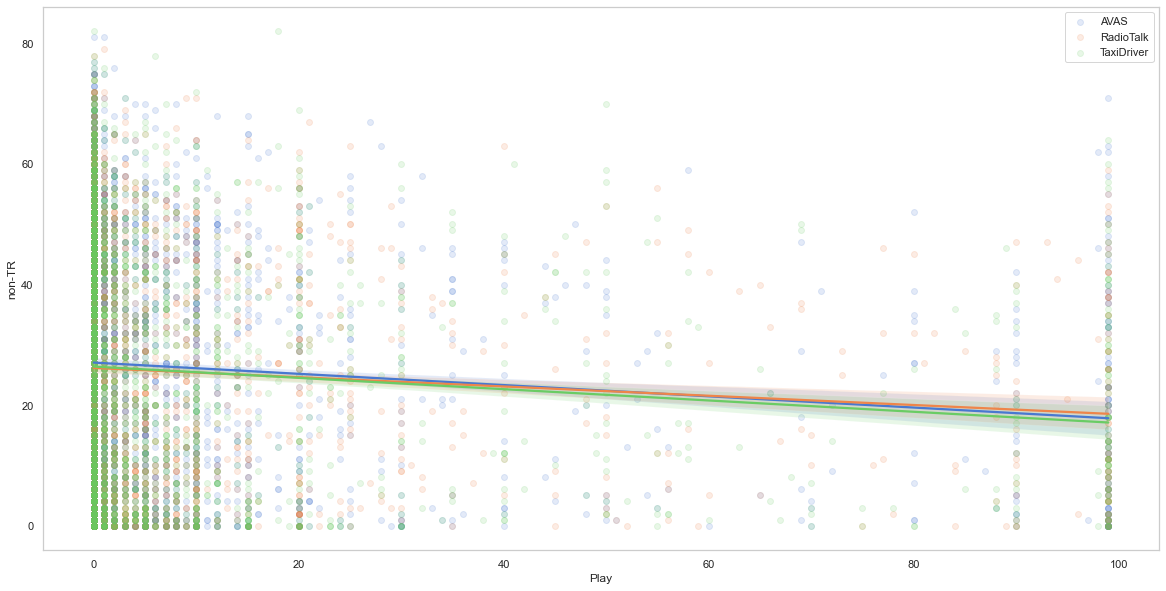

In [52]:
# palette = itertools.cycle(sns.color_palette(palette="muted"))  # color palette
cols = [
    "Intention",
    "Usefulness",
    "Ease",
    "Trust",
    # "Aviophobia",
    "Driving",
    "Play",
]
conds = ["AVAS", "RadioTalk", "TaxiDriver"]
for col in cols:
    palette = itertools.cycle(
        sns.color_palette(palette="muted")
    )  # color palette
    plt.figure(figsize=(20, 10))
    for cnd in conds:
        ax = sns.regplot(
            data=gaze_ctr[gaze_ctr.condition == cnd],
            y="non-TR",
            x=col,
            color=next(palette),
            label=cnd,
            scatter_kws={"alpha": 0.15},
        )
        ax.grid(False)
    plt.legend()
    plt.show()

Load the stored critical event frames

In [53]:
with open("gazes_and_hits-event_frames.json", "r") as file:
    ev_frames = json.load(file)

Plot events high alpha

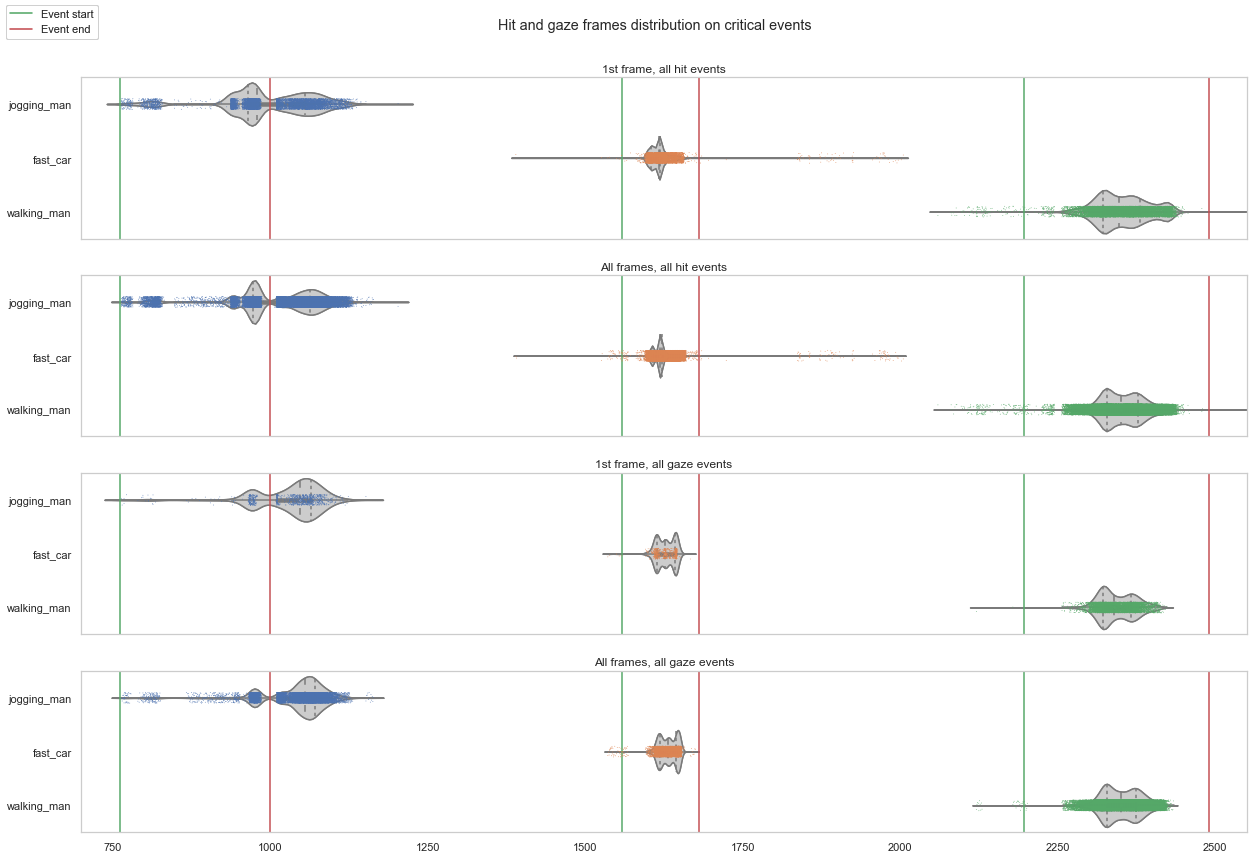

In [54]:
sns.set(rc={"figure.figsize": (17, 12)})  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(17, 12))
fig.suptitle("Hit and gaze frames distribution on critical events\n\n")
fig.tight_layout()

title_trans = {
    "h_start": "1st frame, all hit events",
    "g_start": "1st frame, all gaze events",
    "h_all": "All frames, all hit events",
    "g_all": "All frames, all gaze events",
}


def plot_event_frames(frames_dict, title, r, alpha=1):
    """
    Description.

    Parameters:
        frames_dict (dict): Blabla
    """
    # load dict into df (easier to plot using seaborn)
    df = pd.DataFrame.from_dict(
        data=frames_dict,
        orient="index",
    ).T
    # violinplot with quartiles
    ax = sns.violinplot(
        data=df,
        orient="h",
        inner="quartile",
        color=".8",
        scale="width",
        ax=axes[r],
    )
    # violinplot with boxplot
    ax = sns.violinplot(
        data=df, orient="h", color=".8", scale="width", ax=axes[r]
    )
    # categorical scatterplot
    ax = sns.stripplot(data=df, orient="h", alpha=alpha, ax=axes[r], size=0.8)

    # plot event ranges (vetical lines)
    for tup in event_ranges:
        axes[r].axvline(x=tup[0] - 400, color="g")  # plot start
        axes[r].axvline(x=tup[1] - 400, color="r")  # plot end
    ax.set_xlim(700, 2550)
    ax.grid(False)
    if r < 3:
        ax.xaxis.set_visible(False)
    ax.title.set_text(title_trans[title])
    # set custom legend for vertical lines
    start_line = Line2D([0], [0], color="g", label="Event start")
    end_line = Line2D([0], [0], color="r", label="Event end")
    fig.legend(handles=[start_line, end_line], loc="upper left")


for i, k in enumerate(ev_frames.keys()):
    plot_event_frames(ev_frames[k], k, i)

plt.show()

Plot events low alpha

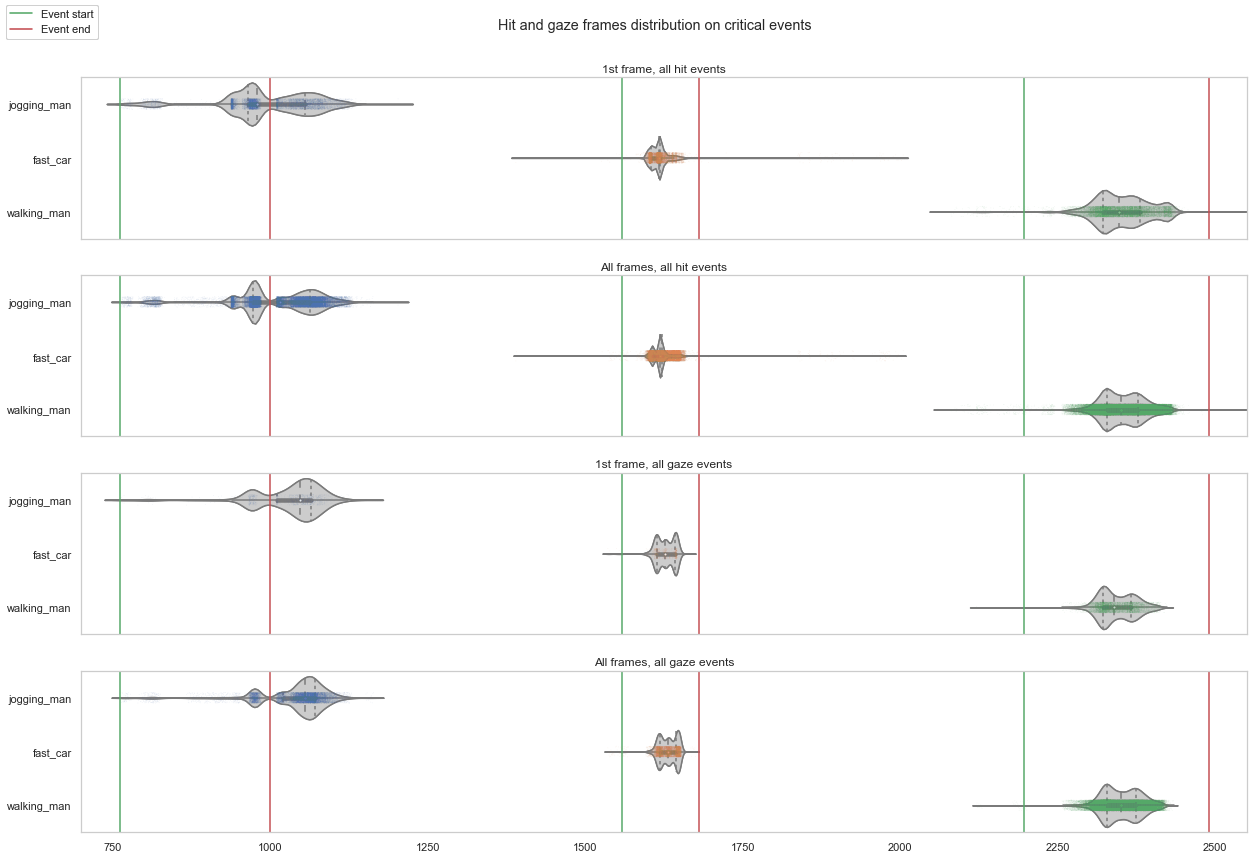

In [55]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(17, 12))
fig.suptitle("Hit and gaze frames distribution on critical events\n\n")
fig.tight_layout()

for i, k in enumerate(ev_frames.keys()):
    plot_event_frames(ev_frames[k], k, i, 0.1)

plt.show()

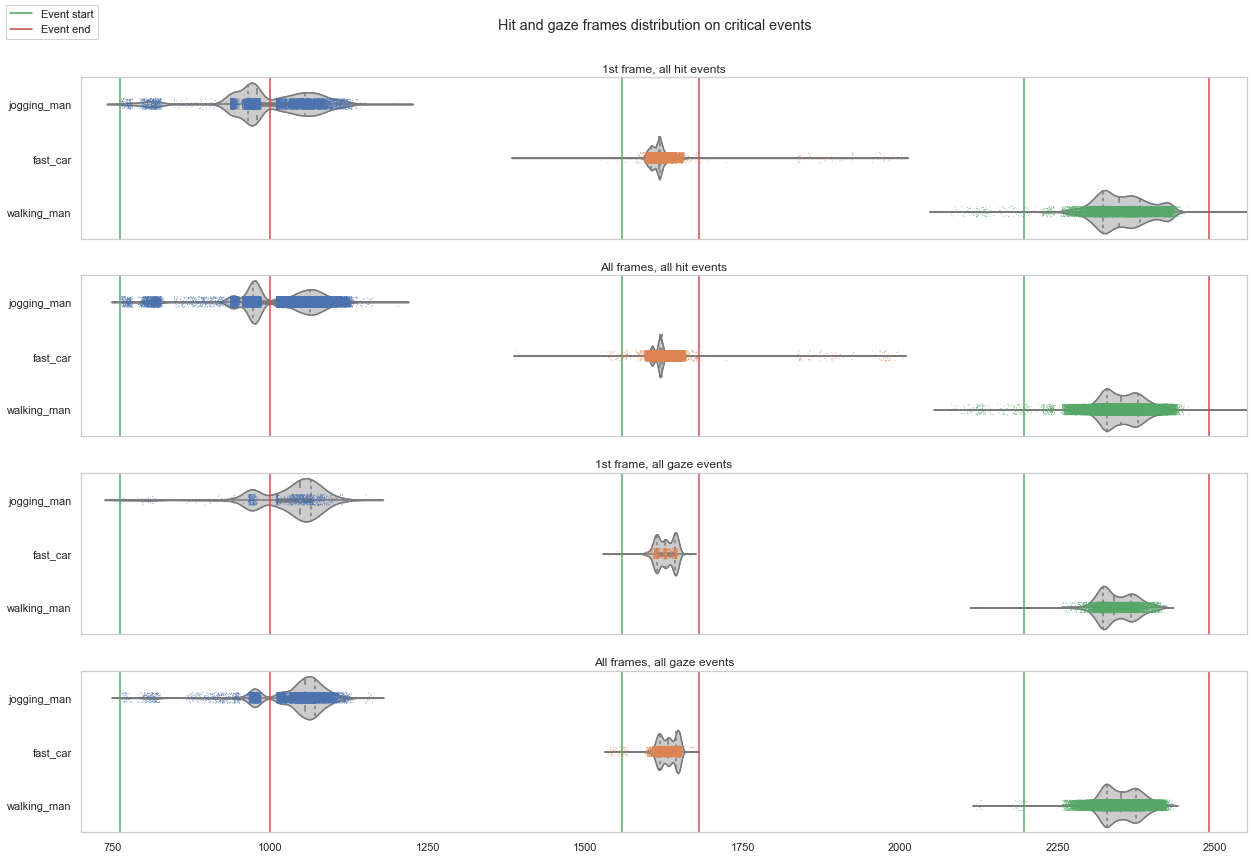

In [56]:
sns.set(rc={"figure.figsize": (17, 12)})  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(17, 12))
fig.suptitle("Hit and gaze frames distribution on critical events\n\n")
fig.tight_layout()

title_trans = {
    "h_start": "1st frame, all hit events",
    "g_start": "1st frame, all gaze events",
    "h_all": "All frames, all hit events",
    "g_all": "All frames, all gaze events",
}


def plot_event_frames(frames_dict, title, r, alpha=1):
    """
    Description.

    Parameters:
        frames_dict (dict): Blabla
    """
    # load dict into df (easier to plot using seaborn)
    df = pd.DataFrame.from_dict(
        data=frames_dict,
        orient="index",
    ).T
    # violinplot with quartiles
    ax = sns.violinplot(
        data=df,
        orient="h",
        inner="quartile",
        color=".8",
        scale="width",
        ax=axes[r],
    )
    # violinplot with boxplot
    ax = sns.violinplot(
        data=df, orient="h", color=".8", scale="width", ax=axes[r]
    )
    # categorical scatterplot
    ax = sns.stripplot(data=df, orient="h", alpha=alpha, ax=axes[r], size=0.8)

    # plot event ranges (vetical lines)
    for tup in event_ranges:
        axes[r].axvline(x=tup[0] - 400, color="g")  # plot start
        axes[r].axvline(x=tup[1] - 400, color="r")  # plot end
    ax.set_xlim(700, 2550)
    ax.grid(False)
    if r < 3:
        ax.xaxis.set_visible(False)
    ax.title.set_text(title_trans[title])
    # set custom legend for vertical lines
    start_line = Line2D([0], [0], color="g", label="Event start")
    end_line = Line2D([0], [0], color="r", label="Event end")
    fig.legend(handles=[start_line, end_line], loc="upper left")


for i, k in enumerate(ev_frames.keys()):
    plot_event_frames(ev_frames[k], k, i)

plt.show()

In [57]:
parts_evs = copy.deepcopy(parts)
parts_evs

date  expo   side  \
id                                                                   
4f583872ffed48249874b00f3d389cfc  2019-05-14 13:21:00   MSW  right   
33d68ad55ef544fab9fd08108e3913ca  2019-05-14 16:44:00   MSW  right   
37d7e67934974217830bb429bba7fd76  2019-05-14 16:54:00   MSW   left   
9cdd85098b0b4ad5ab2282a5ac371a5e  2019-05-14 16:59:00   MSW  right   
ff846d92c7e6471183595bd2678f29f6  2019-05-14 17:37:00   MSW  right   
...                                               ...   ...    ...   
dba04b626e4c4c6e89aea4fb1f9cc32b  2019-12-30 13:48:00  BMBF   left   
611d35a7c3e940cc82495e53c2a8532d  2020-01-03 16:12:00  BMBF  right   
3b6fda285d9e412eb081986b2f22a2e3  2020-01-03 16:13:00  BMBF   left   
18ffb0abdc8642098c479380bfa533d1  2020-01-03 16:15:00  BMBF   left   
c06f123b35b74bb489ec239b1cac9eb4  2020-01-03 16:16:00  BMBF  right   

                                   condition  nulls_%  sky_%  insidecar_%  \
id                                                                          
4f583872ffed48249874b00f3d389cfc  TaxiDriver    1.610 13.740        2.359   
33d68ad55ef544fab9fd08108e3913ca        AVAS    0.037  0.674       25.421   
37d7e67934974217830bb429bba7fd76        AVAS    0.824 18.607        2.845   
9cdd85098b0b4ad5ab2282a5ac371a5e        AVAS    0.000 20.030        0.000   
ff846d92c7e6471183595bd2678f29f6        AVAS    0.037 15.575        1.235   
...                                      ...      ...    ...          ...   
dba04b626e4c4c6e89aea4fb1f9cc32b  TaxiDriver    0.000 22.501        0.000   
611d35a7c3e940cc82495e53c2a8532d  TaxiDriver    0.674 15.462        5.054   
3b6fda285d9e412eb081986b2f22a2e3        AVAS    1.797  3.370       11.718   
18ffb0abdc8642098c479380bfa533d1   RadioTalk    0.150 17.484        1.872   
c06f123b35b74bb489ec239b1cac9eb4  TaxiDriver    0.187  2.583       17.634   

                                 questionnaire  
id                                              
4f583872ffed48249874b00f3d389cfc            No  
33d68ad55ef544fab9fd08108e3913ca            No  
37d7e67934974217830bb429bba7fd76            No  
9cdd85098b0b4ad5ab2282a5ac371a5e            No  
ff846d92c7e6471183595bd2678f29f6            No  
...                                        ...  
dba04b626e4c4c6e89aea4fb1f9cc32b           Yes  
611d35a7c3e940cc82495e53c2a8532d            No  
3b6fda285d9e412eb081986b2f22a2e3            No  
18ffb0abdc8642098c479380bfa533d1           Yes  
c06f123b35b74bb489ec239b1cac9eb4            No  

[20848 rows x 8 columns]

In [58]:
uids = parts_evs.index.tolist()
PATH_GAZE_FRAMES = "./data/processed/events/frames"

coll_gevs = {
    uid: {"jogging_man": None, "fast_car": None, "walking_man": None}
    for uid in uids
}

# participants progress bar
uids_pbar = tqdm(
    iterable=uids,
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for uid in uids_pbar:
    try:
        with open(f"{PATH_GAZE_FRAMES}/{uid}.json", "r") as file:
            ev_frames = json.load(file)
            for obj in ev_frames.keys():
                coll_gevs[uid][obj] = len(ev_frames[obj]["g_start"])
    except:
        for obj in coll_gevs[uid].keys():
            coll_gevs[uid][obj] = 0

📄 0 of 20848 📂 participants processed:                                                                        …

In [59]:
test = pd.DataFrame(coll_gevs)
test = test.transpose()
for col in test.columns.tolist():
    parts_evs[col] = test[col]

parts_evs

date  expo   side  \
id                                                                   
4f583872ffed48249874b00f3d389cfc  2019-05-14 13:21:00   MSW  right   
33d68ad55ef544fab9fd08108e3913ca  2019-05-14 16:44:00   MSW  right   
37d7e67934974217830bb429bba7fd76  2019-05-14 16:54:00   MSW   left   
9cdd85098b0b4ad5ab2282a5ac371a5e  2019-05-14 16:59:00   MSW  right   
ff846d92c7e6471183595bd2678f29f6  2019-05-14 17:37:00   MSW  right   
...                                               ...   ...    ...   
dba04b626e4c4c6e89aea4fb1f9cc32b  2019-12-30 13:48:00  BMBF   left   
611d35a7c3e940cc82495e53c2a8532d  2020-01-03 16:12:00  BMBF  right   
3b6fda285d9e412eb081986b2f22a2e3  2020-01-03 16:13:00  BMBF   left   
18ffb0abdc8642098c479380bfa533d1  2020-01-03 16:15:00  BMBF   left   
c06f123b35b74bb489ec239b1cac9eb4  2020-01-03 16:16:00  BMBF  right   

                                   condition  nulls_%  sky_%  insidecar_%  \
id                                                                          
4f583872ffed48249874b00f3d389cfc  TaxiDriver    1.610 13.740        2.359   
33d68ad55ef544fab9fd08108e3913ca        AVAS    0.037  0.674       25.421   
37d7e67934974217830bb429bba7fd76        AVAS    0.824 18.607        2.845   
9cdd85098b0b4ad5ab2282a5ac371a5e        AVAS    0.000 20.030        0.000   
ff846d92c7e6471183595bd2678f29f6        AVAS    0.037 15.575        1.235   
...                                      ...      ...    ...          ...   
dba04b626e4c4c6e89aea4fb1f9cc32b  TaxiDriver    0.000 22.501        0.000   
611d35a7c3e940cc82495e53c2a8532d  TaxiDriver    0.674 15.462        5.054   
3b6fda285d9e412eb081986b2f22a2e3        AVAS    1.797  3.370       11.718   
18ffb0abdc8642098c479380bfa533d1   RadioTalk    0.150 17.484        1.872   
c06f123b35b74bb489ec239b1cac9eb4  TaxiDriver    0.187  2.583       17.634   

                                 questionnaire  jogging_man  fast_car  \
id                                                                      
4f583872ffed48249874b00f3d389cfc            No            0         0   
33d68ad55ef544fab9fd08108e3913ca            No            0         0   
37d7e67934974217830bb429bba7fd76            No            0         1   
9cdd85098b0b4ad5ab2282a5ac371a5e            No            0         0   
ff846d92c7e6471183595bd2678f29f6            No            0         0   
...                                        ...          ...       ...   
dba04b626e4c4c6e89aea4fb1f9cc32b           Yes            0         0   
611d35a7c3e940cc82495e53c2a8532d            No            0         0   
3b6fda285d9e412eb081986b2f22a2e3            No            0         0   
18ffb0abdc8642098c479380bfa533d1           Yes            0         1   
c06f123b35b74bb489ec239b1cac9eb4            No            0         0   

                                  walking_man  
id                                             
4f583872ffed48249874b00f3d389cfc            0  
33d68ad55ef544fab9fd08108e3913ca            0  
37d7e67934974217830bb429bba7fd76            0  
9cdd85098b0b4ad5ab2282a5ac371a5e            0  
ff846d92c7e6471183595bd2678f29f6            1  
...                                       ...  
dba04b626e4c4c6e89aea4fb1f9cc32b            0  
611d35a7c3e940cc82495e53c2a8532d            0  
3b6fda285d9e412eb081986b2f22a2e3            0  
18ffb0abdc8642098c479380bfa533d1            0  
c06f123b35b74bb489ec239b1cac9eb4            0  

[20848 rows x 11 columns]

In [60]:
cols = test.columns.tolist()
cols.append("condition")
cols.append("side")
display(parts_evs[cols].groupby(["condition"]).describe().transpose())

condition             AVAS  RadioTalk  TaxiDriver
jogging_man count 7173.000   6867.000    6808.000
            mean     0.048      0.047       0.050
            std      0.234      0.228       0.242
            min      0.000      0.000       0.000
            25%      0.000      0.000       0.000
            50%      0.000      0.000       0.000
            75%      0.000      0.000       0.000
            max      3.000      4.000       3.000
fast_car    count 7173.000   6867.000    6808.000
            mean     0.015      0.024       0.054
            std      0.127      0.158       0.230
            min      0.000      0.000       0.000
            25%      0.000      0.000       0.000
            50%      0.000      0.000       0.000
            75%      0.000      0.000       0.000
            max      2.000      2.000       2.000
walking_man count 7173.000   6867.000    6808.000
            mean     0.379      0.297       0.226
            std      0.542      0.494       0.470
            min      0.000      0.000       0.000
            25%      0.000      0.000       0.000
            50%      0.000      0.000       0.000
            75%      1.000      1.000       0.000
            max      4.000      3.000       3.000

In [61]:
parts_evs[cols]

jogging_man  fast_car  walking_man  \
id                                                                     
4f583872ffed48249874b00f3d389cfc            0         0            0   
33d68ad55ef544fab9fd08108e3913ca            0         0            0   
37d7e67934974217830bb429bba7fd76            0         1            0   
9cdd85098b0b4ad5ab2282a5ac371a5e            0         0            0   
ff846d92c7e6471183595bd2678f29f6            0         0            1   
...                                       ...       ...          ...   
dba04b626e4c4c6e89aea4fb1f9cc32b            0         0            0   
611d35a7c3e940cc82495e53c2a8532d            0         0            0   
3b6fda285d9e412eb081986b2f22a2e3            0         0            0   
18ffb0abdc8642098c479380bfa533d1            0         1            0   
c06f123b35b74bb489ec239b1cac9eb4            0         0            0   

                                   condition   side  
id                                                   
4f583872ffed48249874b00f3d389cfc  TaxiDriver  right  
33d68ad55ef544fab9fd08108e3913ca        AVAS  right  
37d7e67934974217830bb429bba7fd76        AVAS   left  
9cdd85098b0b4ad5ab2282a5ac371a5e        AVAS  right  
ff846d92c7e6471183595bd2678f29f6        AVAS  right  
...                                      ...    ...  
dba04b626e4c4c6e89aea4fb1f9cc32b  TaxiDriver   left  
611d35a7c3e940cc82495e53c2a8532d  TaxiDriver  right  
3b6fda285d9e412eb081986b2f22a2e3        AVAS   left  
18ffb0abdc8642098c479380bfa533d1   RadioTalk   left  
c06f123b35b74bb489ec239b1cac9eb4  TaxiDriver  right  

[20848 rows x 5 columns]

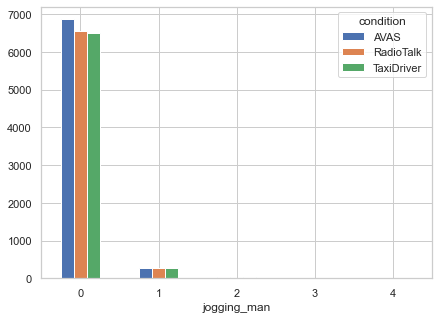

condition       AVAS  RadioTalk  TaxiDriver
jogging_man                                
0           6863.000   6569.000    6505.000
1            282.000    279.000     270.000
2             25.000     17.000      30.000
3              3.000      1.000       3.000
4                NaN      1.000         NaN

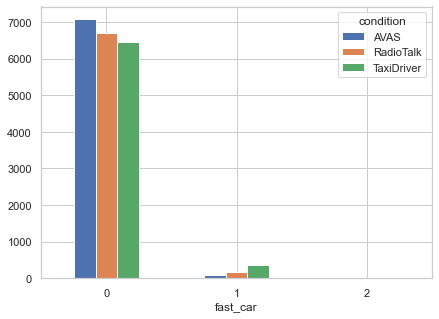

condition  AVAS  RadioTalk  TaxiDriver
fast_car                              
0          7068       6704        6449
1           101        159         352
2             4          4           7

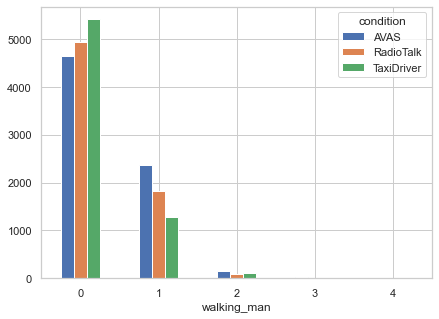

condition       AVAS  RadioTalk  TaxiDriver
walking_man                                
0           4641.000   4938.000    5410.000
1           2366.000   1827.000    1273.000
2            147.000     93.000     109.000
3             17.000      9.000      16.000
4              2.000        NaN         NaN

In [62]:
cols = test.columns.tolist()
for col in cols:
    ax = (
        parts_evs.groupby(col)["condition"]
        .value_counts()
        .unstack()
        .plot.bar(figsize=(7, 5), rot=0)
    )
    plt.show()
    display(
        parts_evs.groupby("condition")[col]
        .value_counts()
        .unstack()
        .transpose()
    )

In [63]:
with open("gazes_and_hits-event_frames.json", "r") as file:
    ev_frames = json.load(file)

events = ev_frames["g_start"].keys()

for e in events:
    print(f"Event {e}: {len(ev_frames['g_start'][e])}")

Event jogging_man: 1030
Event fast_car: 701
Event walking_man: 6572


In [64]:
parts_evs[events].sum()

jogging_man    1000
fast_car        642
walking_man    6298
dtype: int64